In [6]:
import os
import cv2
from augment_pictures import get_average_bounding_box, add_picture_to_picture

In [7]:
import sys
sys.path.append(".")
VARIANTS = ["train", "test", "valid"]
TARGET_RESOLUTION = (1280, 1280)
OVERLAP = 0.0 # As a percentage
OUTPUT_FOLDER = "/notebooks/DL---detection-of-birds-in-drone-images/data/tiled_augmented_yolo_data"
INPUT_FOLDER = "/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format"

# Create the output folders
for variant in VARIANTS:
    if not os.path.exists(os.path.join(OUTPUT_FOLDER, variant)):
        os.makedirs(os.path.join(OUTPUT_FOLDER, variant, "images"), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_FOLDER, variant, "labels"), exist_ok=True)

files = []
for variant in VARIANTS:
    for file in os.listdir(os.path.join(INPUT_FOLDER, variant, "images")):
        files.append(os.path.join(INPUT_FOLDER, variant, "images", file))


In [8]:
import numpy as np


def gamma_correction(image, gamma=1.0):
    # Ensure gamma is a positive number
    if gamma <= 0:
        raise ValueError("Gamma should be greater than 0")

    # Build a lookup table mapping pixel values [0, 255] to their gamma-corrected values
    inv_gamma = 1.0 / gamma
    table = np.array([
        ((i / 255.0) ** inv_gamma) * 255
        for i in range(256)
    ]).astype("uint8")

    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def auto_gamma(image, target_brightness=0.5):
    """
    Automatically adjusts gamma to normalize image brightness.

    Gamma > 1 brightens the image, Gamma < 1 darkens the image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray) / 255.0

    # Prevent division by zero or extremely low brightness
    if brightness < 1e-3:
        gamma = 2.5  # Force strong brightening
    else:
        gamma = target_brightness / brightness

    gamma = np.clip(gamma, 0.3, 3.0)  # Clamp to reasonable range
    corrected = gamma_correction(image, gamma)
    return corrected, gamma


In [9]:
len(os.listdir("/notebooks/DL---detection-of-birds-in-drone-images/data/tiled_augmented_yolo_data/train/images"))

0

In [10]:

import math

all_new_tiles = {}
gammas = []

for file in files:
    img_tiles = []
    if ".ipynb_checkpoints" in file or ".DS_Store" in file:
        continue
    img = cv2.imread(file)
    print(file)

    h, w, channels = img.shape

    x_tile_step = TARGET_RESOLUTION[0] * (1-OVERLAP)
    y_tile_step = TARGET_RESOLUTION[1] * (1-OVERLAP)

    number_of_images_w = math.ceil(w / x_tile_step)
    number_of_images_h = math.ceil(h / y_tile_step)

    for y in range(number_of_images_h):
        for x in range(number_of_images_w):
            x_min = int(x * x_tile_step)
            x_max = int(min(x_min + TARGET_RESOLUTION[0], w))
            y_min = int(y * y_tile_step)
            y_max = int(min(y_min + TARGET_RESOLUTION[1], h))

            tile = img[y_min:y_max, x_min:x_max]
            tile_corrected, gamma = auto_gamma(tile)
            gammas.append((file, gamma))
            img_tiles.append({"w": w, "h": h, "x_min": x_min, "x_max": x_max, "y_min": y_min, "y_max": y_max, "tile": tile_corrected})

    all_new_tiles[file] = img_tiles

/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/vlcsnap-2024-11-15-11h56m05s261.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/vlcsnap-2024-11-15-11h52m45s763.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/20240903171845_0037_D_frame_960.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/20240903085339_0270_D_frame_1200 - kopie.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/Schermafbeelding 2024-06-04 104521.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/20240903171845_0037_D_frame_1080.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/20240903171845_0037_D_frame_2940.png
/notebooks/DL---detection-of-birds-in-drone-images/data/data_yolo_format/train/images/20240906133805_0281_D_frame_1320.png
/notebook

Een tile in 'train/images/DJI_0164.JPG' heeft een gamma van 0.3

HBADZUM4FL7X_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HBADZUM4FL7X_aug_jpg.rf Background Removed.d3e1491ef6e9711d8e20aa1e8655a91c.png


<class 'PIL.Image.Image'>
431
images122_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images122_jpg.rf Background Removed.5e467a9de828d8378bd3765cd48941aa.png


<class 'PIL.Image.Image'>
1016
H7W1FV18WAP0_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/H7W1FV18WAP0_aug_jpg.rf Background Removed.3ab01ff9808217dfcbc7e368c6238844.png


<class 'PIL.Image.Image'>
282
Rock-Pigeon-307_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-307_jpg.rf Background Removed.5d9f499eca356e610761f671e4242f11.png


<class 'PIL.Image.Image'>
575
Rock-Pigeon-192_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-192_jpg.rf Background Removed.154384ac68f20fae3143d9e1eb0054bb.png


<class 'PIL.Image.Image'>
931
018_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/018_jpg.rf Background Removed.3aebbe84e5909a40fbf96933cc41a148.png


<class 'PIL.Image.Image'>
810
Columba-livia194_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia194_jpg.rf Background Removed.9682758b0016dadfc64a66c1d574b43e.png


<class 'PIL.Image.Image'>
724
Rock-Pigeon-260_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-260_jpg.rf Background Removed.ab9e5a56dd5df20908ab614018554ab1.png


<class 'PIL.Image.Image'>
1211
Rock-Pigeon-147_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-147_jpg.rf Background Removed.b54393259fe619ce4f918ee0f237a16a.png


<class 'PIL.Image.Image'>
111
Rock-Pigeon-202_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-202_jpg.rf Background Removed.3025c116801d41113953ee762a92b7f3.png


<class 'PIL.Image.Image'>
240
64QRR4B9EBU7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/64QRR4B9EBU7_jpg.rf Background Removed.7aab8dd6263f32b880dfca85474b0843.png


<class 'PIL.Image.Image'>
162
Rock-Pigeon-207_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-207_jpg.rf Background Removed.2b6277f73ac0a3706fbf7959e271c6a0.png


<class 'PIL.Image.Image'>
731
crow-1362-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1362-_jpg.rf Background Removed.c9b71edee6ba7082f362010b3277075e.png


<class 'PIL.Image.Image'>
267
BSD13H7U4I3Y_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BSD13H7U4I3Y_aug_jpg.rf Background Removed.84c6c5c8c754e66c378dc05983de05c9.png


<class 'PIL.Image.Image'>
521
Rock-Pigeon-271_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-271_jpg.rf Background Removed.0208ad601be6362c29daa3e059e2fbdf.png


<class 'PIL.Image.Image'>
168
110_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/110_jpg.rf Background Removed.1f95b06cff9db1edc168cf9587d5296f.png


<class 'PIL.Image.Image'>
748
image2_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image2_jpeg.rf Background Removed.b1a47ee658773d5d1898483de5fe0da7.png


<class 'PIL.Image.Image'>
300
f8ba4b11bd614b379dc2806b71438fcf_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f8ba4b11bd614b379dc2806b71438fcf_jpg.rf Background Removed.3c73d6b252f7fa8c2e458b70e2bf68cf.png
<class 'NoneType'>
crow-1384-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1384-_jpg.rf Background Removed.a6cb899f28bbdadd145d0e88461e577b.png


<class 'PIL.Image.Image'>
373
Rock-Pigeon-341_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-341_jpg.rf Background Removed.8ee1462663f1545aaa688a14cfaac72b.png


<class 'PIL.Image.Image'>
809
crow-1446-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1446-_jpg.rf Background Removed.ec81abf378c95e07810e0ebb8f4df08a.png


<class 'PIL.Image.Image'>
594
Rock-Pigeon-144_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-144_jpg.rf Background Removed.a530689bc4305edde468d914648e7a50.png


<class 'PIL.Image.Image'>
151
0LIFS3GQ4Z54_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/0LIFS3GQ4Z54_jpg.rf Background Removed.4653cf3f1ffc9363ce0198e0f39e1021.png


<class 'PIL.Image.Image'>
709
H7W1FV18WAP0_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/H7W1FV18WAP0_jpg.rf Background Removed.c52f942f39d820a88cfe1b3494318558.png


<class 'PIL.Image.Image'>
785
images-2024-01-19T222832-534_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222832-534_jpeg.rf Background Removed.a1276724f5accd2fe5c21ba2a6b9570c.png


<class 'PIL.Image.Image'>
732
xoQlR_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/xoQlR_jpg.rf Background Removed.f6703af0cb9155e0a4845023d9e50e30.png


<class 'PIL.Image.Image'>
134
crow-1288-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1288-_jpg.rf Background Removed.c22b8e1a6259e911620f6154056bcad3.png


<class 'PIL.Image.Image'>
62
20240613_100420_120_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_120_jpg.rf Background Removed.30d7febacaaaa19f0364890c44005130.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
crow-1327-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1327-_jpg.rf Background Removed.5f11cbaec1ed7db7b4f540ee6846c00

<class 'PIL.Image.Image'>
1058
IMG_4583_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4583_JPG_jpg.rf Background Removed.ef04ffc9365b81aeb6a02737198297cc.png


<class 'PIL.Image.Image'>
1228
20231009_165322_200_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_200_jpg.rf Background Removed.13edc5005b14a1ee5a393338ccb130b2.png


<class 'PIL.Image.Image'>
630
hooded-crow-corvus-cornix-vienna-austria_563495-845_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/hooded-crow-corvus-cornix-vienna-austria_563495-845_jpg.rf Background Removed.2416f6b1bea9b8352e4aa58d14b756cc.png


<class 'PIL.Image.Image'>
266
Rock-Pigeon-332_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-332_jpg.rf Background Removed.5324806419e35cec94a3b6457dec243f.png


<class 'PIL.Image.Image'>
247
images162_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images162_jpg.rf Background Removed.68a4c9b2833c6b77425827049f40f3b2.png


<class 'PIL.Image.Image'>
360
IKUJ1L7I3C1U_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/IKUJ1L7I3C1U_aug_jpg.rf Background Removed.7506d48e95a89dc9a9b3e800237a306b.png


<class 'PIL.Image.Image'>
836
1B01Q4OLGBC3_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1B01Q4OLGBC3_jpg.rf Background Removed.eb086f47e3240b6409bf7b5455e53bf3.png


<class 'PIL.Image.Image'>
349
crow-1212-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1212-_jpg.rf Background Removed.1d9fb392a9a791a0109c210c4bcb19d5.png


<class 'PIL.Image.Image'>
221
50XI8KMTVAC3_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/50XI8KMTVAC3_aug_jpg.rf Background Removed.91b17f3151dcfd3b3a28322e33f15255.png


<class 'PIL.Image.Image'>
832
JF0I6ZTBRGNY_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/JF0I6ZTBRGNY_aug_jpg.rf Background Removed.342900f35b0aaa44377b1deb7f160bb0.png


<class 'PIL.Image.Image'>
151
EBUVL9JAKFHI_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EBUVL9JAKFHI_jpg.rf Background Removed.b83fcacd7698bd023e5268ef2c25ab01.png


<class 'PIL.Image.Image'>
229
UQDJVV7NC7RL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UQDJVV7NC7RL_jpg.rf Background Removed.9e57aa27e0ac1fb31f4ca5744efd094b.png


<class 'PIL.Image.Image'>
1174
L8GTZOIR6OXC_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L8GTZOIR6OXC_jpg.rf Background Removed.788a5e6e4d10af59e5877b9cf9cebee6.png


<class 'PIL.Image.Image'>
310
crow-1279-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1279-_jpg.rf Background Removed.8151a48beeadb8dfee73ecf1688811ac.png


<class 'PIL.Image.Image'>
780
crow-1404-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1404-_jpg.rf Background Removed.c7baf5ae2b9a77233b921db9ac77c54e.png


<class 'PIL.Image.Image'>
468
Columba-livia203_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia203_jpg.rf Background Removed.791c70a7d99f3ce85ede08e397a4075f.png


<class 'PIL.Image.Image'>
1195
Columba-livia351_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia351_jpg.rf Background Removed.30828bb262af79996660caf79ae2b098.png


<class 'PIL.Image.Image'>
458
img137_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img137_jpg.rf Background Removed.e0634a1081d5f8d30894cad17f9a7228.png


<class 'PIL.Image.Image'>
545
img589_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img589_jpeg_jpg.rf Background Removed.ab51b264c7a513a02635055dc9746d6e.png


<class 'PIL.Image.Image'>
831
img250_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img250_jpeg_jpg.rf Background Removed.69b71dff8ef76d3c15d720f18fc64faa.png


<class 'PIL.Image.Image'>
69
KakaoTalk_20240615_220943411_03_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220943411_03_jpg.rf Background Removed.24a44712b3978ce1650375346364e2ab.png


<class 'PIL.Image.Image'>
170
img204_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img204_jpeg_jpg.rf Background Removed.9ac72624e7c8c23390c37a24af867149.png


<class 'PIL.Image.Image'>
1195
VZN5I8QLSC0F_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/VZN5I8QLSC0F_aug_jpg.rf Background Removed.dc0f59b302daf6cb58ec66739983395a.png


<class 'PIL.Image.Image'>
607
Columba-livia38_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia38_jpg.rf Background Removed.56d039b1a9ef38a3c77a16a38d692d54.png


<class 'PIL.Image.Image'>
1019
20240102_142632_20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240102_142632_20_jpg.rf Background Removed.fe82643fe6ffc2d0ad95911df81facb3.png


<class 'PIL.Image.Image'>
97
Rock-Pigeon-95_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-95_jpg.rf Background Removed.2f7e3e310ad14bd11f94460aef99f492.png


<class 'PIL.Image.Image'>
945
crow-1281-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1281-_jpg.rf Background Removed.eec1c8c2bf79874dc1a1bea4be481f60.png


<class 'PIL.Image.Image'>
333
crow-1426-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1426-_jpg.rf Background Removed.1b24e102f1c94a7c67f7f413820de219.png


<class 'PIL.Image.Image'>
889
images-50-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-50-_jpeg.rf Background Removed.129aa9f5dea03ef1ccedb0850c162caa.png


<class 'PIL.Image.Image'>
103
img59_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img59_jpeg_jpg.rf Background Removed.375b5b35938903fed09ef23e18a25b50.png


<class 'PIL.Image.Image'>
481
000007_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000007_jpg.rf Background Removed.91cd1dc141e42f11045dbdceb8050931.png


<class 'PIL.Image.Image'>
78
IMG_4653_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4653_JPG_jpg.rf Background Removed.c1bc4050918a6104e1562cde3f794036.png


<class 'PIL.Image.Image'>
360
143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/143_jpg.rf Background Removed.d4629aa675eb1f4e252757e293c648ad.png


<class 'PIL.Image.Image'>
7
crow-1264-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1264-_jpg.rf Background Removed.34772929d4e8d310f33cca5db2e84890.png


<class 'PIL.Image.Image'>
1206
images170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images170_jpg.rf Background Removed.df8e659cceaa02357383e4e131ffc19e.png


<class 'PIL.Image.Image'>
836
Rock-Pigeon-57_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-57_jpg.rf Background Removed.a4a0bd0745acc797c981d0cdf382b4a9.png


<class 'PIL.Image.Image'>
78
000089_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000089_jpg.rf Background Removed.51105983ccbb0698c07e001abb0ad231.png
062_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/062_jpg.rf Background Removed.022c5487491e9b8439dfe9d209be4805.png


<class 'PIL.Image.Image'>
392
b770f1cae0f342849d6aa3924507d20b_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/b770f1cae0f342849d6aa3924507d20b_jpg.rf Background Removed.9f3b4f474132f4940b950d55ee08ffa5.png
<class 'NoneType'>
105_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/105_jpg.rf Background Removed.c183932b6351410a646d2b63f6e93801.png


<class 'PIL.Image.Image'>
1086
009_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/009_jpg.rf Background Removed.ed92c5ac806891ed15ef2fa42eae7315.png
images-41-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-41-_jpeg.rf Background Removed.db1a93baca8701ceef54ba5fcd84651a.png


<class 'PIL.Image.Image'>
813
images205_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images205_jpg.rf Background Removed.0494a0efaa2e244d337232a4942477b5.png


<class 'PIL.Image.Image'>
419
Rock-Pigeon-358_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-358_jpg.rf Background Removed.4751e2b78bc17e9e2a71233d8ff816b5.png


<class 'PIL.Image.Image'>
731
images-2024-01-19T222901-525_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222901-525_jpeg.rf Background Removed.ea0f868b672add8ce0bc3dd45604b2c0.png
image26_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image26_jpeg.rf Background Removed.43fc5f89580f50ffd72e90423fd17878.png


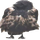

<class 'PIL.Image.Image'>
372
hooded-crow-corvus-cornix-vienna-austria_563495-842_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/hooded-crow-corvus-cornix-vienna-austria_563495-842_jpg.rf Background Removed.a89abc8206edf5b36fc76f30e041cec2.png


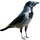

<class 'PIL.Image.Image'>
390
image22_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image22_jpeg.rf Background Removed.cf02b3bd9ecd4410eddcfff9addacfd1.png


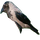

<class 'PIL.Image.Image'>
568
Rock-Pigeon-354_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-354_jpg.rf Background Removed.b9e1b07332513c6f03a46a4bb1d0c01c.png


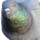

<class 'PIL.Image.Image'>
323
20231009_165322_60_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_60_jpg.rf Background Removed.f2198d093423bce521c678ad443b397c.png


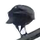

<class 'PIL.Image.Image'>
648
crow-1307-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1307-_jpg.rf Background Removed.dea14e87e76d94bfce48ff174ede2c87.png


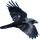

<class 'PIL.Image.Image'>
750
crow-1261-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1261-_jpg.rf Background Removed.b55c11ff9c5ae2836a13bead569c574f.png


<class 'PIL.Image.Image'>
929
ZNI67VAURL8Q_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZNI67VAURL8Q_jpg.rf Background Removed.149f01beb245e22e7c148526451a365b.png


<class 'PIL.Image.Image'>
603
9497deb350b940d2ade40ce6a3e197e9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/9497deb350b940d2ade40ce6a3e197e9_jpg.rf Background Removed.06817802edb0f6be55ae8699be08a026.png
<class 'NoneType'>
L054MMJQP98B_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L054MMJQP98B_aug_jpg.rf Background Removed.1370392066e4971080dfc4ab1de0aaa8.png


<class 'PIL.Image.Image'>
765
images-2024-01-19T222916-222_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222916-222_jpeg.rf Background Removed.460ca46b74203d78e174dcac0517e7d7.png


<class 'PIL.Image.Image'>
105
Rock-Pigeon-156_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-156_jpg.rf Background Removed.ee5022e1dabd423073a8b440f1d78aea.png


<class 'PIL.Image.Image'>
324
b53983679fcd4bb1b99858b2c0966e91_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/b53983679fcd4bb1b99858b2c0966e91_jpg.rf Background Removed.00f7c22b7e287435f9985b16fd936958.png
<class 'NoneType'>
A7D8L9O1YOQQ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/A7D8L9O1YOQQ_jpg.rf Background Removed.94f044d0ac2c921eabd69f48fa8cb7d0.png


<class 'PIL.Image.Image'>
780
000067_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000067_jpg.rf Background Removed.e692c0a29bad2d79d992fac343b51117.png


<class 'PIL.Image.Image'>
239
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-9_jpg.rf Background Removed.1334658655cee79231d676cc3cd6be1a.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
208
vienna-austria-crow-corvus-at-the-vienna-central-cemetery-2GBKCDG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/vienna-austria-crow-corvus-at-the-vienna-central-cemetery-2GBKCDG_jpg.rf Background Removed.88b8c47a037a71ac6e6aa184e9f10fdd.png


<class 'PIL.Image.Image'>
190
img600_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img600_jpeg_jpg.rf Background Removed.36bcaf6b9c98bbf20a36211a1b87c2eb.png


<class 'PIL.Image.Image'>
1181
Rock-Pigeon-271_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-271_jpg.rf Background Removed.0208ad601be6362c29daa3e059e2fbdf.png


<class 'PIL.Image.Image'>
1081
img258_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img258_jpeg_jpg.rf Background Removed.c5cda4409fc484be6ce99d47fb0fbff3.png


<class 'PIL.Image.Image'>
4
IMG_4598_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4598_JPG_jpg.rf Background Removed.750f4dc65bd5098ceae0c99bc10e667b.png


<class 'PIL.Image.Image'>
117
Rock-Pigeon-357_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-357_jpg.rf Background Removed.3b8452d09c2772f83df58b2cc053facf.png


<class 'PIL.Image.Image'>
1070
Rock-Pigeon-352_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-352_jpg.rf Background Removed.3825f305d9d2816bf222eda88d08f9ff.png


<class 'PIL.Image.Image'>
627
IMG_4573_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4573_JPG_jpg.rf Background Removed.8d383052d6f0b98820fc79c2e78216bc.png


<class 'PIL.Image.Image'>
648
images96_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images96_jpg.rf Background Removed.5daf80df31e85f83fa2c9f36dc3c527a.png


<class 'PIL.Image.Image'>
772
img112_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img112_jpeg_jpg.rf Background Removed.7b926a1d3ddb018cab2c16ad6a0286a0.png


<class 'PIL.Image.Image'>
192
crow-1375-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1375-_jpg.rf Background Removed.be0b3155cb6ecfaa900ab9b4d9fec918.png


<class 'PIL.Image.Image'>
739
Rock-Pigeon-363_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-363_jpg.rf Background Removed.f01d5efc2309c344634a809801e90533.png


<class 'PIL.Image.Image'>
131
images-35-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-35-_jpeg.rf Background Removed.a7d9fafd43e5e31262cf11ed1a3bbfe0.png


<class 'PIL.Image.Image'>
540
P6KMBLSYOW3Y_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/P6KMBLSYOW3Y_jpg.rf Background Removed.76184f42f8b81b53b7eaec5dd1dcd75a.png


<class 'PIL.Image.Image'>
763
crow-1499-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1499-_jpg.rf Background Removed.4ab074840a96736f32dc84fa1fe50985.png


<class 'PIL.Image.Image'>
190
062_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/062_jpg.rf Background Removed.022c5487491e9b8439dfe9d209be4805.png


<class 'PIL.Image.Image'>
834
image20_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image20_jpeg.rf Background Removed.4ffc5f694921e1294ad6b9b7412c321a.png


<class 'PIL.Image.Image'>
532
UP1WXWIF3AQD_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UP1WXWIF3AQD_jpg.rf Background Removed.7f4cb6c4ae085930e22ad40f1f0d9d01.png


<class 'PIL.Image.Image'>
676
Rock-Pigeon-302_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-302_jpg.rf Background Removed.8a0ecddfa89a24254ebec312fa0add34.png


<class 'PIL.Image.Image'>
333
crow-1213-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1213-_jpg.rf Background Removed.308aa97acee0f98696df839d5178c125.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the o

<class 'PIL.Image.Image'>
442
images-98-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-98-_jpeg.rf Background Removed.1355401d69c96fca18efb4fadd13313a.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
431
images-100-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-100-_jpeg.rf Background Removed.cf0130a35ffddadd5ddcef7211c63da3.png


<class 'PIL.Image.Image'>
1222
images121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images121_jpg.rf Background Removed.f5d6fa7cf51e811e33f593058ebdd8ec.png


<class 'PIL.Image.Image'>
184
QYZZMEV8BGUA_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/QYZZMEV8BGUA_jpg.rf Background Removed.a6392871fa85dd3092867147de1e686b.png


<class 'PIL.Image.Image'>
250
IMG_4609_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4609_JPG_jpg.rf Background Removed.f98167912a6e61b8e0bb88cb48ee609f.png


<class 'PIL.Image.Image'>
412
ZLKJK01I7IZR_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZLKJK01I7IZR_jpg.rf Background Removed.cee918f20cc8684df96d0e3ad11eb36b.png


<class 'PIL.Image.Image'>
942
L0VKWR51VR1H_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L0VKWR51VR1H_jpg.rf Background Removed.e93c783611d805ced13181d203f41af4.png


<class 'PIL.Image.Image'>
953
Rock-Pigeon-277_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-277_jpg.rf Background Removed.888a1069bfbde8c413e58f654d59b96c.png


<class 'PIL.Image.Image'>
219
KakaoTalk_20240615_220823841_21_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_21_jpg.rf Background Removed.e9e20a8413725c2bdf7030031ba0cb57.png


<class 'PIL.Image.Image'>
201
Columba-livia371_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia371_jpg.rf Background Removed.b17812b0c35dfc1cbe0de21ef9da7837.png


<class 'PIL.Image.Image'>
645
Rock-Pigeon-65_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-65_jpg.rf Background Removed.397e6f34054549f92adbe0df2a8b1f6e.png


<class 'PIL.Image.Image'>
856
Rock-Pigeon-324_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-324_jpg.rf Background Removed.156586de800026b289adf7e712b327ba.png


<class 'PIL.Image.Image'>
431
000033_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000033_jpg.rf Background Removed.d9058072146b33ba961259ecfc720c84.png


<class 'PIL.Image.Image'>
601
f54f2a1e9f5f4fc486078e99c3d63486_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f54f2a1e9f5f4fc486078e99c3d63486_jpg.rf Background Removed.ba8a1bf987721e7cb53695efd6b40c39.png
<class 'NoneType'>
crow-1367-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1367-_jpg.rf Background Removed.0b8ac0ff05cdb9fd03b98cfb10cc289b.png


<class 'PIL.Image.Image'>
905
Z68Q94L8IWIY_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/Z68Q94L8IWIY_aug_jpg.rf Background Removed.346aaa2624d24281dbac1ba9b9fd3e25.png


<class 'PIL.Image.Image'>
1141
Columba-livia104_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia104_jpg.rf Background Removed.bedecf4d291806a430030ddc06439311.png


<class 'PIL.Image.Image'>
1174
20240613_100420_20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_20_jpg.rf Background Removed.9c5d92a6a968bba7baf841a293ea1ec5.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
images21_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images21_jpg.rf Background Removed.aa6ff43bca9e838789a91d1d8c156524.pn

<class 'PIL.Image.Image'>
1215
061_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/061_jpg.rf Background Removed.815544ab97061296d49cac350c2ea91b.png


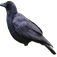

<class 'PIL.Image.Image'>
966
crow-1313-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1313-_jpg.rf Background Removed.a4d6c7da316b6d2f3e86bbdb10085443.png


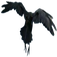

<class 'PIL.Image.Image'>
401
Rock-Pigeon-123_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-123_jpg.rf Background Removed.37b83a87bd8ff1200136d9590a0e5fb7.png


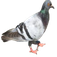

<class 'PIL.Image.Image'>
182
5I8Y6HNYX9PO_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/5I8Y6HNYX9PO_jpg.rf Background Removed.c3a52999d9342dbd5e9da1be3fca334b.png


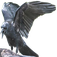

<class 'PIL.Image.Image'>
1179
0fd38a60a5ae49eda7db3a165c09bc89_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/0fd38a60a5ae49eda7db3a165c09bc89_jpg.rf Background Removed.3a82ca331813964f846b42b76a6ddc37.png
<class 'NoneType'>
Rock-Pigeon-241_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-241_jpg.rf Background Removed.103c8ac0e135625d890ffaaf07877050.png


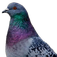

<class 'PIL.Image.Image'>
1209
Rock-Pigeon-181_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-181_jpg.rf Background Removed.b24cbcd95310158e355d6a2cea3a9cdc.png


<class 'PIL.Image.Image'>
1012
258c3b107b0f486a991e4ad0bae50f11_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/258c3b107b0f486a991e4ad0bae50f11_jpg.rf Background Removed.aeea859e8178475160fdb199dddbe7a8.png
<class 'NoneType'>
20231009_165322_300_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_300_jpg.rf Background Removed.71d38ed10e129887640c49d25804a445.png


<class 'PIL.Image.Image'>
880
images-2024-01-19T222941-047_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222941-047_jpeg.rf Background Removed.09bd674b0d83f60473328f4f502fa522.png


<class 'PIL.Image.Image'>
110
crow-1498-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1498-_jpg.rf Background Removed.0aa4d45ca4861d0a1f674c946cd6c02a.png


<class 'PIL.Image.Image'>
1214
Columba-livia76_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia76_jpg.rf Background Removed.c780f0540bce6a65c5eda7396fa1e305.png


<class 'PIL.Image.Image'>
320
Rock-Pigeon-190_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-190_jpg.rf Background Removed.2e499f4033df1849780b3a9e20d9a3cb.png


<class 'PIL.Image.Image'>
1111
images-92-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-92-_jpeg.rf Background Removed.e620906a591cfddaf091f920fa06bc19.png


<class 'PIL.Image.Image'>
5
IMG_4692_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4692_JPG_jpg.rf Background Removed.bc2a77e21f1e696d14c4114f9dea5b15.png


<class 'PIL.Image.Image'>
1083
images117_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images117_jpg.rf Background Removed.0cfcbda3bf21a613a824cb7603fb3d25.png


<class 'PIL.Image.Image'>
53
138_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/138_jpg.rf Background Removed.b9d3c97ae6fabd9046e5c5077dfa9451.png


<class 'PIL.Image.Image'>
859
a84d5f13d89e481184c04798dc12d566_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/a84d5f13d89e481184c04798dc12d566_jpg.rf Background Removed.7e04646b5714dafa15a46016bd633f59.png
<class 'NoneType'>
images-81-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-81-_jpeg.rf Background Removed.3d5d4a00953f4197832372a70ade9374.png


<class 'PIL.Image.Image'>
963
Rock-Pigeon-295_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-295_jpg.rf Background Removed.5e43804cc1e62f5c5211ae1648fa7628.png


<class 'PIL.Image.Image'>
422
Columba-livia141_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia141_jpg.rf Background Removed.2660047fe8fc9559c05968c81178c63a.png


<class 'PIL.Image.Image'>
409
156_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/156_jpg.rf Background Removed.715b7d0220ae81bd0272e5f4eb212437.png


<class 'PIL.Image.Image'>
268
crow-1366-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1366-_jpg.rf Background Removed.a4d9cfaf78fc3caa85254e99542690aa.png


<class 'PIL.Image.Image'>
872
crow-1482-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1482-_jpg.rf Background Removed.014894efd2fe033ee2d6dae924640567.png


<class 'PIL.Image.Image'>
652
1QU1OGPOS8UP_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1QU1OGPOS8UP_jpg.rf Background Removed.857373e97fb6c229bfcb0dcffc1ac6e4.png


<class 'PIL.Image.Image'>
922
000002_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000002_jpg.rf Background Removed.af1efe9fe532d4a31ae6078df7fd7437.png


<class 'PIL.Image.Image'>
410
Rock-Pigeon-294_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-294_jpg.rf Background Removed.b61bbd5a74395aabd5dc7a7683fa635a.png


<class 'PIL.Image.Image'>
798
images220_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images220_jpg.rf Background Removed.e1906de16de14f86762fe38ade43c154.png


<class 'PIL.Image.Image'>
376
Columba-livia13_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia13_jpg.rf Background Removed.412c069938accc75a2af3c027067cf61.png


<class 'PIL.Image.Image'>
322
crow-1384-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1384-_jpg.rf Background Removed.a6cb899f28bbdadd145d0e88461e577b.png


<class 'PIL.Image.Image'>
88
GFBCWYU3SS9F_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/GFBCWYU3SS9F_aug_jpg.rf Background Removed.2e5f032ebca6555de4a43c3262796435.png


<class 'PIL.Image.Image'>
60
crow-1323-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1323-_jpg.rf Background Removed.fc7e574db9f9e102382358477d543390.png


<class 'PIL.Image.Image'>
1163
Rock-Pigeon-226_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-226_jpg.rf Background Removed.69555c1013b51a4abc5b9eec80ec8000.png


<class 'PIL.Image.Image'>
201
img1003_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img1003_jpeg_jpg.rf Background Removed.8aad764dffcf47585c245511def168ee.png


<class 'PIL.Image.Image'>
715
Rock-Pigeon-204_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-204_jpg.rf Background Removed.fa7782c6b6f43a2864f1fc1c6e31630e.png


<class 'PIL.Image.Image'>
288
images-94-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-94-_jpeg.rf Background Removed.21e2cb5e2a28107d29ef6f5314198b3a.png


<class 'PIL.Image.Image'>
1037
ITG9ZSC041C4_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ITG9ZSC041C4_aug_jpg.rf Background Removed.94f8e655035f07ac9cb8402df0081304.png


<class 'PIL.Image.Image'>
414
Rock-Pigeon-276_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-276_jpg.rf Background Removed.ddc247b71f969db6c7319f975565a32d.png


<class 'PIL.Image.Image'>
1117
images-2-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2-_jpeg.rf Background Removed.4c7260f571adb24178799905e3fb3621.png


<class 'PIL.Image.Image'>
221
Columba-livia348_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia348_jpg.rf Background Removed.c9a8903f5627d6385723ee9f8249457c.png


<class 'PIL.Image.Image'>
45
P6KMBLSYOW3Y_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/P6KMBLSYOW3Y_jpg.rf Background Removed.76184f42f8b81b53b7eaec5dd1dcd75a.png


<class 'PIL.Image.Image'>
505
Rock-Pigeon-302_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-302_jpg.rf Background Removed.8a0ecddfa89a24254ebec312fa0add34.png


<class 'PIL.Image.Image'>
931
crow-1257-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1257-_jpg.rf Background Removed.66bea48b9fc382b9526580d660b44cf4.png


<class 'PIL.Image.Image'>
649
Rock-Pigeon-72_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-72_jpg.rf Background Removed.a94ad8e33ac54210c277e418be3a9d36.png


<class 'PIL.Image.Image'>
8
how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg.rf Background Removed.d40a49144d57bd1bd0e419359016a28c.png


<class 'PIL.Image.Image'>
98
crow-1360-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1360-_jpg.rf Background Removed.19b49d76db71a3ed05bfc90055325bdb.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
1053
CPABZLFCUKLB_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/CPABZLFCUKLB_jpg.rf Background Removed.960f7a93959780b8be6e7582cb54e840.png


<class 'PIL.Image.Image'>
70
crow-1227-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1227-_jpg.rf Background Removed.418f94e418d8c38b9d3054bc5a4cea00.png


<class 'PIL.Image.Image'>
165
Rock-Pigeon-252_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-252_jpg.rf Background Removed.e8d8682d65018f269fbddb9601058ede.png


<class 'PIL.Image.Image'>
270
Rock-Pigeon-291_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-291_jpg.rf Background Removed.803dee81a7673ffaf455325584d6c830.png


<class 'PIL.Image.Image'>
575
KakaoTalk_20240615_220823841_01_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_01_jpg.rf Background Removed.f7a96263f22e832661a7fc486d3e3a0c.png


<class 'PIL.Image.Image'>
991
000036_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000036_jpg.rf Background Removed.9c9c63a39853bbf12173eb6b8305bbd3.png


<class 'PIL.Image.Image'>
1052
000067_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000067_jpg.rf Background Removed.e692c0a29bad2d79d992fac343b51117.png


<class 'PIL.Image.Image'>
255
carrion-crow-corvus-corone-vienna-austria-2HYKMR4_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/carrion-crow-corvus-corone-vienna-austria-2HYKMR4_jpg.rf Background Removed.4a2790ff428d9684913051c967ac2abe.png
Rock-Pigeon-355_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-355_jpg.rf Background Removed.10ff3ad1735f99984446ef842288025a.png


<class 'PIL.Image.Image'>
1010
images-40-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-40-_jpeg.rf Background Removed.9830beecad1aa22a945dacbfdd336a94.png


<class 'PIL.Image.Image'>
435
VRVNPBQGFEPD_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/VRVNPBQGFEPD_jpg.rf Background Removed.66a35bca6d7ad70c5b384c39872fcbf9.png


<class 'PIL.Image.Image'>
541
Rock-Pigeon-254_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-254_jpg.rf Background Removed.549dcda5266d3ff58c33e6744e37ded7.png
crow-1484-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1484-_jpg.rf Background Removed.2d3c5676a3d666bd354a1ee73678e76e.png


<class 'PIL.Image.Image'>
175
061_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/061_jpg.rf Background Removed.815544ab97061296d49cac350c2ea91b.png


<class 'PIL.Image.Image'>
565
crow-1286-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1286-_jpg.rf Background Removed.90eb31c26061920207c2dedda566bf7e.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
753
Columba-livia81_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia81_jpg.rf Background Removed.612b10ba8d9975a108ec3f2259956da3.png
Rock-Pigeon-151_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-151_jpg.rf Background Removed.902e36c64291aa5404efe8eef465cd78.png


<class 'PIL.Image.Image'>
874
Rock-Pigeon-183_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-183_jpg.rf Background Removed.44064fca26ddc105a45fb3cc046ee1e5.png


<class 'PIL.Image.Image'>
541
CPABZLFCUKLB_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/CPABZLFCUKLB_jpg.rf Background Removed.960f7a93959780b8be6e7582cb54e840.png


<class 'PIL.Image.Image'>
445
Rock-Pigeon-147_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-147_jpg.rf Background Removed.b54393259fe619ce4f918ee0f237a16a.png


<class 'PIL.Image.Image'>
335
DOKJ8ZVR8C5S_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/DOKJ8ZVR8C5S_jpg.rf Background Removed.6855d1c00c830e552ea864ce71fd843f.png


<class 'PIL.Image.Image'>
279
download-4-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-4-_jpeg.rf Background Removed.feedbc008c25f5343363b5a8c91e38e9.png


<class 'PIL.Image.Image'>
27
img172_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img172_jpeg_jpg.rf Background Removed.dc015087647aa01325472cc0f6feb983.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
S8018KZI5AYN_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/S8018KZI5AYN_jpg.rf Background Removed.087ad59634c260c102f60ec5f1f4ea66.png


<class 'PIL.Image.Image'>
794
Rock-Pigeon-119_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-119_jpg.rf Background Removed.36558f293e91c103755f7e421a4dc338.png


<class 'PIL.Image.Image'>
55
crow-1270-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1270-_jpg.rf Background Removed.3989b5ac720f255665e7dede60db8ea6.png


<class 'PIL.Image.Image'>
1161
FJAZG2H0LVV7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FJAZG2H0LVV7_jpg.rf Background Removed.3782b1d3d0e1b54ce846ca90b9cf6959.png


<class 'PIL.Image.Image'>
1195
HBADZUM4FL7X_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HBADZUM4FL7X_jpg.rf Background Removed.9bd8efe7ffb0232920634e1564d8d9f9.png


<class 'PIL.Image.Image'>
78
images-35-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-35-_jpeg.rf Background Removed.a7d9fafd43e5e31262cf11ed1a3bbfe0.png


<class 'PIL.Image.Image'>
127
Rock-Pigeon-372_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-372_jpg.rf Background Removed.72ffc614ec81d44c4d1b89ac3c79910f.png


<class 'PIL.Image.Image'>
232
image17_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image17_jpeg.rf Background Removed.b74bd187009c8a738f6e7344f0a56e12.png


<class 'PIL.Image.Image'>
105
Rock-Pigeon-226_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-226_jpg.rf Background Removed.69555c1013b51a4abc5b9eec80ec8000.png


<class 'PIL.Image.Image'>
918
crow-1410-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1410-_jpg.rf Background Removed.2395ccaf44b8da4473a70f277498ce1b.png


<class 'PIL.Image.Image'>
890
crow-1277-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1277-_jpg.rf Background Removed.8a540bb1e59fcd988a6671e586269c0d.png


<class 'PIL.Image.Image'>
834
images170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images170_jpg.rf Background Removed.df8e659cceaa02357383e4e131ffc19e.png


<class 'PIL.Image.Image'>
885
ZY3ZJ4X4E2MF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZY3ZJ4X4E2MF_jpg.rf Background Removed.3e1108c1e72181544b3602bfef125b0d.png


<class 'PIL.Image.Image'>
877
crow-1201-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1201-_jpg.rf Background Removed.00c74812c9629c7bde8dc2fd08654235.png


<class 'PIL.Image.Image'>
180
images-28-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-28-_jpeg.rf Background Removed.e3c3177aea6add5418cfef95ed2dba76.png


<class 'PIL.Image.Image'>
286
crow-1245-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1245-_jpg.rf Background Removed.61e6c7eb573460ada103258593c7f978.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
181
085_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/085_jpg.rf Background Removed.cc6333883587473764f3cd8913b69052.png


<class 'PIL.Image.Image'>
77
ZIGDHKX338F3_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZIGDHKX338F3_aug_jpg.rf Background Removed.7b89955c699483bc19f31aaceb35ed12.png


<class 'PIL.Image.Image'>
707
RSMSO9GSD6HY_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/RSMSO9GSD6HY_jpg.rf Background Removed.4336196811c756aedbff89e446de230d.png


<class 'PIL.Image.Image'>
311
IMG_5697-JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/IMG_5697-JPG_jpg.rf Background Removed.54c5f98286e3c2b1fd726da3b6305a53.png


<class 'PIL.Image.Image'>
453
crow-1317-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1317-_jpg.rf Background Removed.20ae96b418e52be9225ed4bc5d058c82.png


<class 'PIL.Image.Image'>
263
crow-1266-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1266-_jpg.rf Background Removed.a6f8c8fb7393757fc3b31f5718e960b5.png


<class 'PIL.Image.Image'>
691
images-46-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-46-_jpeg.rf Background Removed.b666c758b3d32961b45962d9c1494432.png


<class 'PIL.Image.Image'>
872
crow-1237-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1237-_jpg.rf Background Removed.4829c524ea80d7745f438b299980a442.png


<class 'PIL.Image.Image'>
1236
crow-1413-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1413-_jpg.rf Background Removed.0ae5eb467913051e6097f0b920a8b1c2.png


<class 'PIL.Image.Image'>
760
Columba-livia374_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia374_jpg.rf Background Removed.cef834a376d0fb1b7c73589cbbe9035c.png


<class 'PIL.Image.Image'>
831
images-2024-01-19T222554-586_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222554-586_jpeg.rf Background Removed.1afb1f3ccbce69c663e3781ebde7ed7d.png


<class 'PIL.Image.Image'>
1040
images-2024-01-19T222333-925_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222333-925_jpeg.rf Background Removed.4e4ed04732be5791b13483af608ae43f.png


<class 'PIL.Image.Image'>
1115
032_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/032_jpg.rf Background Removed.c38d0c224a012e3e89898b7f69943041.png


<class 'PIL.Image.Image'>
275
011_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/011_jpg.rf Background Removed.951207c5af58c47ab5340c92763e07d7.png


<class 'PIL.Image.Image'>
875
000012_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000012_jpg.rf Background Removed.8f2816a7cae39020dee696e6fdc68c2f.png


<class 'PIL.Image.Image'>
283
images-90-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-90-_jpeg.rf Background Removed.4568697ff0e69909bd876f81cb55b3bb.png


<class 'PIL.Image.Image'>
95
000058_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000058_jpg.rf Background Removed.4ab4c306b2572a4cc30959c3924c599a.png


<class 'PIL.Image.Image'>
220
149_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/149_jpg.rf Background Removed.b4089fa5330cf8831aad79869cfc67b9.png


<class 'PIL.Image.Image'>
121
Columba-livia219_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia219_jpg.rf Background Removed.27b17757a3ad306a022f329a1f7e166e.png


<class 'PIL.Image.Image'>
491
images4_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images4_jpg.rf Background Removed.c03e552f0f4b3c4581f0ccec58117b2e.png


<class 'PIL.Image.Image'>
257
DOKJ8ZVR8C5S_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/DOKJ8ZVR8C5S_aug_jpg.rf Background Removed.03c1cae609230f46ced2bf0b93f1b048.png


<class 'PIL.Image.Image'>
209
20231009_165322_80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_80_jpg.rf Background Removed.97dcfbefb5bc87648e93bf656014c24b.png


<class 'PIL.Image.Image'>
990
crow-1304-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1304-_jpg.rf Background Removed.04d0c6c0bb8dfe21717237cdfd29aea1.png


<class 'PIL.Image.Image'>
525
crow-1408-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1408-_jpg.rf Background Removed.ca2928c77d2352ecfcee581827c33ae8.png


<class 'PIL.Image.Image'>
743
crow-1407-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1407-_jpg.rf Background Removed.6dc8d7ff3c50dab7c4f648e34465bb11.png


<class 'PIL.Image.Image'>
315
IMG_4632_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4632_JPG_jpg.rf Background Removed.e0d11e72cfb83ba308e67e5b6d48e7fa.png


<class 'PIL.Image.Image'>
22
images228_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images228_jpg.rf Background Removed.de439aa988a096e8e9ad7de0d860e6d7.png


<class 'PIL.Image.Image'>
1099
crow-1434-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1434-_jpg.rf Background Removed.51d9777d6348ce9c4adbaa32ece08b98.png


<class 'PIL.Image.Image'>
1039
crow-1367-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1367-_jpg.rf Background Removed.0b8ac0ff05cdb9fd03b98cfb10cc289b.png


<class 'PIL.Image.Image'>
782
crow-1420-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1420-_jpg.rf Background Removed.f6f65065d19b0ec2ce1f3e99bd396ebc.png


<class 'PIL.Image.Image'>
1237
Rock-Pigeon-252_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-252_jpg.rf Background Removed.e8d8682d65018f269fbddb9601058ede.png


<class 'PIL.Image.Image'>
951
AQQBEOY98R2X_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/AQQBEOY98R2X_aug_jpg.rf Background Removed.11a7cc9bde99b85d628666601450df5b.png


<class 'PIL.Image.Image'>
191
6f7bd44adee44d95a49fd2a665caddf9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/6f7bd44adee44d95a49fd2a665caddf9_jpg.rf Background Removed.3acc8d0484a0e463b2fe0f817ada4a7e.png
<class 'NoneType'>
crow-1330-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1330-_jpg.rf Background Removed.4c5a7794981080b3fd3ed1699d4cde81.png


<class 'PIL.Image.Image'>
476
Rock-Pigeon-42_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-42_jpg.rf Background Removed.9b9ce850fd5aebaaa8c559c45dbca43b.png


<class 'PIL.Image.Image'>
589
crow-1215-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1215-_jpg.rf Background Removed.941da8e5d2c613db9f03e739c2544f33.png


<class 'PIL.Image.Image'>
660
Columba-livia152_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia152_jpg.rf Background Removed.56f0669c50739e3650213770db74dde1.png


<class 'PIL.Image.Image'>
142
Rock-Pigeon-275_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-275_jpg.rf Background Removed.c79318ea19aeee3907c9071e2a3b137a.png


<class 'PIL.Image.Image'>
697
images20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images20_jpg.rf Background Removed.7631c24039eb70c808f264c65176247a.png


<class 'PIL.Image.Image'>
855
Rock-Pigeon-263_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-263_jpg.rf Background Removed.b44163732f45ece2c2e69d6457aa4f4a.png


<class 'PIL.Image.Image'>
868
Rock-Pigeon-82_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-82_jpg.rf Background Removed.f95f67dd2f1866d14cb98cb0b07a5387.png


<class 'PIL.Image.Image'>
51
16H2OCX2YRF1_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/16H2OCX2YRF1_aug_jpg.rf Background Removed.15fbd682fc34e69f593c2722006b568b.png


<class 'PIL.Image.Image'>
458
crow-1220-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1220-_jpg.rf Background Removed.656cceb46a983ee6fdd85788870ec5a5.png


<class 'PIL.Image.Image'>
651
crow-1373-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1373-_jpg.rf Background Removed.fa528477aa45d6f2eee3ab50e42805a2.png


<class 'PIL.Image.Image'>
46
crow-1472-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1472-_jpg.rf Background Removed.4526432135ac4789c6bacfd88189affd.png


<class 'PIL.Image.Image'>
106
images-82-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-82-_jpeg.rf Background Removed.116bbcc2844ee62ecb0fd428c089c599.png


<class 'PIL.Image.Image'>
265
img230_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img230_jpeg_jpg.rf Background Removed.10fb14234721f6cb8a5e7d2d9b7e7dca.png


<class 'PIL.Image.Image'>
506
Columba-livia119_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia119_jpg.rf Background Removed.f9326befe48478d744323f4a60d9c5ec.png


<class 'PIL.Image.Image'>
1235
crow-1289-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1289-_jpg.rf Background Removed.b6fbbb7d9faa4c2301f55be9b369a2d4.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
391
Rock-Pigeon-83_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-83_jpg.rf Background Removed.2b08c2c1f75ce2ca8ec02de5266c0dd1.png


<class 'PIL.Image.Image'>
486
000036_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000036_jpg.rf Background Removed.9c9c63a39853bbf12173eb6b8305bbd3.png


<class 'PIL.Image.Image'>
356
crow-1317-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1317-_jpg.rf Background Removed.20ae96b418e52be9225ed4bc5d058c82.png


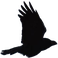

<class 'PIL.Image.Image'>
290
IMG_4695_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4695_JPG_jpg.rf Background Removed.0bf393cc48fdec731bad71f0b5264777.png


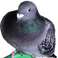

<class 'PIL.Image.Image'>
1150
Rock-Pigeon-142_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-142_jpg.rf Background Removed.28f097a36513a9de856f2087d18816ba.png


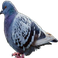

<class 'PIL.Image.Image'>
479
93FKTKYFIME8_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/93FKTKYFIME8_jpg.rf Background Removed.d92c98f7a0a2b2e769a9be1b2a28f6a6.png


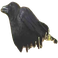

<class 'PIL.Image.Image'>
379
b770f1cae0f342849d6aa3924507d20b_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/b770f1cae0f342849d6aa3924507d20b_jpg.rf Background Removed.9f3b4f474132f4940b950d55ee08ffa5.png
<class 'NoneType'>
Rock-Pigeon-40_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-40_jpg.rf Background Removed.cd407ba8cc913aa59cdd975757dad80c.png


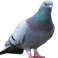

<class 'PIL.Image.Image'>
142
KZDSRIAB8IV1_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KZDSRIAB8IV1_aug_jpg.rf Background Removed.2c887852a59d73de9fcbf12684ba0b71.png


<class 'PIL.Image.Image'>
1118
P9DKNVSX8YGJ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/P9DKNVSX8YGJ_jpg.rf Background Removed.66fbcef0cdab2bc88fc54031f1c8342d.png


<class 'PIL.Image.Image'>
360
072_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/072_jpg.rf Background Removed.7d27cb2a26e19affcbdea3bd3558aafa.png


<class 'PIL.Image.Image'>
896
IMG_4573_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4573_JPG_jpg.rf Background Removed.8d383052d6f0b98820fc79c2e78216bc.png


<class 'PIL.Image.Image'>
374
images-2024-01-19T222337-894_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222337-894_jpeg.rf Background Removed.c0d8e00cd1b693f5e4a49782776a366d.png


<class 'PIL.Image.Image'>
1120
138_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/138_jpg.rf Background Removed.b9d3c97ae6fabd9046e5c5077dfa9451.png


<class 'PIL.Image.Image'>
1157
images-20-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-20-_jpeg.rf Background Removed.ad5b1c740f1e1e9477874902b1afe7bb.png


<class 'PIL.Image.Image'>
1160
000028_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000028_jpg.rf Background Removed.3b81906280afd4e77d481b330647e244.png


<class 'PIL.Image.Image'>
848
crow-1344-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1344-_jpg.rf Background Removed.ff233c3e9d6d3039fc54afefb9d5df29.png


<class 'PIL.Image.Image'>
947
QSDO4XE5LRXF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/QSDO4XE5LRXF_jpg.rf Background Removed.82ff4edfe9f21017b0a0d37aed655ce5.png


<class 'PIL.Image.Image'>
844
Columba-livia170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia170_jpg.rf Background Removed.ff386881e853b8051c0884dcc57d6bad.png


<class 'PIL.Image.Image'>
509
images246_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images246_jpg.rf Background Removed.7051ebcdce4fd933ebc5490257e5b6a0.png


<class 'PIL.Image.Image'>
574
f1db3116d31c4b57bdad10e834c6d119_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f1db3116d31c4b57bdad10e834c6d119_jpg.rf Background Removed.e0ef8dcf1470053484d9b1d4b0a3c9f2.png
<class 'NoneType'>
Rock-Pigeon-57_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-57_jpg.rf Background Removed.a4a0bd0745acc797c981d0cdf382b4a9.png


<class 'PIL.Image.Image'>
1096
images-26-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-26-_jpeg.rf Background Removed.8d663e7853915dec73a15cfe4f32fa96.png


<class 'PIL.Image.Image'>
1000
images131_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images131_jpg.rf Background Removed.2756605627f0d48d71d5c9c58e5b06ac.png


<class 'PIL.Image.Image'>
578
images223_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images223_jpg.rf Background Removed.1f6ff28d507a08addc9ee660a8460e28.png


<class 'PIL.Image.Image'>
932
crow-1463-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1463-_jpg.rf Background Removed.7dc1fcbb21103e3813047bbb792f9f83.png


<class 'PIL.Image.Image'>
711
20230517_122629_120_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20230517_122629_120_jpg.rf Background Removed.a2cac6b56d6fba48593e0b88163a176f.png


<class 'PIL.Image.Image'>
73
Rock-Pigeon-55_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-55_jpg.rf Background Removed.b9de071955982cc582b764da894f446e.png


<class 'PIL.Image.Image'>
1243
crow-1266-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1266-_jpg.rf Background Removed.a6f8c8fb7393757fc3b31f5718e960b5.png


<class 'PIL.Image.Image'>
840
images228_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images228_jpg.rf Background Removed.de439aa988a096e8e9ad7de0d860e6d7.png


<class 'PIL.Image.Image'>
59
images125_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images125_jpg.rf Background Removed.d64ffeb85548e21cdb84e3f812633f3b.png


<class 'PIL.Image.Image'>
1055
crow-1379-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1379-_jpg.rf Background Removed.de0fd8e2cfa5993a4770bdc5417841ce.png


<class 'PIL.Image.Image'>
1212
Columba-livia104_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia104_jpg.rf Background Removed.bedecf4d291806a430030ddc06439311.png


<class 'PIL.Image.Image'>
23
images-2024-01-19T222916-222_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222916-222_jpeg.rf Background Removed.460ca46b74203d78e174dcac0517e7d7.png


<class 'PIL.Image.Image'>
220
c2d08b7c7c4f49a1a79937c26f8743eb_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/c2d08b7c7c4f49a1a79937c26f8743eb_jpg.rf Background Removed.e87044b666d2f4cb5916831f32d3608d.png
<class 'NoneType'>
images-68-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-68-_jpeg.rf Background Removed.3e7a8a8a01cc1b9ab0a0ab5dd650d697.png


<class 'PIL.Image.Image'>
993
crow-1253-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1253-_jpg.rf Background Removed.7332e954614051fc5e140a7c143da219.png


<class 'PIL.Image.Image'>
1058
000023_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000023_jpg.rf Background Removed.a38ffae6b37d67b4d9e6cafc270acf05.png


<class 'PIL.Image.Image'>
442
crow-1235-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1235-_jpg.rf Background Removed.47ac1a7b6cbc3fafe0febac94eaa63a0.png


<class 'PIL.Image.Image'>
287
crow-1376-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1376-_jpg.rf Background Removed.cd252e834eb2e6964583ce16d93790a6.png


<class 'PIL.Image.Image'>
938
Columba-livia71_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia71_jpg.rf Background Removed.6140c6424bf9ef5cba2558da533ba357.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest boundi

<class 'PIL.Image.Image'>
739
000042_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000042_jpg.rf Background Removed.f21834bf6859592f9d59f928a280c5a0.png


<class 'PIL.Image.Image'>
730
download-5-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-5-_jpeg.rf Background Removed.d6dd80802106efa60704b09dc0d803d1.png


<class 'PIL.Image.Image'>
700
YRY5IUUGGC5B_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_jpg.rf Background Removed.40d07bee3d8c87bcecd0a5ec5d05e182.png


<class 'PIL.Image.Image'>
846
img432_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img432_jpg.rf Background Removed.2bda1204d6e603d6c8ab89fe0fd03083.png


<class 'PIL.Image.Image'>
54
000009_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000009_jpg.rf Background Removed.2db5af152027c1942a6b800127280bf7.png


<class 'PIL.Image.Image'>
1132
Rock-Pigeon-88_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-88_jpg.rf Background Removed.8a0f1a5329cfdffca06815d151850270.png


<class 'PIL.Image.Image'>
1272
172_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/172_jpg.rf Background Removed.b1f8d6d0d4cf4519a0f3a4d7ca98811c.png


<class 'PIL.Image.Image'>
322
Rock-Pigeon-72_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-72_jpg.rf Background Removed.a94ad8e33ac54210c277e418be3a9d36.png


<class 'PIL.Image.Image'>
1201
1QU1OGPOS8UP_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1QU1OGPOS8UP_jpg.rf Background Removed.857373e97fb6c229bfcb0dcffc1ac6e4.png


<class 'PIL.Image.Image'>
588
Rock-Pigeon-293_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-293_jpg.rf Background Removed.d2241953a0b30e76d3feac44baedf465.png


<class 'PIL.Image.Image'>
87
Rock-Pigeon-132_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-132_jpg.rf Background Removed.5504205771679d0e8c55a80bddfdd30e.png


<class 'PIL.Image.Image'>
721
Rock-Pigeon-66_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-66_jpg.rf Background Removed.97f6548c797e1bab716e97148ced2b7b.png


<class 'PIL.Image.Image'>
943
img326_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img326_jpeg_jpg.rf Background Removed.04483d17abd464aa904f88c0cb2b2204.png


<class 'PIL.Image.Image'>
769
6JFIHLEGLBTY_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/6JFIHLEGLBTY_jpg.rf Background Removed.b5b220cec22fa4af7ee34ead03810e78.png


<class 'PIL.Image.Image'>
1132
crow-1374-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1374-_jpg.rf Background Removed.dc4229d38772f1bf155a73c31d83cdb5.png


<class 'PIL.Image.Image'>
110
Rock-Pigeon-151_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-151_jpg.rf Background Removed.902e36c64291aa5404efe8eef465cd78.png


<class 'PIL.Image.Image'>
849
img313_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img313_jpeg_jpg.rf Background Removed.6a1697137b9c54c045a45959631d8d35.png


<class 'PIL.Image.Image'>
505
FWUYW6FGIFQA_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FWUYW6FGIFQA_jpg.rf Background Removed.985d8efdf758dc2d51cc8855f22fe5e7.png


<class 'PIL.Image.Image'>
174
carrion-crow-corvus-corone-sitting-260nw-2160030909_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/carrion-crow-corvus-corone-sitting-260nw-2160030909_jpg.rf Background Removed.2b278425f542f5b8d5424c1c8a716228.png


<class 'PIL.Image.Image'>
262
ZY3ZJ4X4E2MF_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZY3ZJ4X4E2MF_aug_jpg.rf Background Removed.f684d5926a50d887aad4db514f91713f.png


<class 'PIL.Image.Image'>
827
image23_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image23_jpeg.rf Background Removed.e0f12307da29e07b170d3ba807e82260.png


<class 'PIL.Image.Image'>
908
img425_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img425_jpeg_jpg.rf Background Removed.f07f44ab5b20e7b12c016de2f839f085.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
crow-1208-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1208-_jpg.rf Background Removed.c952903d630ba444bbb98a7baf5e1494.png
the opaci

<class 'PIL.Image.Image'>
1162
460536b0c5184eacad6693b3f40b74c6_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/460536b0c5184eacad6693b3f40b74c6_jpg.rf Background Removed.59875d1a30b24998ecbc8d90b9927359.png
<class 'NoneType'>
crow-1255-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1255-_jpg.rf Background Removed.455a7e6b32a6606e7f46d82723f357f8.png


<class 'PIL.Image.Image'>
1251
Columba-livia410_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia410_jpg.rf Background Removed.5c471ea58f999d2f571afc9e17df7e1f.png


<class 'PIL.Image.Image'>
314
NVWZFDEWB8LU_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/NVWZFDEWB8LU_jpg.rf Background Removed.e0b6d3855725bb9b97469f7a86bae230.png


<class 'PIL.Image.Image'>
749
images-45-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-45-_jpeg.rf Background Removed.32e4239287fe7c7308c82bb1607bed2c.png


<class 'PIL.Image.Image'>
9
R9DR13HIXLXF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/R9DR13HIXLXF_jpg.rf Background Removed.0554b5c8c20db9785f35708b8c5c10f3.png


<class 'PIL.Image.Image'>
274
Rock-Pigeon-153_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-153_jpg.rf Background Removed.ed9416d6cbd3ca7b08457c755fa71c9d.png


<class 'PIL.Image.Image'>
333
crow-1321-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1321-_jpg.rf Background Removed.a5665d569a95e1aeffb98bbf8eff0050.png


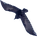

<class 'PIL.Image.Image'>
902
img583_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img583_jpeg_jpg.rf Background Removed.961795c7348266e9526c6de585d6471b.png


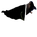

<class 'PIL.Image.Image'>
1241
Columba-livia370_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia370_jpg.rf Background Removed.820af8710adf35456fd92c3b3098ee28.png


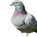

<class 'PIL.Image.Image'>
272
VZN5I8QLSC0F_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/VZN5I8QLSC0F_aug_jpg.rf Background Removed.dc0f59b302daf6cb58ec66739983395a.png


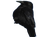

<class 'PIL.Image.Image'>
876
Columba-livia254_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia254_jpg.rf Background Removed.24d710e448c9008641e988862741380a.png


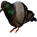

<class 'PIL.Image.Image'>
702
Columba-livia326_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia326_jpg.rf Background Removed.9d522dbbcbb51d98e45795c703ffa94e.png


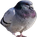

<class 'PIL.Image.Image'>
254
img18_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img18_jpg.rf Background Removed.726a09832320d6cd8c35dc9d47daa2f2.png


<class 'PIL.Image.Image'>
475
images-77-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-77-_jpeg.rf Background Removed.44b0f1b5a62008ef75b188bf62ed0b92.png


<class 'PIL.Image.Image'>
637
crow-1264-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1264-_jpg.rf Background Removed.34772929d4e8d310f33cca5db2e84890.png


<class 'PIL.Image.Image'>
813
Rock-Pigeon-134_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-134_jpg.rf Background Removed.126e1c75fc8b2ca28a022e0976cbc03a.png


<class 'PIL.Image.Image'>
816
20230517_122529_160_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20230517_122529_160_jpg.rf Background Removed.14c029cf91fab24c73cb1c3981d6e939.png


<class 'PIL.Image.Image'>
686
crow-1479-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1479-_jpg.rf Background Removed.3dbc7374c1a254d3c131096eac26bd3c.png


<class 'PIL.Image.Image'>
717
crow-1363-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1363-_jpg.rf Background Removed.e0d28ef17b8b215bc15885a2a33fbf34.png


<class 'PIL.Image.Image'>
61
Rock-Pigeon-245_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-245_jpg.rf Background Removed.c5437eec72ba9461cede1524a174345f.png


<class 'PIL.Image.Image'>
145
Columba-livia158_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia158_jpg.rf Background Removed.43e5f84cbe4976ea97000ddbe85501e8.png


<class 'PIL.Image.Image'>
195
3B47MIRUNAJX_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/3B47MIRUNAJX_jpg.rf Background Removed.cd0f16e3e539317955d844640608ace0.png


<class 'PIL.Image.Image'>
432
Columba-livia410_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia410_jpg.rf Background Removed.5c471ea58f999d2f571afc9e17df7e1f.png


<class 'PIL.Image.Image'>
611
Rock-Pigeon-38_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-38_jpg.rf Background Removed.cb223217af39ad5c933319b05d9f9e85.png


<class 'PIL.Image.Image'>
134
crow-1407-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1407-_jpg.rf Background Removed.6dc8d7ff3c50dab7c4f648e34465bb11.png


<class 'PIL.Image.Image'>
312
Rock-Pigeon-10_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-10_jpg.rf Background Removed.ee436660e689697e90734fe8913a086a.png


<class 'PIL.Image.Image'>
1265
20231009_165322_320_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_320_jpg.rf Background Removed.7a8bf8f5c12d7690a017286f7beead08.png


<class 'PIL.Image.Image'>
314
Crair-Crows_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/Crair-Crows_jpg.rf Background Removed.872f1418e97dd483c64653ec6230eba4.png


<class 'PIL.Image.Image'>
178
Rock-Pigeon-202_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-202_jpg.rf Background Removed.3025c116801d41113953ee762a92b7f3.png


<class 'PIL.Image.Image'>
874
crow-1426-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1426-_jpg.rf Background Removed.1b24e102f1c94a7c67f7f413820de219.png


<class 'PIL.Image.Image'>
262
Rock-Pigeon-9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-9_jpg.rf Background Removed.7cb1f504dc585f6975d72ba06771ca84.png


<class 'PIL.Image.Image'>
1145
Rock-Pigeon-24_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-24_jpg.rf Background Removed.c5fa7de04bce1f3b6aa771ff54d681d6.png


<class 'PIL.Image.Image'>
167
images-51-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-51-_jpeg.rf Background Removed.692e5de40b98643b1fe2717e2e0c9da9.png


<class 'PIL.Image.Image'>
297
2XHZR46ZHFZH_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2XHZR46ZHFZH_jpg.rf Background Removed.ebaa47df241610997960656e6bb9a507.png


<class 'PIL.Image.Image'>
1201
Rock-Pigeon-352_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-352_jpg.rf Background Removed.3825f305d9d2816bf222eda88d08f9ff.png


<class 'PIL.Image.Image'>
316
crow-1226-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1226-_jpg.rf Background Removed.12f5a48358825d095426db1ed196885c.png


<class 'PIL.Image.Image'>
1041
KakaoTalk_20240615_220823841_11_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_11_jpg.rf Background Removed.dfdc3c34f24ac9488ba33bf511684eef.png


<class 'PIL.Image.Image'>
1030
crow-1273-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1273-_jpg.rf Background Removed.92b15bd7f962c90f5bb2a03217e90edf.png


<class 'PIL.Image.Image'>
902
DOKJ8ZVR8C5S_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/DOKJ8ZVR8C5S_jpg.rf Background Removed.6855d1c00c830e552ea864ce71fd843f.png


<class 'PIL.Image.Image'>
782
OJ1PQNN5CEVZ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/OJ1PQNN5CEVZ_jpg.rf Background Removed.ab3f985a4f799a43bfbb08304b3511a9.png


<class 'PIL.Image.Image'>
152
AQQBEOY98R2X_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/AQQBEOY98R2X_jpg.rf Background Removed.2d838d82a6bf461a034214a3cb1d2560.png


<class 'PIL.Image.Image'>
247
img468_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img468_jpeg_jpg.rf Background Removed.290ac0860b7b2d3109cd2866c900e742.png


<class 'PIL.Image.Image'>
487
images-2024-01-19T222943-931_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222943-931_jpeg.rf Background Removed.580d187778c0abc15ef1467765a2086c.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too l

<class 'PIL.Image.Image'>
825
images143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images143_jpg.rf Background Removed.beef74bf1ddb33974435a82736fe98ec.png


<class 'PIL.Image.Image'>
349
IMG_4621_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4621_JPG_jpg.rf Background Removed.2f57cc5940ce273272030d535f993211.png


<class 'PIL.Image.Image'>
182
000063_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000063_jpg.rf Background Removed.bfefc44430b1fdcf80b7e0dcdbe65188.png


<class 'PIL.Image.Image'>
400
Rock-Pigeon-56_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-56_jpg.rf Background Removed.9ca7e6e694beb4ada5b9a2aebb1565f8.png


<class 'PIL.Image.Image'>
683
img595_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img595_jpeg_jpg.rf Background Removed.e0610c62af3881cbc1e170aa2dd0a3da.png


<class 'PIL.Image.Image'>
1160
IMG_4628_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4628_JPG_jpg.rf Background Removed.fefa87870a816fb744bd061355ea1ec9.png


<class 'PIL.Image.Image'>
935
000010_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000010_jpg.rf Background Removed.79c551cddd5dd0e54e3eb78e3540437e.png


<class 'PIL.Image.Image'>
927
crow-1219-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1219-_jpg.rf Background Removed.f6baccbbc81aa95f5f70b65d8b73dd8d.png


<class 'PIL.Image.Image'>
626
75DIYO06D4OC_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/75DIYO06D4OC_jpg.rf Background Removed.ded927ad414905d72a246da1cd473e23.png


<class 'PIL.Image.Image'>
324
Columba-livia257_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia257_jpg.rf Background Removed.e25b5d6167b2f0ba30becb4b999aba56.png


<class 'PIL.Image.Image'>
55
000027_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000027_jpg.rf Background Removed.3940ff46d28c6f10f3f3678af91f746e.png


<class 'PIL.Image.Image'>
1109
Rock-Pigeon-58_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-58_jpg.rf Background Removed.ca3e660c034c93e5cf587cc29d051606.png
Rock-Pigeon-281_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-281_jpg.rf Background Removed.c5d6be682c3b37e06313b644f17123f2.png


<class 'PIL.Image.Image'>
437
093_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/093_jpg.rf Background Removed.746054245c7fe019b0274aca3b7b6665.png


<class 'PIL.Image.Image'>
843
image5_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image5_jpeg.rf Background Removed.4679f9a8eef3065fe5a915f8968fc54c.png


<class 'PIL.Image.Image'>
627
PLEHGNPM0P1E_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PLEHGNPM0P1E_jpg.rf Background Removed.e92660128a07d19219a9cadac3ebb9b7.png
crow-1330-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1330-_jpg.rf Background Removed.4c5a7794981080b3fd3ed1699d4cde81.png


<class 'PIL.Image.Image'>
1051
Rock-Pigeon-130_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-130_jpg.rf Background Removed.69c8d9ed9c8fc6c37b8757d6ffb15c65.png


<class 'PIL.Image.Image'>
223
images150_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images150_jpg.rf Background Removed.92c88a50324a935b1750d8b95fdb72b3.png


<class 'PIL.Image.Image'>
67
images-89-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-89-_jpeg.rf Background Removed.0f503802cefc6f1b2100508d6abeb72e.png
143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/143_jpg.rf Background Removed.d4629aa675eb1f4e252757e293c648ad.png


<class 'PIL.Image.Image'>
830
images-52-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-52-_jpeg.rf Background Removed.36c300804efec5ad45c1c42887e50e8e.png


<class 'PIL.Image.Image'>
233
Columba-livia263_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia263_jpg.rf Background Removed.eeeceb0295792b8b24d4b12c2ba86770.png


<class 'PIL.Image.Image'>
1174
Rock-Pigeon-86_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-86_jpg.rf Background Removed.cc8f1bb755e5705d8f4c0358755b1628.png


<class 'PIL.Image.Image'>
1104
Columba-livia80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia80_jpg.rf Background Removed.59659a620865126b12c05b7e4d932e7c.png


<class 'PIL.Image.Image'>
378
Rock-Pigeon-322_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-322_jpg.rf Background Removed.096f4b1c1108e1d58b186d787251329b.png


<class 'PIL.Image.Image'>
556
Rock-Pigeon-71_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-71_jpg.rf Background Removed.c021a295c57ab632382f1d91af885719.png


<class 'PIL.Image.Image'>
1031
image3_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image3_jpeg.rf Background Removed.7278fac3c5d1100a6b634c7d8705a5a5.png


<class 'PIL.Image.Image'>
10
Rock-Pigeon-266_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-266_jpg.rf Background Removed.3484fb00897f33f105d2ee0465a737a6.png


<class 'PIL.Image.Image'>
9
Rock-Pigeon-283_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-283_jpg.rf Background Removed.9ff7f9db971bbbecb5518f206872d38a.png


<class 'PIL.Image.Image'>
133
images87_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images87_jpg.rf Background Removed.6702ff08210eedec3b3f55ef647db59c.png


<class 'PIL.Image.Image'>
1014
wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg.rf Background Removed.b529dcac67681d50a70ad21a36010701.png


<class 'PIL.Image.Image'>
612
crow-1204-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1204-_jpg.rf Background Removed.11597464c2272db287f280dd2723c41b.png


<class 'PIL.Image.Image'>
418
Rock-Pigeon-72_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-72_jpg.rf Background Removed.a94ad8e33ac54210c277e418be3a9d36.png


<class 'PIL.Image.Image'>
789
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-12_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-12_jpg.rf Background Removed.65dc20613e294b85308c50d34311229b.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
211
000082_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000082_jpg.rf Background Removed.c2b6a3b95818cf53512358f3c5f72712.png


<class 'PIL.Image.Image'>
85
Columba-livia5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia5_jpg.rf Background Removed.f7c7565e7245f0db7f0ce7b5994426d9.png


<class 'PIL.Image.Image'>
284
Columba-livia394_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia394_jpg.rf Background Removed.540f74fa6300cbd984d26be07e3af611.png


<class 'PIL.Image.Image'>
1041
106_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/106_jpg.rf Background Removed.0f65d3327183580397562aba943727db.png


<class 'PIL.Image.Image'>
665
Rock-Pigeon-156_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-156_jpg.rf Background Removed.ee5022e1dabd423073a8b440f1d78aea.png


<class 'PIL.Image.Image'>
1024
000005_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000005_jpg.rf Background Removed.0f34b868fc986ee85f80af1052196a17.png


<class 'PIL.Image.Image'>
180
images-2024-01-19T222941-047_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222941-047_jpeg.rf Background Removed.09bd674b0d83f60473328f4f502fa522.png


<class 'PIL.Image.Image'>
237
GU7A5RH6A8Q9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/GU7A5RH6A8Q9_jpg.rf Background Removed.21767aa7c9bd3fdf0dd4add8e8d33aa7.png


<class 'PIL.Image.Image'>
383
crow-1203-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1203-_jpg.rf Background Removed.d6cccec3352cdfdfdd223b618b1b10b7.png


<class 'PIL.Image.Image'>
759
images154_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images154_jpg.rf Background Removed.9d6dc89428a58788246e21ec00ef3c4f.png


<class 'PIL.Image.Image'>
473
crow-1292-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1292-_jpg.rf Background Removed.2dfaec88ef79ab7bc729023dbd05834a.png


<class 'PIL.Image.Image'>
23
download-5-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-5-_jpeg.rf Background Removed.d6dd80802106efa60704b09dc0d803d1.png


<class 'PIL.Image.Image'>
277
000080_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000080_jpg.rf Background Removed.d126dd5df63fdf3ffa84163cfe7a2b63.png


<class 'PIL.Image.Image'>
1166
IMG_4625_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4625_JPG_jpg.rf Background Removed.a729a6637c37ef0d4d73826de6032c50.png


<class 'PIL.Image.Image'>
513
Rock-Pigeon-77_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-77_jpg.rf Background Removed.f1d13e48eec45bac459552ceefb53e4c.png


<class 'PIL.Image.Image'>
396
IMG_4773_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4773_JPG_jpg.rf Background Removed.db51bc974af139f75d57b86522532ee9.png


<class 'PIL.Image.Image'>
1000
000030_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000030_jpg.rf Background Removed.d54e74c6daaea56205e15d2ffbd02110.png


<class 'PIL.Image.Image'>
271
Columba-livia111_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia111_jpg.rf Background Removed.bebf837652d13bd824c8b7aa1df5a74c.png


<class 'PIL.Image.Image'>
887
Columba-livia167_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia167_jpg.rf Background Removed.f8d0a671d395565122ade04fa92eb185.png


<class 'PIL.Image.Image'>
1204
images248_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images248_jpg.rf Background Removed.84de49655f7754c4e64e708a5ad70a63.png


<class 'PIL.Image.Image'>
748
Rock-Pigeon-221_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-221_jpg.rf Background Removed.6bbb245eeb0a4c64c3f7b4ff18838d1e.png


<class 'PIL.Image.Image'>
164
Rock-Pigeon-161_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-161_jpeg_jpg.rf Background Removed.fd33b690aca739d452ea436d96b2d23b.png


<class 'PIL.Image.Image'>
279
BYTWWJ9SAFJL_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BYTWWJ9SAFJL_aug_jpg.rf Background Removed.c5034d6b403f57fd0ecb95938f5eae53.png


<class 'PIL.Image.Image'>
1012
Rock-Pigeon-24_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-24_jpg.rf Background Removed.c5fa7de04bce1f3b6aa771ff54d681d6.png


<class 'PIL.Image.Image'>
298
crow-1362-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1362-_jpg.rf Background Removed.c9b71edee6ba7082f362010b3277075e.png


<class 'PIL.Image.Image'>
19
Rock-Pigeon-227_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-227_jpg.rf Background Removed.093795131fa65312d9b59c0c48491a1f.png


<class 'PIL.Image.Image'>
498
FSOH5BIYRPNN_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FSOH5BIYRPNN_aug_jpg.rf Background Removed.4cfcebbab5ede3657fcf9c065e0f48b1.png


<class 'PIL.Image.Image'>
991
IMG_4653_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4653_JPG_jpg.rf Background Removed.c1bc4050918a6104e1562cde3f794036.png


<class 'PIL.Image.Image'>
866
Rock-Pigeon-369_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-369_jpg.rf Background Removed.f032fcc449d301956b33a82a619dfe5c.png


<class 'PIL.Image.Image'>
508
Rock-Pigeon-20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-20_jpg.rf Background Removed.314e437e0df2b40df98303cdbba247f9.png


<class 'PIL.Image.Image'>
1101
053_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/053_jpg.rf Background Removed.21503e897e8a71b355dc15342ef8a74a.png


<class 'PIL.Image.Image'>
901
Columba-livia107_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia107_jpg.rf Background Removed.4c3ae2334e23897dbd90d2976185fcca.png


<class 'PIL.Image.Image'>
916
20240613_100420_200_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_200_jpg.rf Background Removed.df75a592e77baf98c5795d05551bce48.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
img152_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img152_jpeg_jpg.rf Background Removed.53326240a3a842934b6fc0d12a95

<class 'PIL.Image.Image'>
811
8AQSXL85UI0V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/8AQSXL85UI0V_jpg.rf Background Removed.6d78c84736b6d4502e256f77e21c3fde.png


<class 'PIL.Image.Image'>
629
143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/143_jpg.rf Background Removed.d4629aa675eb1f4e252757e293c648ad.png


<class 'PIL.Image.Image'>
921
crow-1330-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1330-_jpg.rf Background Removed.4c5a7794981080b3fd3ed1699d4cde81.png


<class 'PIL.Image.Image'>
6
Rock-Pigeon-100_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-100_jpg.rf Background Removed.3cd76e62ba9d5af7d0f5c1f4b26f3122.png


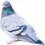

<class 'PIL.Image.Image'>
487
20231009_165322_160_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_160_jpg.rf Background Removed.d9df1329d9571c06bcafaf6195d139c2.png


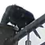

<class 'PIL.Image.Image'>
1012
img163_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img163_jpg.rf Background Removed.6bd9a742bbc22e1bafbc27818b26f956.png


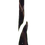

<class 'PIL.Image.Image'>
766
Rock-Pigeon-7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-7_jpg.rf Background Removed.9e1c3a4ce5461ddd9fe173bc8de197ee.png


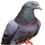

<class 'PIL.Image.Image'>
1080
image9_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image9_jpeg.rf Background Removed.d6128375e1ba554dbcc87da3fa61fd20.png


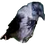

<class 'PIL.Image.Image'>
796
crow-1499-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1499-_jpg.rf Background Removed.4ab074840a96736f32dc84fa1fe50985.png


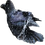

<class 'PIL.Image.Image'>
1023
crow-1474-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1474-_jpg.rf Background Removed.66ebd6262762390dc5abd7b85341d1c6.png


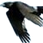

<class 'PIL.Image.Image'>
563
2IUVUGK8X1TW_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2IUVUGK8X1TW_aug_jpg.rf Background Removed.3d7be3c6043330f6c713733fa6ca79c1.png


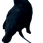

<class 'PIL.Image.Image'>
329
crow-1210-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1210-_jpg.rf Background Removed.7c0924b7188e223a36bf756bbcc48c4a.png
the opacity is too little for the largest bounding box


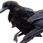

<class 'PIL.Image.Image'>
1006
Rock-Pigeon-253_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-253_jpg.rf Background Removed.05ee47948aebd263d5d25223bda53762.png


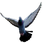

<class 'PIL.Image.Image'>
931
IMG_4740_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4740_JPG_jpg.rf Background Removed.e8c1d12be105fd0a89b58b283349adcb.png


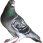

<class 'PIL.Image.Image'>
593
20240613_084127_40_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_084127_40_jpg.rf Background Removed.158c6a4db1d7c2f9d4b5e2b0d5732990.png


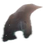

<class 'PIL.Image.Image'>
944
077_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/077_jpg.rf Background Removed.3be6bf4a7bc9f1f99dfb4911a66b2048.png


<class 'PIL.Image.Image'>
692
images244_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images244_jpg.rf Background Removed.7f6c1b303eab083125fa2e7f71a66e8f.png


<class 'PIL.Image.Image'>
590
crow-1424-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1424-_jpg.rf Background Removed.a1cf3758d8de662f2ff19daf8ceb9f95.png


<class 'PIL.Image.Image'>
634
images-17-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-17-_jpeg.rf Background Removed.6711e7d27a2c73648955f56a8b90ac1a.png


<class 'PIL.Image.Image'>
40
Rock-Pigeon-194_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-194_jpg.rf Background Removed.1c92085fe2f9863345de54817cc17fde.png


<class 'PIL.Image.Image'>
218
Rock-Pigeon-201_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-201_jpg.rf Background Removed.ccdf6751e0b994014b2f912bc55d9073.png


<class 'PIL.Image.Image'>
579
xoQlR_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/xoQlR_jpg.rf Background Removed.f6703af0cb9155e0a4845023d9e50e30.png


<class 'PIL.Image.Image'>
537
images-72-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-72-_jpeg.rf Background Removed.e41a4489af4bfa4a730df1dbf928c107.png


<class 'PIL.Image.Image'>
228
crow-1311-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1311-_jpg.rf Background Removed.a2b68df147d0ee61821301165a73e0b8.png


<class 'PIL.Image.Image'>
893
image16_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image16_jpeg.rf Background Removed.95257eaaf4becc8f7fe77d69876f7634.png


<class 'PIL.Image.Image'>
771
img189_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img189_jpeg_jpg.rf Background Removed.04d919647954de34a6d6527db7f2472a.png


<class 'PIL.Image.Image'>
621
Rock-Pigeon-141_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-141_jpg.rf Background Removed.511ef1cd11865eb689f16ec79eaa842d.png


<class 'PIL.Image.Image'>
731
crow-1245-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1245-_jpg.rf Background Removed.61e6c7eb573460ada103258593c7f978.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
197
images-67-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-67-_jpeg.rf Background Removed.788842c4f8da7468436479e39971440c.png


<class 'PIL.Image.Image'>
82
N6U3PG88FSPB_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N6U3PG88FSPB_jpg.rf Background Removed.3af9be575456b6cf544c0d1a0f135f4f.png


<class 'PIL.Image.Image'>
853
EK110NFAWDK6_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EK110NFAWDK6_aug_jpg.rf Background Removed.8e8014d1b45e0bbe9b35ca36e6a474ca.png


<class 'PIL.Image.Image'>
72
20231009_165322_80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_80_jpg.rf Background Removed.97dcfbefb5bc87648e93bf656014c24b.png


<class 'PIL.Image.Image'>
571
crow-1348-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1348-_jpg.rf Background Removed.90bb8c1353f78a9b01715558e68d9177.png


<class 'PIL.Image.Image'>
1017
crow-1437-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1437-_jpg.rf Background Removed.d46a3793597228ab2dd8eede832c219f.png


<class 'PIL.Image.Image'>
446
Rock-Pigeon-310_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-310_jpg.rf Background Removed.d59fab8be18d15c410e46b46a112b4bc.png


<class 'PIL.Image.Image'>
112
Columba-livia326_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia326_jpg.rf Background Removed.9d522dbbcbb51d98e45795c703ffa94e.png


<class 'PIL.Image.Image'>
201
20231009_165322_180_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_180_jpg.rf Background Removed.e55e8c869b2ce92ee1a62f8fbe04d6c9.png


<class 'PIL.Image.Image'>
859
IMG_4630_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4630_JPG_jpg.rf Background Removed.963cc55a1cbd45b62f76e26699e25c65.png


<class 'PIL.Image.Image'>
357
Rock-Pigeon-360_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-360_jpg.rf Background Removed.c5e8d795ac4943b0795cba75fb4cfa9b.png


<class 'PIL.Image.Image'>
131
EBUVL9JAKFHI_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EBUVL9JAKFHI_aug_jpg.rf Background Removed.7f22b3d1d61c63418b19377723c676ad.png


<class 'PIL.Image.Image'>
104
images86_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images86_jpg.rf Background Removed.c45d1316b708a622ab49f5c407ecc17b.png


<class 'PIL.Image.Image'>
783
Columba-livia76_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia76_jpg.rf Background Removed.c780f0540bce6a65c5eda7396fa1e305.png


<class 'PIL.Image.Image'>
449
Rock-Pigeon-92_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-92_jpg.rf Background Removed.d97499ee6ab43673ecb3783b46388e5a.png


<class 'PIL.Image.Image'>
627
images-2024-01-19T222832-534_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222832-534_jpeg.rf Background Removed.a1276724f5accd2fe5c21ba2a6b9570c.png


<class 'PIL.Image.Image'>
1119
000019_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000019_jpg.rf Background Removed.b6cdb79fb280c70f55c5b3bcbae7ab75.png


<class 'PIL.Image.Image'>
1178
images-37-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-37-_jpeg.rf Background Removed.5d6f7618efd55f076aebfc3d0ba369aa.png


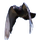

<class 'PIL.Image.Image'>
590
crow-1352-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1352-_jpg.rf Background Removed.a849732a0e9a55cbc2f1c5a6016f4888.png


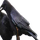

<class 'PIL.Image.Image'>
523
Rock-Pigeon-48_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-48_jpg.rf Background Removed.317f7332b6e72ed71fd80225d3e415c2.png


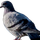

<class 'PIL.Image.Image'>
71
20240613_100420_80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_80_jpg.rf Background Removed.05f2984a7ca053ec2afb7d9edc2fbaec.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
crow-1452-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1452-_jpg.rf Background Removed.43cb233e33e92b63d1c9857c9ba25da1.

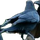

<class 'PIL.Image.Image'>
1098
6AU1S60SOUW6_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/6AU1S60SOUW6_jpg.rf Background Removed.f4789964e7095e744eabcbd65f1a3e59.png


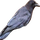

<class 'PIL.Image.Image'>
850
Rock-Pigeon-154_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-154_jpg.rf Background Removed.720da08f23e858bea6dfd81156e7aeb4.png


<class 'PIL.Image.Image'>
50
images-62-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-62-_jpeg.rf Background Removed.da7c2db15fc97c3a1fde6243948f8338.png


<class 'PIL.Image.Image'>
258
crow-1211-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1211-_jpg.rf Background Removed.8fa86e0cf58c1a0d01f8498f6c743e32.png


<class 'PIL.Image.Image'>
202
IMG_4626_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4626_JPG_jpg.rf Background Removed.e1f6a305caae0cfb9779181222e0338c.png


<class 'PIL.Image.Image'>
789
GFBCWYU3SS9F_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/GFBCWYU3SS9F_jpg.rf Background Removed.b4309a7d62992fafe211864f7e3a269a.png


<class 'PIL.Image.Image'>
994
images-88-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-88-_jpeg.rf Background Removed.68bf083959623ccd2df8cf1c081bd1e2.png


<class 'PIL.Image.Image'>
1202
QSDO4XE5LRXF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/QSDO4XE5LRXF_jpg.rf Background Removed.82ff4edfe9f21017b0a0d37aed655ce5.png


<class 'PIL.Image.Image'>
1157
image24_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image24_jpeg.rf Background Removed.f51ab241f1fd463df1a33f5af4cbf5c5.png


<class 'PIL.Image.Image'>
492
070_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/070_jpg.rf Background Removed.4a905c545cd4dd80f1bab91849ce9000.png


<class 'PIL.Image.Image'>
879
Rock-Pigeon-352_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-352_jpg.rf Background Removed.3825f305d9d2816bf222eda88d08f9ff.png


<class 'PIL.Image.Image'>
980
crow-1201-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1201-_jpg.rf Background Removed.00c74812c9629c7bde8dc2fd08654235.png


<class 'PIL.Image.Image'>
1207
crow-1456-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1456-_jpg.rf Background Removed.272d5a304abf9d8e27ca8d029e6f5351.png


<class 'PIL.Image.Image'>
417
000049_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000049_jpg.rf Background Removed.19003ee4c316357c00c88d3b9ab11bf9.png


<class 'PIL.Image.Image'>
1091
Rock-Pigeon-248_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-248_jpg.rf Background Removed.7add695ac8e74cf65b7b444678ce8c1e.png


<class 'PIL.Image.Image'>
272
KakaoTalk_20240615_220823841_11_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_11_jpg.rf Background Removed.dfdc3c34f24ac9488ba33bf511684eef.png


<class 'PIL.Image.Image'>
1183
Rock-Pigeon-365_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-365_jpg.rf Background Removed.8fcb160263a13df3f5b7190b7d426b3d.png


<class 'PIL.Image.Image'>
652
crow-1415-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1415-_jpg.rf Background Removed.afcc52c027e87b885bef767259832c7a.png


<class 'PIL.Image.Image'>
341
000079_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000079_jpg.rf Background Removed.597b5a830b0b3226f5b30a6676a09e7c.png


<class 'PIL.Image.Image'>
217
images121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images121_jpg.rf Background Removed.f5d6fa7cf51e811e33f593058ebdd8ec.png


<class 'PIL.Image.Image'>
344
Rock-Pigeon-303_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-303_jpg.rf Background Removed.42774d82712d1486cfe942e2524c098d.png


<class 'PIL.Image.Image'>
927
L03UGBJ1X94M_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L03UGBJ1X94M_jpg.rf Background Removed.f655cee7fac67fd1d755f2945b51e422.png


<class 'PIL.Image.Image'>
339
crow-1407-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1407-_jpg.rf Background Removed.6dc8d7ff3c50dab7c4f648e34465bb11.png


<class 'PIL.Image.Image'>
1152
S8018KZI5AYN_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/S8018KZI5AYN_jpg.rf Background Removed.087ad59634c260c102f60ec5f1f4ea66.png


<class 'PIL.Image.Image'>
1031
Rock-Pigeon-170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-170_jpg.rf Background Removed.8e0b8da30bce8c1358cb8119695ab00c.png


<class 'PIL.Image.Image'>
723
images125_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images125_jpg.rf Background Removed.d64ffeb85548e21cdb84e3f812633f3b.png


<class 'PIL.Image.Image'>
25
images-30-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-30-_jpeg.rf Background Removed.f056c60896a08f4d5f365b858e4abeb2.png


<class 'PIL.Image.Image'>
1001
Rock-Pigeon-26_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-26_jpg.rf Background Removed.32ed2416db5444f23bec7e2c61ee22cc.png


<class 'PIL.Image.Image'>
206
Rock-Pigeon-120_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-120_jpg.rf Background Removed.bed7b920df0ca5473f6a67952608ecd2.png


<class 'PIL.Image.Image'>
846
MB66L889ROUK_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/MB66L889ROUK_jpg.rf Background Removed.eb7d97c263893f54e2fd20d33b65e8d1.png


<class 'PIL.Image.Image'>
1141
Columba-livia167_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia167_jpg.rf Background Removed.f8d0a671d395565122ade04fa92eb185.png


<class 'PIL.Image.Image'>
1151
01597684_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/01597684_jpg.rf Background Removed.05bd6315cd2f7b9be5836c5bccb05170.png


<class 'PIL.Image.Image'>
1137
Rock-Pigeon-287_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-287_jpg.rf Background Removed.691dcc2399fb55b60cf5542a5a247b1c.png


<class 'PIL.Image.Image'>
454
011_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/011_jpg.rf Background Removed.951207c5af58c47ab5340c92763e07d7.png


<class 'PIL.Image.Image'>
495
Rock-Pigeon-342_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-342_jpg.rf Background Removed.6d6b4fcdd808931492677bfc3f892710.png


<class 'PIL.Image.Image'>
989
images142_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images142_jpg.rf Background Removed.558f0f4b57c77730a9e9dd475fb7de06.png


<class 'PIL.Image.Image'>
749
b7b1d344ece549d1b00cfc7686c287df_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/b7b1d344ece549d1b00cfc7686c287df_jpg.rf Background Removed.1ee9c488670a3d2b0e06512230f9de99.png
<class 'NoneType'>
crow-1437-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1437-_jpg.rf Background Removed.d46a3793597228ab2dd8eede832c219f.png


<class 'PIL.Image.Image'>
1118
VCFXCPTO0GTX_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/VCFXCPTO0GTX_jpg.rf Background Removed.0ac08b934cf3d7caa0dc7397e4539f2c.png


<class 'PIL.Image.Image'>
52
crow-1417-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1417-_jpg.rf Background Removed.fe8f5a0e1e2654ab47372d209895fad8.png


<class 'PIL.Image.Image'>
350
Rock-Pigeon-1_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-1_jpg.rf Background Removed.8c0e61e072610035a205d418a30c6dc3.png


<class 'PIL.Image.Image'>
1027
crow-1227-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1227-_jpg.rf Background Removed.418f94e418d8c38b9d3054bc5a4cea00.png


<class 'PIL.Image.Image'>
481
Columba-livia5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia5_jpg.rf Background Removed.f7c7565e7245f0db7f0ce7b5994426d9.png


<class 'PIL.Image.Image'>
656
img481_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img481_jpg.rf Background Removed.21a4cb2d235a8e9e19eb2ef121b20d96.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity i

<class 'PIL.Image.Image'>
707
TU2CHM5DWWS1_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/TU2CHM5DWWS1_jpg.rf Background Removed.ffcff441e9f17ca26d8b5853c6abccd2.png


<class 'PIL.Image.Image'>
1110
image26_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image26_jpeg.rf Background Removed.43fc5f89580f50ffd72e90423fd17878.png


<class 'PIL.Image.Image'>
787
img189_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img189_jpeg_jpg.rf Background Removed.04d919647954de34a6d6527db7f2472a.png


<class 'PIL.Image.Image'>
839
2KEOC8C0OTWC_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2KEOC8C0OTWC_aug_jpg.rf Background Removed.e9e252893f7f8e5a954e45db17191609.png


<class 'PIL.Image.Image'>
308
crow-1355-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1355-_jpg.rf Background Removed.7a3f0eb2c0ade709c1009501fc9170ad.png


<class 'PIL.Image.Image'>
1131
crow-1382-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1382-_jpg.rf Background Removed.d038e0af6420a9c768ebb47aa42aaf5c.png


<class 'PIL.Image.Image'>
1141
000081_png
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000081_png.rf Background Removed.e8af3b1588f938b9de16d056e5a14f7b.png


<class 'PIL.Image.Image'>
663
Rock-Pigeon-233_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-233_jpg.rf Background Removed.3200f8e651326b9e0ceb9b1dfce6e3bb.png


<class 'PIL.Image.Image'>
310
crow-1364-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1364-_jpg.rf Background Removed.6d7a9f56245b14a44c54f0ce2229627d.png


<class 'PIL.Image.Image'>
102
images254_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images254_jpg.rf Background Removed.61d704ec98eb460abdea2332230956b3.png


<class 'PIL.Image.Image'>
150
images275_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images275_jpg.rf Background Removed.444bc7c14ff5a8c01850cebc366f3938.png


<class 'PIL.Image.Image'>
1107
20240613_084127_60_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_084127_60_jpg.rf Background Removed.008761ad890f0660c92897f7ef817794.png


<class 'PIL.Image.Image'>
495
IMG_4651_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4651_JPG_jpg.rf Background Removed.8d688059b9d3409981a141a780bb537b.png


<class 'PIL.Image.Image'>
1056
Z68Q94L8IWIY_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/Z68Q94L8IWIY_jpg.rf Background Removed.658b6c32143770e9063e98005e32681d.png


<class 'PIL.Image.Image'>
841
20230517_122629_140_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20230517_122629_140_jpg.rf Background Removed.bde63fe55aa35ce700b7a17eb4012c02.png


<class 'PIL.Image.Image'>
592
000072_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000072_jpg.rf Background Removed.fa592303e07a38c9fbf9b260d1d7e63b.png


<class 'PIL.Image.Image'>
934
images143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images143_jpg.rf Background Removed.beef74bf1ddb33974435a82736fe98ec.png


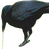

<class 'PIL.Image.Image'>
692
crow-1231-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1231-_jpg.rf Background Removed.1054147312131fb4e0089f472db85973.png


<class 'PIL.Image.Image'>
574
Columba-livia105_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia105_jpg.rf Background Removed.49ef7d7aba0b291720750a820d7335c4.png


<class 'PIL.Image.Image'>
95
Columba-livia63_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia63_jpg.rf Background Removed.afeb148c944db517711cfe5e1138b6ed.png


<class 'PIL.Image.Image'>
186
8AQSXL85UI0V_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/8AQSXL85UI0V_aug_jpg.rf Background Removed.6405086fd9c08c46ea0677d142360905.png


<class 'PIL.Image.Image'>
386
img326_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img326_jpeg_jpg.rf Background Removed.04483d17abd464aa904f88c0cb2b2204.png


<class 'PIL.Image.Image'>
79
images131_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images131_jpg.rf Background Removed.2756605627f0d48d71d5c9c58e5b06ac.png


<class 'PIL.Image.Image'>
705
images-2024-01-19T222518-415_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222518-415_jpeg.rf Background Removed.9d7c3a8911a53080cfd7557a07755abd.png


<class 'PIL.Image.Image'>
779
img230_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img230_jpeg_jpg.rf Background Removed.10fb14234721f6cb8a5e7d2d9b7e7dca.png


<class 'PIL.Image.Image'>
828
crow-1413-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1413-_jpg.rf Background Removed.0ae5eb467913051e6097f0b920a8b1c2.png


<class 'PIL.Image.Image'>
39
000087_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000087_jpg.rf Background Removed.4d8128a8e9c0dc4317d0ff633fb998e0.png


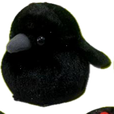

<class 'PIL.Image.Image'>
1067
Rock-Pigeon-108_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-108_jpg.rf Background Removed.57128b51f17bef62221b62016c34f53d.png


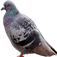

<class 'PIL.Image.Image'>
548
images157_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images157_jpg.rf Background Removed.1f5cf4a4af48abb1718c5da00592d08b.png


<class 'PIL.Image.Image'>
1123
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg.rf Background Removed.09cbccb41b1203a140f00ba19e34146f.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
502
Columba-livia99_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia99_jpg.rf Background Removed.6f6150df01d19692bb1001e3b6c16e3f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
crow-1402-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1402-_jpg.rf Background Removed.ebdada3f0bc97b92e8961bcca06d173f.png

<class 'PIL.Image.Image'>
72
bb2bb0c54cd543f194e694bea91f7da5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/bb2bb0c54cd543f194e694bea91f7da5_jpg.rf Background Removed.df0ee3d29c182a611905a956b77a325d.png
<class 'NoneType'>
064_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/064_jpg.rf Background Removed.0712a8813e8e19c63b79c7227d7cb4f8.png


<class 'PIL.Image.Image'>
564
Rock-Pigeon-101_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-101_jpg.rf Background Removed.423cd67674b451014b1527acf738ef65.png


<class 'PIL.Image.Image'>
969
IMG_4587_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4587_JPG_jpg.rf Background Removed.0865e958ff0c117806260a4912d112b5.png


<class 'PIL.Image.Image'>
1233
Rock-Pigeon-197_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-197_jpg.rf Background Removed.eb272e80a64ac48fe4ce648d1135d3b4.png


<class 'PIL.Image.Image'>
314
Columba-livia101_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia101_jpg.rf Background Removed.6e543c2230a0922aecf9c5952dc0192f.png


<class 'PIL.Image.Image'>
722
images80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images80_jpg.rf Background Removed.439fdf3d529d6b0005c0d57a9031230d.png


<class 'PIL.Image.Image'>
513
images-2024-01-19T222936-771_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222936-771_jpeg.rf Background Removed.750202de151036d03b38841e168f9806.png


<class 'PIL.Image.Image'>
997
images268_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images268_jpg.rf Background Removed.dcd5c494fc491d33d362fc1aa160d275.png


<class 'PIL.Image.Image'>
1123
crow-1348-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1348-_jpg.rf Background Removed.90bb8c1353f78a9b01715558e68d9177.png


<class 'PIL.Image.Image'>
439
N8QUYLCS7IBP_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N8QUYLCS7IBP_aug_jpg.rf Background Removed.38c76ee2fa6a93f22c568279310d38c8.png


<class 'PIL.Image.Image'>
770
ITG9ZSC041C4_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ITG9ZSC041C4_aug_jpg.rf Background Removed.94f8e655035f07ac9cb8402df0081304.png


<class 'PIL.Image.Image'>
495
Rock-Pigeon-319_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-319_jpg.rf Background Removed.040a3ef0476da0d5db5164417e2ec491.png


<class 'PIL.Image.Image'>
1068
JF0I6ZTBRGNY_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/JF0I6ZTBRGNY_jpg.rf Background Removed.57767f786f671d4e924b00adc3274a12.png


<class 'PIL.Image.Image'>
1247
IMG_4588_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4588_JPG_jpg.rf Background Removed.b9a97a4469fb02048fe2c7435215b6fe.png


<class 'PIL.Image.Image'>
265
WT3GPRTJE25V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/WT3GPRTJE25V_jpg.rf Background Removed.49440c3744df3e05375c6b76cc18a172.png


<class 'PIL.Image.Image'>
27
000081_png
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000081_png.rf Background Removed.e8af3b1588f938b9de16d056e5a14f7b.png


<class 'PIL.Image.Image'>
1066
images-28-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-28-_jpeg.rf Background Removed.e3c3177aea6add5418cfef95ed2dba76.png


<class 'PIL.Image.Image'>
694
54F8WG1X9RRO_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/54F8WG1X9RRO_aug_jpg.rf Background Removed.e9caf242b3a733d8e2c5c5ccc6d03e04.png


<class 'PIL.Image.Image'>
81
Rock-Pigeon-41_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-41_jpg.rf Background Removed.1f5711b857ea3f6eb2085187e188f208.png


<class 'PIL.Image.Image'>
782
ba77ca69602740cb90a088807fb1cd88_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/ba77ca69602740cb90a088807fb1cd88_jpg.rf Background Removed.2fc7a9ab30cf50458f294f244de7bd0b.png
<class 'NoneType'>
f8ba4b11bd614b379dc2806b71438fcf_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f8ba4b11bd614b379dc2806b71438fcf_jpg.rf Background Removed.3c73d6b252f7fa8c2e458b70e2bf68cf.png
<class 'NoneType'>
Columba-livia114_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia114_jpg.rf Background Removed.c632568a2ed10aa7a9c92b151e444dda.png


<class 'PIL.Image.Image'>
692
2XHZR46ZHFZH_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2XHZR46ZHFZH_aug_jpg.rf Background Removed.f4670a3ef89b2005595154d605389160.png


<class 'PIL.Image.Image'>
447
N3EOGY4AAO4V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N3EOGY4AAO4V_jpg.rf Background Removed.0f6e8c1eae364044ea2e9526fb12269f.png


<class 'PIL.Image.Image'>
101
083_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/083_jpg.rf Background Removed.92b5ebd49f903619679af471d9d65c04.png


<class 'PIL.Image.Image'>
931
crow-1329-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1329-_jpg.rf Background Removed.c9210152120747f2b4bbbcacf8182d87.png


<class 'PIL.Image.Image'>
293
110_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/110_jpg.rf Background Removed.1f95b06cff9db1edc168cf9587d5296f.png


<class 'PIL.Image.Image'>
503
118_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/118_jpg.rf Background Removed.6609d13194fa7894ce6f3df3cce5b776.png


<class 'PIL.Image.Image'>
1150
121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/121_jpg.rf Background Removed.58d74db657876f9c6036f21d0d3a7e45.png


<class 'PIL.Image.Image'>
933
images258_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images258_jpg.rf Background Removed.c77ae19b187b67cbbcb7ce7be56d8832.png


<class 'PIL.Image.Image'>
48
077_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/077_jpg.rf Background Removed.3be6bf4a7bc9f1f99dfb4911a66b2048.png
images19_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images19_jpg.rf Background Removed.b6588fa16117118ecfbdee159866853a.png


<class 'PIL.Image.Image'>
601
Rock-Pigeon-330_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-330_jpg.rf Background Removed.3a6120bcc5b27f0af24e0dbe320a36fd.png


<class 'PIL.Image.Image'>
671
crow-1328-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1328-_jpg.rf Background Removed.20c2cbc42fb66ffce80fdf25d9fbae67.png


<class 'PIL.Image.Image'>
829
093_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/093_jpg.rf Background Removed.746054245c7fe019b0274aca3b7b6665.png
EBUVL9JAKFHI_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EBUVL9JAKFHI_aug_jpg.rf Background Removed.7f22b3d1d61c63418b19377723c676ad.png


<class 'PIL.Image.Image'>
459
images-90-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-90-_jpeg.rf Background Removed.4568697ff0e69909bd876f81cb55b3bb.png


<class 'PIL.Image.Image'>
1019
Rock-Pigeon-272_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-272_jpg.rf Background Removed.1f6887e5c99431c5e93e75c707e7ff5b.png


<class 'PIL.Image.Image'>
521
download-5-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-5-_jpeg.rf Background Removed.d6dd80802106efa60704b09dc0d803d1.png
D0PYD4YOK3HN_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/D0PYD4YOK3HN_jpg.rf Background Removed.ce0e68c5bf4b3d3befa44e389572cdc0.png


<class 'PIL.Image.Image'>
422
crow-1295-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1295-_jpg.rf Background Removed.3e3740155426800d524ea2c4d0127aa9.png


<class 'PIL.Image.Image'>
470
20230517_122629_120_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20230517_122629_120_jpg.rf Background Removed.a2cac6b56d6fba48593e0b88163a176f.png


<class 'PIL.Image.Image'>
596
download-11-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-11-_jpeg.rf Background Removed.ac6f3b8e935a5ef2d76628c25504562e.png
img583_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img583_jpeg_jpg.rf Background Removed.961795c7348266e9526c6de585d6471b.png


<class 'PIL.Image.Image'>
596
Rock-Pigeon-126_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-126_jpg.rf Background Removed.db38e3a566c6f7b7fc70a78a2ae81bb2.png


<class 'PIL.Image.Image'>
355
145_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/145_jpg.rf Background Removed.6baa5530ad0fb41709a462c27b3c294e.png


<class 'PIL.Image.Image'>
851
download-12-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-12-_jpeg.rf Background Removed.04826fda6b1dda8a74d79f6f6461d48d.png
Rock-Pigeon-369_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-369_jpg.rf Background Removed.f032fcc449d301956b33a82a619dfe5c.png


<class 'PIL.Image.Image'>
869
Rock-Pigeon-101_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-101_jpg.rf Background Removed.423cd67674b451014b1527acf738ef65.png


<class 'PIL.Image.Image'>
888
images-2024-01-19T222554-586_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222554-586_jpeg.rf Background Removed.1afb1f3ccbce69c663e3781ebde7ed7d.png


<class 'PIL.Image.Image'>
10
000079_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000079_jpg.rf Background Removed.597b5a830b0b3226f5b30a6676a09e7c.png
crow-1315-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1315-_jpg.rf Background Removed.7c440fce6284ebda214e52e805c244d0.png


<class 'PIL.Image.Image'>
130
Rock-Pigeon-369_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-369_jpg.rf Background Removed.f032fcc449d301956b33a82a619dfe5c.png


<class 'PIL.Image.Image'>
195
images113_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images113_jpg.rf Background Removed.56221acd8c8d9ac490d233041a1168d8.png


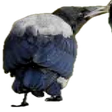

<class 'PIL.Image.Image'>
1150
Rock-Pigeon-211_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-211_jpg.rf Background Removed.d63213b17be0663f91530f54a18fbf40.png


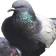

<class 'PIL.Image.Image'>
317
14CHS00251o_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/14CHS00251o_jpg.rf Background Removed.f36e7bbb16f3cd88c557bbfdac912d10.png


<class 'PIL.Image.Image'>
452
Columba-livia63_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia63_jpg.rf Background Removed.afeb148c944db517711cfe5e1138b6ed.png


<class 'PIL.Image.Image'>
190
Rock-Pigeon-243_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-243_jpg.rf Background Removed.35a22db56437c0d8c8b06fb07daa9080.png


<class 'PIL.Image.Image'>
989
000068_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000068_jpg.rf Background Removed.ee5b4788fbf32c17277f28746040ce51.png


<class 'PIL.Image.Image'>
740
img326_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img326_jpeg_jpg.rf Background Removed.04483d17abd464aa904f88c0cb2b2204.png


<class 'PIL.Image.Image'>
1018
Rock-Pigeon-325_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-325_jpg.rf Background Removed.81ce3c25c543852d0878226c2d68e4de.png


<class 'PIL.Image.Image'>
591
images-2024-01-19T222857-474_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222857-474_jpeg.rf Background Removed.f1bd5f13c397ac9fb81f37fd5946c52f.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
1063
Rock-Pigeon-83_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-83_jpg.rf Background Removed.2b08c2c1f75ce2ca8ec02de5266c0dd1.png


<class 'PIL.Image.Image'>
61
images-2024-01-19T222943-931_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222943-931_jpeg.rf Background Removed.580d187778c0abc15ef1467765a2086c.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too li

<class 'PIL.Image.Image'>
187
img17_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img17_jpg.rf Background Removed.de630583acd2d109c524ef33e28dcadd.png


<class 'PIL.Image.Image'>
736
Rock-Pigeon-293_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-293_jpg.rf Background Removed.d2241953a0b30e76d3feac44baedf465.png


<class 'PIL.Image.Image'>
694
img118_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img118_jpeg_jpg.rf Background Removed.b2b6af26551dc90ee2d6a6e85ef79363.png


<class 'PIL.Image.Image'>
632
Rock-Pigeon-353_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-353_jpg.rf Background Removed.cc88c4cb2d08f754d2410c1384ed69bc.png


<class 'PIL.Image.Image'>
1137
2IUVUGK8X1TW_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2IUVUGK8X1TW_aug_jpg.rf Background Removed.3d7be3c6043330f6c713733fa6ca79c1.png


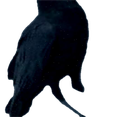

<class 'PIL.Image.Image'>
995
images229_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images229_jpg.rf Background Removed.86e51e167b35886bf254feb253199beb.png


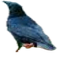

<class 'PIL.Image.Image'>
216
images30_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images30_jpg.rf Background Removed.e6838510267fd033958f1c0782a92343.png


<class 'PIL.Image.Image'>
1049
H0U4WSMWL09A_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/H0U4WSMWL09A_aug_jpg.rf Background Removed.8499db4dea5868021e75fcb7017698d9.png


<class 'PIL.Image.Image'>
1119
images-77-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-77-_jpeg.rf Background Removed.44b0f1b5a62008ef75b188bf62ed0b92.png


<class 'PIL.Image.Image'>
782
bb8aaa706e25409fa469c92d44a950bb_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/bb8aaa706e25409fa469c92d44a950bb_jpg.rf Background Removed.e6bb6131db35a27bb222e614ea3d02d2.png
<class 'NoneType'>
Columba-livia351_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia351_jpg.rf Background Removed.30828bb262af79996660caf79ae2b098.png


<class 'PIL.Image.Image'>
849
hddcrwc218_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/hddcrwc218_jpg.rf Background Removed.e01aa492562b98658c59843560253327.png


<class 'PIL.Image.Image'>
818
Columba-livia287_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia287_jpg.rf Background Removed.aa748d1aa9efdf0516531822767efc91.png


<class 'PIL.Image.Image'>
114
crow-1347-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1347-_jpg.rf Background Removed.56b91d435ebadc2a694a660bdcbdf36f.png


<class 'PIL.Image.Image'>
395
crow-1251-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1251-_jpg.rf Background Removed.046ced37216cf9c3ca5b32ea6ac6ab16.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
50
Columba-livia121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia121_jpg.rf Background Removed.db77afd55e64856b221091800081550a.png


<class 'PIL.Image.Image'>
983
Rock-Pigeon-245_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-245_jpg.rf Background Removed.c5437eec72ba9461cede1524a174345f.png


<class 'PIL.Image.Image'>
1156
L03UGBJ1X94M_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L03UGBJ1X94M_jpg.rf Background Removed.f655cee7fac67fd1d755f2945b51e422.png


<class 'PIL.Image.Image'>
857
crow-1217-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1217-_jpg.rf Background Removed.f2daaa65d32a43f2d65516b365f4f404.png


<class 'PIL.Image.Image'>
1244
images95_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images95_jpg.rf Background Removed.9a790983461483c641813c286456c435.png


<class 'PIL.Image.Image'>
706
crow-1473-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1473-_jpg.rf Background Removed.e54aff38cf8ef28b0eaa0c33944caca7.png


<class 'PIL.Image.Image'>
834
Rock-Pigeon-305_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-305_jpg.rf Background Removed.ad37379a3f1f54755f627b4544c1335c.png


<class 'PIL.Image.Image'>
1251
image_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image_jpeg.rf Background Removed.097ded0c1bb89330ce6d7e1d08a98751.png


<class 'PIL.Image.Image'>
1097
images121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images121_jpg.rf Background Removed.f5d6fa7cf51e811e33f593058ebdd8ec.png


<class 'PIL.Image.Image'>
1260
images-17-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-17-_jpeg.rf Background Removed.6711e7d27a2c73648955f56a8b90ac1a.png


<class 'PIL.Image.Image'>
752
105_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/105_jpg.rf Background Removed.c183932b6351410a646d2b63f6e93801.png


<class 'PIL.Image.Image'>
402
TJDS04VESHCI_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/TJDS04VESHCI_jpg.rf Background Removed.a7a2d7c010abf6924cd17e2cc229369f.png


<class 'PIL.Image.Image'>
208
20231009_165322_220_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_220_jpg.rf Background Removed.b640e1dae393b8e1e0d67e82689b8d56.png


<class 'PIL.Image.Image'>
1043
images-32-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-32-_jpeg.rf Background Removed.94fc3d72eb2aa431cb7bcee38f80a80e.png


<class 'PIL.Image.Image'>
602
Rock-Pigeon-170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-170_jpg.rf Background Removed.8e0b8da30bce8c1358cb8119695ab00c.png


<class 'PIL.Image.Image'>
661
Rock-Pigeon-340_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-340_jpg.rf Background Removed.88aa0d48443b2d680ddad2440ad1d8a3.png


<class 'PIL.Image.Image'>
786
ANORLFOX4NNG_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ANORLFOX4NNG_aug_jpg.rf Background Removed.ae9453c608279e9d6b5fe432b0c3bcb2.png


<class 'PIL.Image.Image'>
759
G9TUEAFG13XJ_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/G9TUEAFG13XJ_aug_jpg.rf Background Removed.8fff8987e94c72059a928360b36d3912.png


<class 'PIL.Image.Image'>
1043
93FKTKYFIME8_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/93FKTKYFIME8_jpg.rf Background Removed.d92c98f7a0a2b2e769a9be1b2a28f6a6.png


<class 'PIL.Image.Image'>
117
Columba-livia332_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia332_jpg.rf Background Removed.ddf081f88b01d5228e6670a2e81c0ad0.png


<class 'PIL.Image.Image'>
638
Rock-Pigeon-18_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-18_jpg.rf Background Removed.0e1d00282f2c7af300747ae1dffc2060.png


<class 'PIL.Image.Image'>
516
images-49-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-49-_jpeg.rf Background Removed.e8222711f6a531a1ad1f716788e975cd.png


<class 'PIL.Image.Image'>
747
Rock-Pigeon-7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-7_jpg.rf Background Removed.9e1c3a4ce5461ddd9fe173bc8de197ee.png


<class 'PIL.Image.Image'>
425
images166_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images166_jpg.rf Background Removed.7a6c326d350ca89e0f64133d3816c8bf.png


<class 'PIL.Image.Image'>
1273
IMG_4622_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4622_JPG_jpg.rf Background Removed.b77d5d34f6b4e49e0884dc3d647549eb.png


<class 'PIL.Image.Image'>
162
Rock-Pigeon-223_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-223_jpg.rf Background Removed.daef21d00117ecf1d6f5495d7fbd5b84.png


<class 'PIL.Image.Image'>
553
37d8cded5e93443a964e98ba6fe1df0c_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/37d8cded5e93443a964e98ba6fe1df0c_jpg.rf Background Removed.141396364111889beb888d6566d3462c.png
<class 'NoneType'>
Columba-livia37_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia37_jpg.rf Background Removed.bf899166d831cc973b73302542a96a22.png


<class 'PIL.Image.Image'>
793
c0b014113dca4cdeada6b8aaddc96dd9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/c0b014113dca4cdeada6b8aaddc96dd9_jpg.rf Background Removed.b661a3aacdf315a5a62d5bec7fb67878.png
<class 'NoneType'>
075_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/075_jpg.rf Background Removed.dd96fa37ece858e12b28226daba0601b.png


<class 'PIL.Image.Image'>
877
Rock-Pigeon-329_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-329_jpg.rf Background Removed.a8761e2fd9763d400a254d2e6ee8f5ec.png


<class 'PIL.Image.Image'>
703
Columba-livia371_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia371_jpg.rf Background Removed.b17812b0c35dfc1cbe0de21ef9da7837.png


<class 'PIL.Image.Image'>
1182
images-80-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-80-_jpeg.rf Background Removed.deff218ca76cc7c8cdf86be5b08a2de5.png


<class 'PIL.Image.Image'>
57
crow-1252-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1252-_jpg.rf Background Removed.e371b832468f85544b671e2e8547bc41.png


<class 'PIL.Image.Image'>
996
IKUJ1L7I3C1U_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/IKUJ1L7I3C1U_jpg.rf Background Removed.3931385874f006d2418f9e9a401f198e.png


<class 'PIL.Image.Image'>
151
109_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/109_jpg.rf Background Removed.6a452eed4a8d46c85229c6d8b13709c5.png


<class 'PIL.Image.Image'>
399
download-11-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-11-_jpeg.rf Background Removed.ac6f3b8e935a5ef2d76628c25504562e.png


<class 'PIL.Image.Image'>
1087
000018_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000018_jpg.rf Background Removed.a54f6e169e4460b528eb82699d67966b.png


<class 'PIL.Image.Image'>
380
Columba-livia152_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia152_jpg.rf Background Removed.56f0669c50739e3650213770db74dde1.png


<class 'PIL.Image.Image'>
105
Columba-livia171_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia171_jpg.rf Background Removed.3517c8ed4cd2f9437c5258231a6a39ab.png


<class 'PIL.Image.Image'>
979
KZDSRIAB8IV1_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KZDSRIAB8IV1_jpg.rf Background Removed.6d20a46affe2b724c8bac87428d33118.png


<class 'PIL.Image.Image'>
535
crow-1373-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1373-_jpg.rf Background Removed.fa528477aa45d6f2eee3ab50e42805a2.png


<class 'PIL.Image.Image'>
960
Columba-livia329_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia329_jpg.rf Background Removed.cc504457d9cf91be7a7fc828c40e6a06.png


<class 'PIL.Image.Image'>
182
OJ1PQNN5CEVZ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/OJ1PQNN5CEVZ_jpg.rf Background Removed.ab3f985a4f799a43bfbb08304b3511a9.png


<class 'PIL.Image.Image'>
1018
010_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/010_jpg.rf Background Removed.e6f4328d9bb186847a6b84ec331cd934.png


<class 'PIL.Image.Image'>
265
Rock-Pigeon-286_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-286_jpg.rf Background Removed.179058f1eda59d44d9559127634ef498.png


<class 'PIL.Image.Image'>
1155
crow-1476-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1476-_jpg.rf Background Removed.9687e8ccce804345204ec0c753b774a3.png


<class 'PIL.Image.Image'>
983
download-2-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-2-_jpeg.rf Background Removed.7c7daf06b8a697fbf9b903a076ec8388.png


<class 'PIL.Image.Image'>
180
Rock-Pigeon-110_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-110_jpg.rf Background Removed.2cd337d7f5abb7f21fd9ee6eaa9bc981.png


<class 'PIL.Image.Image'>
532
images9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images9_jpg.rf Background Removed.bd0e90f17997ca527a9f87009c803d52.png


<class 'PIL.Image.Image'>
564
BYTWWJ9SAFJL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BYTWWJ9SAFJL_jpg.rf Background Removed.6df5cae4826d7fe1ea82b5484b88a1ef.png


<class 'PIL.Image.Image'>
1051
hooded-crow-corvus-cornix-vienna-austria_563495-847_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/hooded-crow-corvus-cornix-vienna-austria_563495-847_jpg.rf Background Removed.b3038b37bfe943405563a839ef85eb5a.png


<class 'PIL.Image.Image'>
573
img275_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img275_jpg.rf Background Removed.74da04c283eb60e091f8fe33fb6a9524.png


<class 'PIL.Image.Image'>
175
crow-1260-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1260-_jpg.rf Background Removed.ef96dc3019f20c82ba56707407dc7ebe.png


<class 'PIL.Image.Image'>
358
022_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/022_jpg.rf Background Removed.4c5e4b6476beac4ddcca2f3898504841.png


<class 'PIL.Image.Image'>
992
IMG_4604_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4604_JPG_jpg.rf Background Removed.654aa00fa8414d36284371b99096c287.png


<class 'PIL.Image.Image'>
36
WNZKA2GKNDS0_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/WNZKA2GKNDS0_jpg.rf Background Removed.369a4e82f524fdc7637b3d000e7242b2.png


<class 'PIL.Image.Image'>
45
Columba-livia121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia121_jpg.rf Background Removed.db77afd55e64856b221091800081550a.png


<class 'PIL.Image.Image'>
876
O6SH9VY79X4Z_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/O6SH9VY79X4Z_jpg.rf Background Removed.a4c3440055cf32b63ce13acb2d802564.png


<class 'PIL.Image.Image'>
848
images83_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images83_jpg.rf Background Removed.fad45a430d735fbad4f53c7f39dcbd5b.png


<class 'PIL.Image.Image'>
74
20240613_100420_100_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_100_jpg.rf Background Removed.2b1837e5bcb2b91832ac4bcf4cee7c48.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
crow-1414-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1414-_jpg.rf Background Removed.c4905ee3a762684afa8372607072117

<class 'PIL.Image.Image'>
642
Columba-livia272_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia272_jpg.rf Background Removed.aa6a277a912adbbc1aa09c680dfc9dca.png


<class 'PIL.Image.Image'>
1056
Rock-Pigeon-324_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-324_jpg.rf Background Removed.156586de800026b289adf7e712b327ba.png


<class 'PIL.Image.Image'>
619
Rock-Pigeon-276_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-276_jpg.rf Background Removed.ddc247b71f969db6c7319f975565a32d.png


<class 'PIL.Image.Image'>
367
images163_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images163_jpg.rf Background Removed.e2fec1789aefaf3d173dba4d1b3db9ef.png


<class 'PIL.Image.Image'>
150
000083_png
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000083_png.rf Background Removed.8e13955d5dae8561c068a318511c505d.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity i

<class 'PIL.Image.Image'>
122
crow-1260-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1260-_jpg.rf Background Removed.ef96dc3019f20c82ba56707407dc7ebe.png


<class 'PIL.Image.Image'>
826
image27_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image27_jpeg.rf Background Removed.27d6b30cffeecf5d55bdd8bfc554a495.png


<class 'PIL.Image.Image'>
693
images169_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images169_jpg.rf Background Removed.71be834f52c86f55078b10b8fe1a9be0.png


<class 'PIL.Image.Image'>
882
F1L0IX5UFFFL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/F1L0IX5UFFFL_jpg.rf Background Removed.0b63b085b5179191df3d770ecd5b17e0.png


<class 'PIL.Image.Image'>
122
25324450189_29f2d111a2_b_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/25324450189_29f2d111a2_b_jpg.rf Background Removed.632acea931ed3e7518f90252d930c97f.png


<class 'PIL.Image.Image'>
965
FBYUUV9W7PT4_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FBYUUV9W7PT4_jpg.rf Background Removed.4fa0d65b087414d486069bd388d45603.png


<class 'PIL.Image.Image'>
796
images142_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images142_jpg.rf Background Removed.558f0f4b57c77730a9e9dd475fb7de06.png


<class 'PIL.Image.Image'>
715
Rock-Pigeon-144_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-144_jpg.rf Background Removed.a530689bc4305edde468d914648e7a50.png


<class 'PIL.Image.Image'>
959
FSK9C6S2090P_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FSK9C6S2090P_jpg.rf Background Removed.6023004b30b964096231a30fba201413.png


<class 'PIL.Image.Image'>
1134
KQP5OCLEBLAR_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KQP5OCLEBLAR_jpg.rf Background Removed.ec7176424995794f28e4e9db2c4b65ec.png


<class 'PIL.Image.Image'>
1041
images258_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images258_jpg.rf Background Removed.c77ae19b187b67cbbcb7ce7be56d8832.png


<class 'PIL.Image.Image'>
522
Rock-Pigeon-46_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-46_jpg.rf Background Removed.a11e7d9f9eb24dc0389cd3f60b9f8aea.png


<class 'PIL.Image.Image'>
498
wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg.rf Background Removed.b529dcac67681d50a70ad21a36010701.png


<class 'PIL.Image.Image'>
955
108_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/108_jpg.rf Background Removed.483768bce43d09810f5178b54014ac81.png


<class 'PIL.Image.Image'>
11
7d04deb39ad24110a544e5eacce61735_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/7d04deb39ad24110a544e5eacce61735_jpg.rf Background Removed.c62adb0a86f80f199c97a7cad07d4bb3.png
<class 'NoneType'>
000023_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000023_jpg.rf Background Removed.a38ffae6b37d67b4d9e6cafc270acf05.png


<class 'PIL.Image.Image'>
116
images-2024-01-19T222342-719_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222342-719_jpeg.rf Background Removed.788b7c541e7e3eb5700a1e33e912d80b.png


<class 'PIL.Image.Image'>
362
images-81-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-81-_jpeg.rf Background Removed.3d5d4a00953f4197832372a70ade9374.png


<class 'PIL.Image.Image'>
242
AUKEVN5OH02V_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/AUKEVN5OH02V_aug_jpg.rf Background Removed.c336de1f508c97cfbe7fc2d407cc9f9f.png


<class 'PIL.Image.Image'>
672
images-2024-01-19T222610-638_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222610-638_jpeg.rf Background Removed.8a1c230f11e79edb574b24cc7e85f550.png


<class 'PIL.Image.Image'>
1248
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-24_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-24_jpg.rf Background Removed.f5963a9a2172b67dea345ae53137b4fd.png
IMG_4594_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4594_JPG_jpg.rf Background Removed.ef7a98faf4073c23f69d2a8ac4c0e85c.png


<class 'PIL.Image.Image'>
213
images310_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images310_jpg.rf Background Removed.482563d71f708f59507740e6ea79e8b8.png


<class 'PIL.Image.Image'>
692
Columba-livia79_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia79_jpg.rf Background Removed.3320e569faf027bb6cf12b1e4c56e8f9.png


<class 'PIL.Image.Image'>
505
Rock-Pigeon-93_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-93_jpg.rf Background Removed.b8ca5925aa8e3b5c269db4453862bdc4.png
images-2024-01-19T222832-534_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222832-534_jpeg.rf Background Removed.a1276724f5accd2fe5c21ba2a6b9570c.png


<class 'PIL.Image.Image'>
404
Rock-Pigeon-135_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-135_jpg.rf Background Removed.bb7da92d6e90379fb8a4dd17f9e6ae61.png


<class 'PIL.Image.Image'>
315
img361_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img361_jpg.rf Background Removed.26f232689a98c970f2ae540d5b67f8bb.png


<class 'PIL.Image.Image'>
1232
Rock-Pigeon-299_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-299_jpg.rf Background Removed.6902a52601d299dd048a750b57fd66d3.png
7S4WOGBZ72RC_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/7S4WOGBZ72RC_jpg.rf Background Removed.56c6afc3ddf0feac8d546ae3fa75ade8.png


<class 'PIL.Image.Image'>
873
img361_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img361_jpg.rf Background Removed.26f232689a98c970f2ae540d5b67f8bb.png


<class 'PIL.Image.Image'>
281
Rock-Pigeon-275_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-275_jpg.rf Background Removed.c79318ea19aeee3907c9071e2a3b137a.png


<class 'PIL.Image.Image'>
191
HQY47LS6QS0I_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HQY47LS6QS0I_aug_jpg.rf Background Removed.1a25f9b1a149b77cc52fb5b223925d19.png


<class 'PIL.Image.Image'>
65
images-84-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-84-_jpeg.rf Background Removed.5588f5af95ffecbfcfae0f69e3302383.png


<class 'PIL.Image.Image'>
865
crow-1389-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1389-_jpg.rf Background Removed.00337be328ea5dec0c389acf4f98be2c.png


<class 'PIL.Image.Image'>
246
crow-1302-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1302-_jpg.rf Background Removed.5315fd3649e28dd0db20f80bd1b7fb59.png


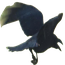

<class 'PIL.Image.Image'>
110
ZY3ZJ4X4E2MF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZY3ZJ4X4E2MF_jpg.rf Background Removed.3e1108c1e72181544b3602bfef125b0d.png


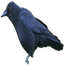

<class 'PIL.Image.Image'>
73
how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg.rf Background Removed.d40a49144d57bd1bd0e419359016a28c.png


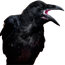

<class 'PIL.Image.Image'>
1055
Columba-livia254_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia254_jpg.rf Background Removed.24d710e448c9008641e988862741380a.png


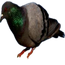

<class 'PIL.Image.Image'>
1039
images319_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images319_jpg.rf Background Removed.a120343d7fb02890ff6c9de46dc3e646.png


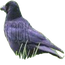

<class 'PIL.Image.Image'>
44
crow-1241-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1241-_jpg.rf Background Removed.558ad3cd615e3f5e73a176c29383d3a0.png


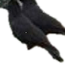

<class 'PIL.Image.Image'>
901
TJDS04VESHCI_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/TJDS04VESHCI_jpg.rf Background Removed.a7a2d7c010abf6924cd17e2cc229369f.png


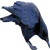

<class 'PIL.Image.Image'>
1105
20231009_165322_20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_20_jpg.rf Background Removed.b66aac516ff8352f4cc09fc081b5443e.png


<class 'PIL.Image.Image'>
145
Rock-Pigeon-44_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-44_jpg.rf Background Removed.91cbfb40ca51e38e563828d675776083.png


<class 'PIL.Image.Image'>
763
crow-1344-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1344-_jpg.rf Background Removed.ff233c3e9d6d3039fc54afefb9d5df29.png


<class 'PIL.Image.Image'>
735
000028_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000028_jpg.rf Background Removed.3b81906280afd4e77d481b330647e244.png


<class 'PIL.Image.Image'>
657
images-99-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-99-_jpeg.rf Background Removed.0cb2f64f7b68be1761caf4b3316ef94c.png


<class 'PIL.Image.Image'>
115
13289399_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/13289399_jpg.rf Background Removed.07a4fe1f42e41e197b5b136f6b0d0966.png


<class 'PIL.Image.Image'>
359
download-11-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-11-_jpeg.rf Background Removed.ac6f3b8e935a5ef2d76628c25504562e.png


<class 'PIL.Image.Image'>
365
41db2582f52b4dc497e7cc801009431b_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/41db2582f52b4dc497e7cc801009431b_jpg.rf Background Removed.2075a16bd2f6e663269b3d058c5b3d90.png
<class 'NoneType'>
ac12b5e73f30483cb8f2a0a197fd1f43_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/ac12b5e73f30483cb8f2a0a197fd1f43_jpg.rf Background Removed.eb9eb89bd1082b8c4ac1abe6bde43202.png
<class 'NoneType'>
PZKYLHAQ2AVX_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PZKYLHAQ2AVX_jpg.rf Background Removed.2d7c0df3fda994350c3f03c2abd70700.png


<class 'PIL.Image.Image'>
265
images-57-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-57-_jpeg.rf Background Removed.607ce24e1c3c41e72141ea591119b5c1.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
551
images-2024-01-19T222630-844_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222630-844_jpeg.rf Background Removed.f50610d99775c566b6988e46b85a6fe5.png


<class 'PIL.Image.Image'>
886
images-44-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-44-_jpeg.rf Background Removed.d5c378e37d7a43481e4016b1c5dafb13.png


<class 'PIL.Image.Image'>
927
crow-1396-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1396-_jpg.rf Background Removed.c964f39d43d4ceaeab97356a8c39ac5c.png


<class 'PIL.Image.Image'>
268
Rock-Pigeon-351_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-351_jpg.rf Background Removed.58ed7df55b8d3aa1eddb11a601259545.png


<class 'PIL.Image.Image'>
906
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg.rf Background Removed.09cbccb41b1203a140f00ba19e34146f.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
592
BYTWWJ9SAFJL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BYTWWJ9SAFJL_jpg.rf Background Removed.6df5cae4826d7fe1ea82b5484b88a1ef.png


<class 'PIL.Image.Image'>
1259
crow-1307-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1307-_jpg.rf Background Removed.dea14e87e76d94bfce48ff174ede2c87.png


<class 'PIL.Image.Image'>
1126
062_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/062_jpg.rf Background Removed.022c5487491e9b8439dfe9d209be4805.png


<class 'PIL.Image.Image'>
409
crow-1455-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1455-_jpg.rf Background Removed.ac43c8f14256b08fd3e798b4663dd797.png


<class 'PIL.Image.Image'>
1197
YDPJFGMOPXU8_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/YDPJFGMOPXU8_aug_jpg.rf Background Removed.61d89b8ff5114b66ee4bc6db58ae57dc.png


<class 'PIL.Image.Image'>
637
064_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/064_jpg.rf Background Removed.0712a8813e8e19c63b79c7227d7cb4f8.png


<class 'PIL.Image.Image'>
890
crow-1212-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1212-_jpg.rf Background Removed.1d9fb392a9a791a0109c210c4bcb19d5.png


<class 'PIL.Image.Image'>
816
EL3QH9UE01PK_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EL3QH9UE01PK_jpg.rf Background Removed.93580af863a331960aab43cb261b6d8f.png


<class 'PIL.Image.Image'>
700
crow-1303-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1303-_jpg.rf Background Removed.1ea47cd17ff6ed7b951492d8fa544d7f.png


<class 'PIL.Image.Image'>
1174
images117_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images117_jpg.rf Background Removed.0cfcbda3bf21a613a824cb7603fb3d25.png


<class 'PIL.Image.Image'>
119
crow-1431-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1431-_jpg.rf Background Removed.d23ae03f10df6eb11a27bec2767763a5.png


<class 'PIL.Image.Image'>
111
Columba-livia238_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia238_jpg.rf Background Removed.7ee3f2be4adb191b890b3cb8806a36de.png


<class 'PIL.Image.Image'>
235
KakaoTalk_20240615_220823841_18_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_18_jpg.rf Background Removed.575bb1ee7d609adb0e060914143106e0.png


<class 'PIL.Image.Image'>
130
20240613_100420_160_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_160_jpg.rf Background Removed.dbdaf73878cc9ab352c5f65811a8bebe.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
034_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/034_jpg.rf Background Removed.3c37767965653ee395238382b8f0a2b8.png


<class 'PIL.Image.Image'>
1004
crow-1284-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1284-_jpg.rf Background Removed.dd4a1a78af5641114718c2873592b9c9.png


<class 'PIL.Image.Image'>
1105
Columba-livia5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia5_jpg.rf Background Removed.f7c7565e7245f0db7f0ce7b5994426d9.png


<class 'PIL.Image.Image'>
7
135_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/135_jpg.rf Background Removed.1e59e7ed9a0a6611bc61f24ba6a2ae33.png


<class 'PIL.Image.Image'>
696
crow-1460-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1460-_jpg.rf Background Removed.9ef0b2829c6e1e939ebaa5c611e6b450.png


<class 'PIL.Image.Image'>
274
images-52-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-52-_jpeg.rf Background Removed.36c300804efec5ad45c1c42887e50e8e.png


<class 'PIL.Image.Image'>
25
Rock-Pigeon-244_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-244_jpg.rf Background Removed.640047748f2de83598897822151a8416.png


<class 'PIL.Image.Image'>
94
P6KMBLSYOW3Y_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/P6KMBLSYOW3Y_jpg.rf Background Removed.76184f42f8b81b53b7eaec5dd1dcd75a.png


<class 'PIL.Image.Image'>
767
crow-1299-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1299-_jpg.rf Background Removed.aabb2f7e58d85a27205a5bdf0c4d42d2.png


<class 'PIL.Image.Image'>
662
Rock-Pigeon-347_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-347_jpg.rf Background Removed.4cc0df94f7c46c1ec5b38714c37eef78.png


<class 'PIL.Image.Image'>
932
59cfb7de783ae846ec07a0d60b8fbba00a84eb69_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/59cfb7de783ae846ec07a0d60b8fbba00a84eb69_jpg.rf Background Removed.923790db38686d81334a4ca89d8cf68b.png


<class 'PIL.Image.Image'>
203
images100_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images100_jpg.rf Background Removed.4fa6d2adc60b287a3f1aa0acd1aa0ea9.png


<class 'PIL.Image.Image'>
1044
F7BNSX8ZW05M_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/F7BNSX8ZW05M_jpg.rf Background Removed.11249b19cffe33e0302ca3f3b60e8d00.png


<class 'PIL.Image.Image'>
260
img110_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img110_jpeg_jpg.rf Background Removed.8c06e444e8b23636d28b4065e6b30c85.png


<class 'PIL.Image.Image'>
877
20231009_165322_60_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_60_jpg.rf Background Removed.f2198d093423bce521c678ad443b397c.png


<class 'PIL.Image.Image'>
955
images83_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images83_jpg.rf Background Removed.fad45a430d735fbad4f53c7f39dcbd5b.png


<class 'PIL.Image.Image'>
136
1Z75WH9D74I4_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1Z75WH9D74I4_jpg.rf Background Removed.0d2a538cf3c4382da2963037f5da2d98.png


<class 'PIL.Image.Image'>
756
Rock-Pigeon-319_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-319_jpg.rf Background Removed.040a3ef0476da0d5db5164417e2ec491.png


<class 'PIL.Image.Image'>
146
1TSUFL2ISEUL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1TSUFL2ISEUL_jpg.rf Background Removed.ddf993217faa08cf58cfd28dacb20e04.png


<class 'PIL.Image.Image'>
72
14fab0149ccc4822bbf923f16d8b2f7e_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/14fab0149ccc4822bbf923f16d8b2f7e_jpg.rf Background Removed.abf9a097350c6ee0aab99f4aa5cb295d.png
<class 'NoneType'>
image5_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image5_jpeg.rf Background Removed.4679f9a8eef3065fe5a915f8968fc54c.png


<class 'PIL.Image.Image'>
567
images29_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images29_jpg.rf Background Removed.0c0cfe6493f09be37bfeb79ab47a9713.png


<class 'PIL.Image.Image'>
628
PSQFSYDO9925_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PSQFSYDO9925_jpg.rf Background Removed.6fdf09db77ae285e280233a005f8325a.png
Rock-Pigeon-300_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-300_jpg.rf Background Removed.8f328b323d42d7b9d535998fc78faa28.png


<class 'PIL.Image.Image'>
531
img18_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img18_jpg.rf Background Removed.726a09832320d6cd8c35dc9d47daa2f2.png


<class 'PIL.Image.Image'>
29
Rock-Pigeon-147_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-147_jpg.rf Background Removed.b54393259fe619ce4f918ee0f237a16a.png


<class 'PIL.Image.Image'>
675
4A8UCP0DBZBE_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/4A8UCP0DBZBE_jpg.rf Background Removed.ebfbdf91decbbc94b4ee34502e461de7.png
Rock-Pigeon-223_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-223_jpg.rf Background Removed.daef21d00117ecf1d6f5495d7fbd5b84.png


<class 'PIL.Image.Image'>
860
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg.rf Background Removed.09cbccb41b1203a140f00ba19e34146f.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
1266
crow-1296-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1296-_jpg.rf Background Removed.cf2384572fe5ddd143e242892ed89085.png


<class 'PIL.Image.Image'>
839
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-32_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-32_jpg.rf Background Removed.50bb1716aaa4fc9e08b3ed304f314f4d.png
Rock-Pigeon-358_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-358_jpg.rf Background Removed.4751e2b78bc17e9e2a71233d8ff816b5.png


<class 'PIL.Image.Image'>
740
Rock-Pigeon-256_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-256_jpg.rf Background Removed.002b4371d37de9d342faf0bc03dcb209.png


<class 'PIL.Image.Image'>
101
0LIFS3GQ4Z54_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/0LIFS3GQ4Z54_jpg.rf Background Removed.4653cf3f1ffc9363ce0198e0f39e1021.png


<class 'PIL.Image.Image'>
154
Rock-Pigeon-76_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-76_jpg.rf Background Removed.b45090184585c205acdba654f3635c20.png


<class 'PIL.Image.Image'>
624
Rock-Pigeon-322_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-322_jpg.rf Background Removed.096f4b1c1108e1d58b186d787251329b.png


<class 'PIL.Image.Image'>
1247
G5MVHVWBXBCZ_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/G5MVHVWBXBCZ_aug_jpg.rf Background Removed.bf063141ee1ee8495e654084b0ed45ca.png


<class 'PIL.Image.Image'>
447
056_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/056_jpg.rf Background Removed.57c4932d3e47ca82403c10435f730077.png


<class 'PIL.Image.Image'>
666
1TSUFL2ISEUL_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1TSUFL2ISEUL_aug_jpg.rf Background Removed.739c021ae5bea32754998dd83b293717.png


<class 'PIL.Image.Image'>
542
images-2024-01-19T222428-871_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222428-871_jpeg.rf Background Removed.bd70809dcb0f2f9f2e4946b63de94fd8.png


<class 'PIL.Image.Image'>
47
Rock-Pigeon-183_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-183_jpg.rf Background Removed.44064fca26ddc105a45fb3cc046ee1e5.png


<class 'PIL.Image.Image'>
286
Columba-livia316_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia316_jpg.rf Background Removed.d8f6cf6285ede2ad48cfe9bb06ca4d5e.png


<class 'PIL.Image.Image'>
550
Rock-Pigeon-167_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-167_jpg.rf Background Removed.36c0198522c7c88eb2655e2cb7867193.png
026_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/026_jpg.rf Background Removed.36b355c45867221c1a9c21a6b43a5612.png


<class 'PIL.Image.Image'>
1017
Rock-Pigeon-212_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-212_jpg.rf Background Removed.8b5b172a9d8af020a255c2fa6a90f72d.png


<class 'PIL.Image.Image'>
377
images306_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images306_jpg.rf Background Removed.03dfadf581ed3b8ff401fb2c55426364.png


<class 'PIL.Image.Image'>
488
7S4WOGBZ72RC_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/7S4WOGBZ72RC_aug_jpg.rf Background Removed.56a7739d853d85b044d3dcfb45d68c55.png
2be64d339ebe4795bb96a5ea0c76af69_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/2be64d339ebe4795bb96a5ea0c76af69_jpg.rf Background Removed.e596f079e3a96a981d3e6766ec9ae96a.png
<class 'NoneType'>
crow-1462-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1462-_jpg.rf Background Removed.0ddfc4c2df3a02cb0fd1434b451674fe.png


<class 'PIL.Image.Image'>
323
Rock-Pigeon-8_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-8_jpg.rf Background Removed.f2ff7cdc6bd23d1e17fdf552d73270c1.png


<class 'PIL.Image.Image'>
1078
images-79-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-79-_jpeg.rf Background Removed.8c21b9aa6cebfeb5983b113cb72d40e8.png
img604_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img604_jpeg_jpg.rf Background Removed.4ca50e95f1b12dea18474ee74bf1773e.png


<class 'PIL.Image.Image'>
190
crow-1269-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1269-_jpg.rf Background Removed.88c303f55c6a3f8094bbbae730dd16c5.png


<class 'PIL.Image.Image'>
429
20240613_100420_220_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_220_jpg.rf Background Removed.fd180124a5d2095ff6c4051a563c463e.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
Rock-Pigeon-245_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-245_jpg.rf Background Removed.c5437eec72ba9461ce

<class 'PIL.Image.Image'>
1181
crow-1420-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1420-_jpg.rf Background Removed.f6f65065d19b0ec2ce1f3e99bd396ebc.png


<class 'PIL.Image.Image'>
109
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg.rf Background Removed.09cbccb41b1203a140f00ba19e34146f.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
742
Rock-Pigeon-356_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-356_jpg.rf Background Removed.8d1d3645d4cbdb1a599fecfe3154f13a.png


<class 'PIL.Image.Image'>
1270
crow-1360-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1360-_jpg.rf Background Removed.19b49d76db71a3ed05bfc90055325bdb.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
371
Rock-Pigeon-101_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-101_jpg.rf Background Removed.423cd67674b451014b1527acf738ef65.png


<class 'PIL.Image.Image'>
1261
Rock-Pigeon-172_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-172_jpg.rf Background Removed.1462318da649e27c648f751449c3c1dd.png


<class 'PIL.Image.Image'>
1059
Columba-livia141_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia141_jpg.rf Background Removed.2660047fe8fc9559c05968c81178c63a.png


<class 'PIL.Image.Image'>
709
WT3GPRTJE25V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/WT3GPRTJE25V_jpg.rf Background Removed.49440c3744df3e05375c6b76cc18a172.png


<class 'PIL.Image.Image'>
881
crow-1498-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1498-_jpg.rf Background Removed.0aa4d45ca4861d0a1f674c946cd6c02a.png


<class 'PIL.Image.Image'>
1038
0fd38a60a5ae49eda7db3a165c09bc89_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/0fd38a60a5ae49eda7db3a165c09bc89_jpg.rf Background Removed.3a82ca331813964f846b42b76a6ddc37.png
<class 'NoneType'>
Rock-Pigeon-56_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-56_jpg.rf Background Removed.9ca7e6e694beb4ada5b9a2aebb1565f8.png


<class 'PIL.Image.Image'>
213
crow-1426-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1426-_jpg.rf Background Removed.1b24e102f1c94a7c67f7f413820de219.png


<class 'PIL.Image.Image'>
242
L03UGBJ1X94M_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L03UGBJ1X94M_jpg.rf Background Removed.f655cee7fac67fd1d755f2945b51e422.png


<class 'PIL.Image.Image'>
200
IMG_4597_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4597_JPG_jpg.rf Background Removed.be099651ae8b595f86e331483f4fd386.png


<class 'PIL.Image.Image'>
225
Rock-Pigeon-289_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-289_jpg.rf Background Removed.c6d50e6b6b77ed17a3dd9b0879afaf8d.png


<class 'PIL.Image.Image'>
637
img361_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img361_jpg.rf Background Removed.26f232689a98c970f2ae540d5b67f8bb.png


<class 'PIL.Image.Image'>
228
HBADZUM4FL7X_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HBADZUM4FL7X_jpg.rf Background Removed.9bd8efe7ffb0232920634e1564d8d9f9.png


<class 'PIL.Image.Image'>
773
Rock-Pigeon-157_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-157_jpg.rf Background Removed.48772ae26b53d7cc27984d7e6cbdd5fc.png


<class 'PIL.Image.Image'>
1160
crow-1456-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1456-_jpg.rf Background Removed.272d5a304abf9d8e27ca8d029e6f5351.png


<class 'PIL.Image.Image'>
246
010_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/010_jpg.rf Background Removed.e6f4328d9bb186847a6b84ec331cd934.png


<class 'PIL.Image.Image'>
103
Rock-Pigeon-257_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-257_jpg.rf Background Removed.3f0a0b64bec61017930711db604cc151.png


<class 'PIL.Image.Image'>
287
Rock-Pigeon-252_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-252_jpg.rf Background Removed.e8d8682d65018f269fbddb9601058ede.png


<class 'PIL.Image.Image'>
22
Rock-Pigeon-147_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-147_jpg.rf Background Removed.b54393259fe619ce4f918ee0f237a16a.png


<class 'PIL.Image.Image'>
459
images-2024-01-19T222607-628_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222607-628_jpeg.rf Background Removed.09d0615a4cc26b6d7e33c553cf926a5d.png


<class 'PIL.Image.Image'>
67
GEMQUHU7541Y_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/GEMQUHU7541Y_jpg.rf Background Removed.affde0ea7275c400d1a6f52ccc2a5366.png


<class 'PIL.Image.Image'>
1243
IMG_4677_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4677_JPG_jpg.rf Background Removed.5c01e1e99f5e47d9a424ca4254e0e278.png


<class 'PIL.Image.Image'>
634
crow-1474-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1474-_jpg.rf Background Removed.66ebd6262762390dc5abd7b85341d1c6.png


<class 'PIL.Image.Image'>
1184
Rock-Pigeon-192_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-192_jpg.rf Background Removed.154384ac68f20fae3143d9e1eb0054bb.png


<class 'PIL.Image.Image'>
559
20240613_100420_200_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_200_jpg.rf Background Removed.df75a592e77baf98c5795d05551bce48.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
crow-1210-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1210-_jpg.rf Background Removed.7c0924b7188e223a36bf756bbcc48c

<class 'PIL.Image.Image'>
777
Rock-Pigeon-153_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-153_jpg.rf Background Removed.ed9416d6cbd3ca7b08457c755fa71c9d.png


<class 'PIL.Image.Image'>
107
000032_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000032_jpg.rf Background Removed.41237273d0cb2dd6059427eee5ee683f.png


<class 'PIL.Image.Image'>
1126
crow-1206-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1206-_jpg.rf Background Removed.d37343aeb763598578acce1d82532d2f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


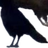

<class 'PIL.Image.Image'>
1132
5b8f86d1140c40568bc6e79d9aede60f_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/5b8f86d1140c40568bc6e79d9aede60f_jpg.rf Background Removed.b38670de260f9f4cf8a93db682c82924.png
<class 'NoneType'>
KNOLZLSSZXNH_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KNOLZLSSZXNH_jpg.rf Background Removed.f752634c4f7bbdaa0260577b24755b4c.png


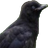

<class 'PIL.Image.Image'>
858
img606_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img606_jpeg_jpg.rf Background Removed.36d3d2fd0a9ce7060502eb3853e8c162.png


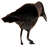

<class 'PIL.Image.Image'>
59
Rock-Pigeon-236_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-236_jpg.rf Background Removed.69ce0487183c50aa78135b0f7f7f40fe.png


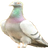

<class 'PIL.Image.Image'>
410
download-18-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-18-_jpeg.rf Background Removed.6b13c296223f1de87b69e5ff259621ab.png


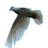

<class 'PIL.Image.Image'>
534
images121_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images121_jpg.rf Background Removed.f5d6fa7cf51e811e33f593058ebdd8ec.png


<class 'PIL.Image.Image'>
112
Rock-Pigeon-346_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-346_jpg.rf Background Removed.c6b2a73d1bf6ed9f3a8f2186a5668cba.png


<class 'PIL.Image.Image'>
91
images-98-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-98-_jpeg.rf Background Removed.1355401d69c96fca18efb4fadd13313a.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
1186
062_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/062_jpg.rf Background Removed.022c5487491e9b8439dfe9d209be4805.png


<class 'PIL.Image.Image'>
756
Rock-Pigeon-51_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-51_jpg.rf Background Removed.680ce41faaeb5511c8d4df9f55b63c1a.png


<class 'PIL.Image.Image'>
324
crow-1321-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1321-_jpg.rf Background Removed.a5665d569a95e1aeffb98bbf8eff0050.png


<class 'PIL.Image.Image'>
637
crow-1363-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1363-_jpg.rf Background Removed.e0d28ef17b8b215bc15885a2a33fbf34.png


<class 'PIL.Image.Image'>
1143
crow-1322-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1322-_jpg.rf Background Removed.e56f9a00508bdc869cfd9c8a10f18b5e.png


<class 'PIL.Image.Image'>
1158
Rock-Pigeon-196_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-196_jpg.rf Background Removed.6f178ae9a44948b613679df2af06459e.png


<class 'PIL.Image.Image'>
356
Rock-Pigeon-71_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-71_jpg.rf Background Removed.c021a295c57ab632382f1d91af885719.png


<class 'PIL.Image.Image'>
477
HoodedCrow1HQ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HoodedCrow1HQ_jpg.rf Background Removed.e2bdf0f6d0183a502b85252471d539f3.png


<class 'PIL.Image.Image'>
299
Columba-livia421_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia421_jpg.rf Background Removed.a7bcb46d650e23941841de715ae59dcb.png


<class 'PIL.Image.Image'>
894
images252_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images252_jpg.rf Background Removed.b883b432854ac878549fb2ab8d642e9b.png


<class 'PIL.Image.Image'>
1039
015_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/015_jpg.rf Background Removed.81c56d8156227bacbd0503c7de514409.png


<class 'PIL.Image.Image'>
446
Rock-Pigeon-69_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-69_jpg.rf Background Removed.724557430bf5a1b0b50e8be88d96fee3.png


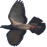

<class 'PIL.Image.Image'>
1188
img361_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img361_jpg.rf Background Removed.26f232689a98c970f2ae540d5b67f8bb.png


<class 'PIL.Image.Image'>
350
ix1jsnkcm9v71_png
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ix1jsnkcm9v71_png.rf Background Removed.dbfa41ba15e3b865f4c95271ad4827e2.png


<class 'PIL.Image.Image'>
143
000039_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000039_jpg.rf Background Removed.865e75f8c59199d0f71e1b69ef298f8a.png


<class 'PIL.Image.Image'>
574
images319_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images319_jpg.rf Background Removed.a120343d7fb02890ff6c9de46dc3e646.png


<class 'PIL.Image.Image'>
663
070_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/070_jpg.rf Background Removed.4a905c545cd4dd80f1bab91849ce9000.png


<class 'PIL.Image.Image'>
647
images-36-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-36-_jpeg.rf Background Removed.4fc1d1f6fd69ecf9aa409fc48252fabb.png


<class 'PIL.Image.Image'>
349
crow-1234-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1234-_jpg.rf Background Removed.2b83f87816b63e351c521e5c7d3fbd17.png


<class 'PIL.Image.Image'>
268
000050_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000050_jpg.rf Background Removed.edf0d89c9c24e69672599bc4e197a7a0.png


<class 'PIL.Image.Image'>
56
IMG_4614_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4614_JPG_jpg.rf Background Removed.021989475a7d99f7d59ca71a571f32a0.png


<class 'PIL.Image.Image'>
267
download-3-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-3-_jpeg.rf Background Removed.eb8098e2453aeb27c79add9ae807a7d5.png


<class 'PIL.Image.Image'>
396
Rock-Pigeon-31_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-31_jpg.rf Background Removed.6954f7456b12528ffc26c2773a0ddfd2.png


<class 'PIL.Image.Image'>
985
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-20_jpg.rf Background Removed.9ad4c7fe9b70998a1214185be21db19e.png


<class 'PIL.Image.Image'>
246
FJ1PCD8D17N8_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FJ1PCD8D17N8_aug_jpg.rf Background Removed.86a9382900a6d3969010ac7df3bbe999.png


<class 'PIL.Image.Image'>
693
IMG_4643_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4643_JPG_jpg.rf Background Removed.79cd335f51d54e3dbef01e4bd18dd989.png


<class 'PIL.Image.Image'>
1109
Rock-Pigeon-62_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-62_jpg.rf Background Removed.f0a4813ea54852c586dbeba8bb878df9.png


<class 'PIL.Image.Image'>
1260
IMG_4659_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4659_JPG_jpg.rf Background Removed.c968b2e14a63dc56a469786ba2b71178.png


<class 'PIL.Image.Image'>
89
Columba-livia332_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia332_jpg.rf Background Removed.ddf081f88b01d5228e6670a2e81c0ad0.png


<class 'PIL.Image.Image'>
227
20231009_165322_40_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_40_jpg.rf Background Removed.2646d2d8efd5ab6631a68ed28116376a.png


<class 'PIL.Image.Image'>
311
FJAZG2H0LVV7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FJAZG2H0LVV7_jpg.rf Background Removed.3782b1d3d0e1b54ce846ca90b9cf6959.png


<class 'PIL.Image.Image'>
852
063_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/063_jpg.rf Background Removed.3c543620e4b06fe5ca449dcf158c625b.png


<class 'PIL.Image.Image'>
1107
crow-1451-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1451-_jpg.rf Background Removed.ede98a5a81fee800b3d16d322b658823.png


<class 'PIL.Image.Image'>
274
images-49-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-49-_jpeg.rf Background Removed.e8222711f6a531a1ad1f716788e975cd.png


<class 'PIL.Image.Image'>
450
images230_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images230_jpg.rf Background Removed.67fec2f7bcd619f460f7b4b6fccdbee6.png


<class 'PIL.Image.Image'>
1080
images-51-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-51-_jpeg.rf Background Removed.692e5de40b98643b1fe2717e2e0c9da9.png


<class 'PIL.Image.Image'>
920
050_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/050_jpg.rf Background Removed.92e3ca569cb3480da4417afe2481ab1e.png


<class 'PIL.Image.Image'>
490
000076_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000076_jpg.rf Background Removed.805e7e967b4d1e1ddeb9ea878606362f.png


<class 'PIL.Image.Image'>
745
f772723261844c2190cef18b22ccda2f_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f772723261844c2190cef18b22ccda2f_jpg.rf Background Removed.e83c6941d19b8903acf32b4766ddf984.png
<class 'NoneType'>
Columba-livia39_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia39_jpg.rf Background Removed.d00449ca6a19b28e4adf56f143bc2524.png


<class 'PIL.Image.Image'>
408
crow-1297-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1297-_jpg.rf Background Removed.29a524c5d78e84c27095d2503e72cc1d.png


<class 'PIL.Image.Image'>
963
G5MVHVWBXBCZ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/G5MVHVWBXBCZ_jpg.rf Background Removed.583646630d1f9ded3918b45bd04e5eeb.png


<class 'PIL.Image.Image'>
389
IMG_4582_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4582_JPG_jpg.rf Background Removed.d56044a2ca41eeb92e04f0a8424f8422.png


<class 'PIL.Image.Image'>
1083
Rock-Pigeon-203_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-203_jpg.rf Background Removed.a699fb440747d3741958af68bbbc3d56.png


<class 'PIL.Image.Image'>
704
Rock-Pigeon-23_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-23_jpg.rf Background Removed.aa8a995aec6a545743cc4b96e9ae73d0.png


<class 'PIL.Image.Image'>
194
Rock-Pigeon-35_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-35_jpg.rf Background Removed.88a9c5ac3d534e08d04edb73b3d85db2.png


<class 'PIL.Image.Image'>
862
7AYPSS99CO12_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/7AYPSS99CO12_jpg.rf Background Removed.9d1061338621eccf9f6db4a3ab5e424b.png


<class 'PIL.Image.Image'>
117
20231009_165322_60_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_60_jpg.rf Background Removed.f2198d093423bce521c678ad443b397c.png


<class 'PIL.Image.Image'>
497
eefd915cfa1c468893f842005c8118f5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/eefd915cfa1c468893f842005c8118f5_jpg.rf Background Removed.dd2e2f6efcbf5443ab5c1bea715d0029.png
<class 'NoneType'>
Rock-Pigeon-59_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-59_jpg.rf Background Removed.ef971815869bab94dacd454838b99da7.png


<class 'PIL.Image.Image'>
915
images44_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images44_jpg.rf Background Removed.b1b3552e182046ece9982dfdef9e6ef2.png


<class 'PIL.Image.Image'>
466
2IUVUGK8X1TW_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2IUVUGK8X1TW_aug_jpg.rf Background Removed.3d7be3c6043330f6c713733fa6ca79c1.png


<class 'PIL.Image.Image'>
171
KakaoTalk_20240615_220943411_04_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220943411_04_jpg.rf Background Removed.47e0585b007d96e146e6b2c1a47dc12b.png


<class 'PIL.Image.Image'>
961
crows-in-tree-shutterstock-best-birds_1024_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crows-in-tree-shutterstock-best-birds_1024_jpg.rf Background Removed.b1a9860b9be4a780ebe22a9817eb851d.png


<class 'PIL.Image.Image'>
972
Rock-Pigeon-73_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-73_jpg.rf Background Removed.532f409f74e2feec3f5428e97cc6782a.png


<class 'PIL.Image.Image'>
436
images5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images5_jpg.rf Background Removed.692e3864c2248d4791228d33d0204219.png


<class 'PIL.Image.Image'>
795
images75_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images75_jpg.rf Background Removed.89c2c85ff74e890b20066ad677e9db31.png


<class 'PIL.Image.Image'>
1072
images234_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images234_jpg.rf Background Removed.578f3128549f66e37c69a312a358ca86.png


<class 'PIL.Image.Image'>
1100
Rock-Pigeon-170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-170_jpg.rf Background Removed.8e0b8da30bce8c1358cb8119695ab00c.png


<class 'PIL.Image.Image'>
870
images9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images9_jpg.rf Background Removed.bd0e90f17997ca527a9f87009c803d52.png


<class 'PIL.Image.Image'>
327
PLEHGNPM0P1E_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PLEHGNPM0P1E_jpg.rf Background Removed.e92660128a07d19219a9cadac3ebb9b7.png


<class 'PIL.Image.Image'>
847
036_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/036_jpg.rf Background Removed.563a756e6d6ae6d4266a053b2dc6aa2f.png


<class 'PIL.Image.Image'>
350
IMG_4750_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4750_JPG_jpg.rf Background Removed.8d250f43e4706dfa603c5a538808b6ec.png


<class 'PIL.Image.Image'>
407
BYTWWJ9SAFJL_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BYTWWJ9SAFJL_aug_jpg.rf Background Removed.c5034d6b403f57fd0ecb95938f5eae53.png


<class 'PIL.Image.Image'>
967
crow-1321-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1321-_jpg.rf Background Removed.a5665d569a95e1aeffb98bbf8eff0050.png


<class 'PIL.Image.Image'>
27
crow-1288-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1288-_jpg.rf Background Removed.c22b8e1a6259e911620f6154056bcad3.png


<class 'PIL.Image.Image'>
77
37d8cded5e93443a964e98ba6fe1df0c_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/37d8cded5e93443a964e98ba6fe1df0c_jpg.rf Background Removed.141396364111889beb888d6566d3462c.png
<class 'NoneType'>
Rock-Pigeon-324_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-324_jpg.rf Background Removed.156586de800026b289adf7e712b327ba.png


<class 'PIL.Image.Image'>
414
105_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/105_jpg.rf Background Removed.c183932b6351410a646d2b63f6e93801.png


<class 'PIL.Image.Image'>
806
crow-1401-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1401-_jpg.rf Background Removed.35b4e8d7622d281729047d7b07ea2a30.png


<class 'PIL.Image.Image'>
1051
MB66L889ROUK_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/MB66L889ROUK_jpg.rf Background Removed.eb7d97c263893f54e2fd20d33b65e8d1.png


<class 'PIL.Image.Image'>
402
images306_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images306_jpg.rf Background Removed.03dfadf581ed3b8ff401fb2c55426364.png


<class 'PIL.Image.Image'>
806
105_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/105_jpg.rf Background Removed.c183932b6351410a646d2b63f6e93801.png


<class 'PIL.Image.Image'>
1139
20240613_100420_40_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_40_jpg.rf Background Removed.de22cac588d127720d072ea222fd1daa.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
images-2024-01-19T222546-963_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222546-963_jpeg.rf Background

<class 'PIL.Image.Image'>
404
ZY3ZJ4X4E2MF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZY3ZJ4X4E2MF_jpg.rf Background Removed.3e1108c1e72181544b3602bfef125b0d.png


<class 'PIL.Image.Image'>
1020
Columba-livia76_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia76_jpg.rf Background Removed.c780f0540bce6a65c5eda7396fa1e305.png


<class 'PIL.Image.Image'>
597
Columba-livia181_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia181_jpg.rf Background Removed.956640eae2b4c508c10bdbb2f9274e15.png


<class 'PIL.Image.Image'>
1220
crow-1489-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1489-_jpg.rf Background Removed.a3bf5076a85f036afc9f966ec0e8cd2a.png


<class 'PIL.Image.Image'>
883
how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg.rf Background Removed.d40a49144d57bd1bd0e419359016a28c.png


<class 'PIL.Image.Image'>
1136
N25U9GHSYZ92_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N25U9GHSYZ92_jpg.rf Background Removed.c4d2a11c76b997f730e3a904300e4e60.png


<class 'PIL.Image.Image'>
946
N6U3PG88FSPB_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N6U3PG88FSPB_jpg.rf Background Removed.3af9be575456b6cf544c0d1a0f135f4f.png


<class 'PIL.Image.Image'>
143
ITG9ZSC041C4_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ITG9ZSC041C4_jpg.rf Background Removed.2f238566b0e59fc08456ccb651af9a29.png


<class 'PIL.Image.Image'>
1171
IMG_4626_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4626_JPG_jpg.rf Background Removed.e1f6a305caae0cfb9779181222e0338c.png


<class 'PIL.Image.Image'>
672
images-2024-01-19T222559-861_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222559-861_jpeg.rf Background Removed.89ced8319276d9006b885639de03c171.png


<class 'PIL.Image.Image'>
65
images-2024-01-19T222916-222_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222916-222_jpeg.rf Background Removed.460ca46b74203d78e174dcac0517e7d7.png


<class 'PIL.Image.Image'>
265
images-84-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-84-_jpeg.rf Background Removed.5588f5af95ffecbfcfae0f69e3302383.png


<class 'PIL.Image.Image'>
359
img468_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img468_jpeg_jpg.rf Background Removed.290ac0860b7b2d3109cd2866c900e742.png


<class 'PIL.Image.Image'>
385
ANORLFOX4NNG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ANORLFOX4NNG_jpg.rf Background Removed.3f81dda66f5810104ea0c63d74990a79.png


<class 'PIL.Image.Image'>
69
KakaoTalk_20240615_220823841_24_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_24_jpg.rf Background Removed.167949339fdd72ebe3c6e855c35d5765.png


<class 'PIL.Image.Image'>
640
XAT4PCURRF5V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/XAT4PCURRF5V_jpg.rf Background Removed.87a1becbfd522722398150daaa216db0.png


<class 'PIL.Image.Image'>
489
IMG_4771_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4771_JPG_jpg.rf Background Removed.0e6b4d3e18f0464506ba73f45107c149.png


<class 'PIL.Image.Image'>
792
UE7YBBV9WC4M_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UE7YBBV9WC4M_aug_jpg.rf Background Removed.baf3688e502ccc5fc9bfebe068785584.png


<class 'PIL.Image.Image'>
28
Rock-Pigeon-119_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-119_jpg.rf Background Removed.36558f293e91c103755f7e421a4dc338.png


<class 'PIL.Image.Image'>
1056
crow-1403-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1403-_jpg.rf Background Removed.751a881e16af7e89e12cb5ca7365f5e7.png


<class 'PIL.Image.Image'>
572
crow-1454-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1454-_jpg.rf Background Removed.f3b18e2d91c15a9c806b5f85a19e7dbf.png


<class 'PIL.Image.Image'>
496
105_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/105_jpg.rf Background Removed.c183932b6351410a646d2b63f6e93801.png


<class 'PIL.Image.Image'>
70
crow-1414-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1414-_jpg.rf Background Removed.c4905ee3a762684afa8372607072117a.png


<class 'PIL.Image.Image'>
891
Columba-livia421_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia421_jpg.rf Background Removed.a7bcb46d650e23941841de715ae59dcb.png


<class 'PIL.Image.Image'>
182
Rock-Pigeon-233_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-233_jpg.rf Background Removed.3200f8e651326b9e0ceb9b1dfce6e3bb.png


<class 'PIL.Image.Image'>
400
crow-1232-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1232-_jpg.rf Background Removed.6b56da0ec17d323adb55eabba246ccd7.png


<class 'PIL.Image.Image'>
139
034_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/034_jpg.rf Background Removed.3c37767965653ee395238382b8f0a2b8.png


<class 'PIL.Image.Image'>
710
Rock-Pigeon-236_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-236_jpg.rf Background Removed.69ce0487183c50aa78135b0f7f7f40fe.png


<class 'PIL.Image.Image'>
777
091_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/091_jpg.rf Background Removed.2f096b8aa819758572e9361d3dca3f51.png


<class 'PIL.Image.Image'>
160
crow-1310-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1310-_jpg.rf Background Removed.0b31240a0321b636377ecab3d36a4266.png


<class 'PIL.Image.Image'>
35
img313_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img313_jpeg_jpg.rf Background Removed.6a1697137b9c54c045a45959631d8d35.png


<class 'PIL.Image.Image'>
510
UP1WXWIF3AQD_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UP1WXWIF3AQD_jpg.rf Background Removed.7f4cb6c4ae085930e22ad40f1f0d9d01.png


<class 'PIL.Image.Image'>
644
crow-1402-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1402-_jpg.rf Background Removed.ebdada3f0bc97b92e8961bcca06d173f.png


<class 'PIL.Image.Image'>
74
Columba-livia238_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia238_jpg.rf Background Removed.7ee3f2be4adb191b890b3cb8806a36de.png


<class 'PIL.Image.Image'>
1037
Rock-Pigeon-124_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-124_jpg.rf Background Removed.c41ba3c2debb5e1d0104a06dbe9555b6.png


<class 'PIL.Image.Image'>
1016
061_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/061_jpg.rf Background Removed.815544ab97061296d49cac350c2ea91b.png


<class 'PIL.Image.Image'>
1219
crow-1412-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1412-_jpg.rf Background Removed.b00b4dafb9b851c301a6556bc2bc4dca.png


<class 'PIL.Image.Image'>
79
000066_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000066_jpg.rf Background Removed.f46bfcbb59a876a5c54b26c0889dcfe5.png


<class 'PIL.Image.Image'>
1143
f772723261844c2190cef18b22ccda2f_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f772723261844c2190cef18b22ccda2f_jpg.rf Background Removed.e83c6941d19b8903acf32b4766ddf984.png
<class 'NoneType'>
crow-1407-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1407-_jpg.rf Background Removed.6dc8d7ff3c50dab7c4f648e34465bb11.png


<class 'PIL.Image.Image'>
885
Rock-Pigeon-351_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-351_jpg.rf Background Removed.58ed7df55b8d3aa1eddb11a601259545.png


<class 'PIL.Image.Image'>
743
Rock-Pigeon-1_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-1_jpg.rf Background Removed.8c0e61e072610035a205d418a30c6dc3.png


<class 'PIL.Image.Image'>
595
f1db3116d31c4b57bdad10e834c6d119_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/f1db3116d31c4b57bdad10e834c6d119_jpg.rf Background Removed.e0ef8dcf1470053484d9b1d4b0a3c9f2.png
<class 'NoneType'>
3FAWQP2ORIC9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/3FAWQP2ORIC9_jpg.rf Background Removed.638882689f887a994fd76b9b55a7de2e.png


<class 'PIL.Image.Image'>
295
000076_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000076_jpg.rf Background Removed.805e7e967b4d1e1ddeb9ea878606362f.png


<class 'PIL.Image.Image'>
1230
108_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/108_jpg.rf Background Removed.483768bce43d09810f5178b54014ac81.png


<class 'PIL.Image.Image'>
287
crow-1234-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1234-_jpg.rf Background Removed.2b83f87816b63e351c521e5c7d3fbd17.png


<class 'PIL.Image.Image'>
786
Rock-Pigeon-304_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-304_jpg.rf Background Removed.09182e72f47a39c36128dfef9a89fdf6.png


<class 'PIL.Image.Image'>
1168
crow-1245-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1245-_jpg.rf Background Removed.61e6c7eb573460ada103258593c7f978.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
379
KNOLZLSSZXNH_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KNOLZLSSZXNH_jpg.rf Background Removed.f752634c4f7bbdaa0260577b24755b4c.png


<class 'PIL.Image.Image'>
703
bb8aaa706e25409fa469c92d44a950bb_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/bb8aaa706e25409fa469c92d44a950bb_jpg.rf Background Removed.e6bb6131db35a27bb222e614ea3d02d2.png
<class 'NoneType'>
Rock-Pigeon-84_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-84_jpg.rf Background Removed.13ac8ac3de31236877fa8421aa78db5a.png


<class 'PIL.Image.Image'>
818
crow-1379-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1379-_jpg.rf Background Removed.de0fd8e2cfa5993a4770bdc5417841ce.png


<class 'PIL.Image.Image'>
422
8409d8040bad4638b300c5bb58a8e1ef_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/8409d8040bad4638b300c5bb58a8e1ef_jpg.rf Background Removed.9a26347282b5385316e2473374535e10.png
<class 'NoneType'>
download-9-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-9-_jpeg.rf Background Removed.6ff7c1b87e45d28ac94ed96c98a80bbd.png


<class 'PIL.Image.Image'>
120
000010_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000010_jpg.rf Background Removed.79c551cddd5dd0e54e3eb78e3540437e.png


<class 'PIL.Image.Image'>
393
IHUHQYGIQHXM_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/IHUHQYGIQHXM_jpg.rf Background Removed.cc2d1535dd6327761487004583b34d13.png


<class 'PIL.Image.Image'>
1089
20240613_100420_80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_80_jpg.rf Background Removed.05f2984a7ca053ec2afb7d9edc2fbaec.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
062_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/062_jpg.rf Background Removed.022c5487491e9b8439dfe9d209be4805.png


<class 'PIL.Image.Image'>
259
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-25_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-25_jpg.rf Background Removed.ec038a05e7df0c11cd6c2c9594adac4f.png


<class 'PIL.Image.Image'>
228
6JFIHLEGLBTY_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/6JFIHLEGLBTY_jpg.rf Background Removed.b5b220cec22fa4af7ee34ead03810e78.png


<class 'PIL.Image.Image'>
32
crow-1385-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1385-_jpg.rf Background Removed.2078fa727f4fbb048c441c78c47cc073.png


<class 'PIL.Image.Image'>
918
crow-1203-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1203-_jpg.rf Background Removed.d6cccec3352cdfdfdd223b618b1b10b7.png


<class 'PIL.Image.Image'>
852
000091_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000091_jpg.rf Background Removed.97c9f516a8c35cff1665d0e2f3b7352c.png


<class 'PIL.Image.Image'>
44
images5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images5_jpg.rf Background Removed.692e3864c2248d4791228d33d0204219.png


<class 'PIL.Image.Image'>
285
Rock-Pigeon-120_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-120_jpg.rf Background Removed.bed7b920df0ca5473f6a67952608ecd2.png


<class 'PIL.Image.Image'>
364
Rock-Pigeon-221_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-221_jpg.rf Background Removed.6bbb245eeb0a4c64c3f7b4ff18838d1e.png


<class 'PIL.Image.Image'>
75
crow-1311-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1311-_jpg.rf Background Removed.a2b68df147d0ee61821301165a73e0b8.png


<class 'PIL.Image.Image'>
633
Rock-Pigeon-7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-7_jpg.rf Background Removed.9e1c3a4ce5461ddd9fe173bc8de197ee.png


<class 'PIL.Image.Image'>
897
Rock-Pigeon-192_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-192_jpg.rf Background Removed.154384ac68f20fae3143d9e1eb0054bb.png


<class 'PIL.Image.Image'>
614
Rock-Pigeon-25_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-25_jpg.rf Background Removed.eb2e56d5923d4c6f2e47b8f6a41dda40.png


<class 'PIL.Image.Image'>
420
Rock-Pigeon-39_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-39_jpg.rf Background Removed.36c5593e90da928d16613ab5c45bbdf7.png


<class 'PIL.Image.Image'>
215
N8QUYLCS7IBP_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N8QUYLCS7IBP_aug_jpg.rf Background Removed.38c76ee2fa6a93f22c568279310d38c8.png


<class 'PIL.Image.Image'>
116
Rock-Pigeon-131_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-131_jpg.rf Background Removed.0180d339e30b3757ea3b6b2e998ff35b.png


<class 'PIL.Image.Image'>
923
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-28_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-28_jpg.rf Background Removed.aff7f9adf534587d26b7908bc6e1f761.png


<class 'PIL.Image.Image'>
1056
3B47MIRUNAJX_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/3B47MIRUNAJX_aug_jpg.rf Background Removed.4a2b8f003aca147bd60c188abe6db0a8.png


<class 'PIL.Image.Image'>
1189
Columba-livia331_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia331_jpg.rf Background Removed.985ca7a41fd1f48942ee604d933ba7fc.png


<class 'PIL.Image.Image'>
386
Rock-Pigeon-315_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-315_jpg.rf Background Removed.9ea4cf186e62c559aeb8b8bee095507c.png


<class 'PIL.Image.Image'>
425
img118_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img118_jpeg_jpg.rf Background Removed.b2b6af26551dc90ee2d6a6e85ef79363.png


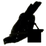

<class 'PIL.Image.Image'>
1135
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-21_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-21_jpg.rf Background Removed.89d430ff848340818bb2d887dd95b3f9.png


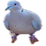

<class 'PIL.Image.Image'>
954
crow-1334-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1334-_jpg.rf Background Removed.446bbe8953a0e0f7204aae9b09c947ed.png


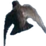

<class 'PIL.Image.Image'>
1013
images-2024-01-19T222847-338_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222847-338_jpeg.rf Background Removed.d82fe45d711cc04937228453de5f2e04.png


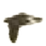

<class 'PIL.Image.Image'>
313
079_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/079_jpg.rf Background Removed.81c5955488cda2ac50bc1c2692781087.png


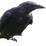

<class 'PIL.Image.Image'>
597
Rock-Pigeon-355_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-355_jpg.rf Background Removed.10ff3ad1735f99984446ef842288025a.png


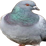

<class 'PIL.Image.Image'>
48
images103_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images103_jpg.rf Background Removed.6f437ac598fecfa0424ed6a2611c13ab.png


<class 'PIL.Image.Image'>
546
images-40-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-40-_jpeg.rf Background Removed.9830beecad1aa22a945dacbfdd336a94.png


<class 'PIL.Image.Image'>
424
Rock-Pigeon-245_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-245_jpg.rf Background Removed.c5437eec72ba9461cede1524a174345f.png


<class 'PIL.Image.Image'>
669
BFKX5NN2E720_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BFKX5NN2E720_aug_jpg.rf Background Removed.d7f9b74dff5853bb691a929629b73c4b.png


<class 'PIL.Image.Image'>
50
042_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/042_jpg.rf Background Removed.83c6e96bde15e50c2a6dc80f6ddc779b.png


<class 'PIL.Image.Image'>
394
TNK8N3YUNE52_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/TNK8N3YUNE52_jpg.rf Background Removed.0ea5e05b41a2eb3cf64eb0d993189682.png


<class 'PIL.Image.Image'>
657
crow-1280-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1280-_jpg.rf Background Removed.61f33cc954b99be92b9736ea163f7443.png


<class 'PIL.Image.Image'>
829
images160_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images160_jpg.rf Background Removed.18051ae4d3a5e7807c26861cd0bfbaa5.png


<class 'PIL.Image.Image'>
134
crow-1414-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1414-_jpg.rf Background Removed.c4905ee3a762684afa8372607072117a.png


<class 'PIL.Image.Image'>
948
img537_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img537_jpg.rf Background Removed.b2558b3e0154c03bffad3e9ae4738289.png


<class 'PIL.Image.Image'>
767
images126_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images126_jpg.rf Background Removed.16b56f6bf001d0442525153198b8c633.png


<class 'PIL.Image.Image'>
496
EBUVL9JAKFHI_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EBUVL9JAKFHI_jpg.rf Background Removed.b83fcacd7698bd023e5268ef2c25ab01.png


<class 'PIL.Image.Image'>
658
crow-1234-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1234-_jpg.rf Background Removed.2b83f87816b63e351c521e5c7d3fbd17.png


<class 'PIL.Image.Image'>
314
crow-1258-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1258-_jpg.rf Background Removed.a52522af187cccb355c406d67659853a.png


<class 'PIL.Image.Image'>
137
Rock-Pigeon-23_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-23_jpg.rf Background Removed.aa8a995aec6a545743cc4b96e9ae73d0.png


<class 'PIL.Image.Image'>
1080
images324_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images324_jpg.rf Background Removed.42536452d0d91c189bc4d363d493d621.png


<class 'PIL.Image.Image'>
195
img401_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img401_jpeg_jpg.rf Background Removed.2a737a703683f61bb752a8e2b4953de0.png


<class 'PIL.Image.Image'>
82
Rock-Pigeon-323_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-323_jpg.rf Background Removed.2f6ba392ea73648711e685fa9338e2e0.png


<class 'PIL.Image.Image'>
306
HBADZUM4FL7X_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HBADZUM4FL7X_jpg.rf Background Removed.9bd8efe7ffb0232920634e1564d8d9f9.png


<class 'PIL.Image.Image'>
1191
6JFIHLEGLBTY_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/6JFIHLEGLBTY_aug_jpg.rf Background Removed.b72be39fb8875005976dee70fa20cffb.png


<class 'PIL.Image.Image'>
52
IMG_4653_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4653_JPG_jpg.rf Background Removed.c1bc4050918a6104e1562cde3f794036.png


<class 'PIL.Image.Image'>
207
img401_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img401_jpeg_jpg.rf Background Removed.2a737a703683f61bb752a8e2b4953de0.png


<class 'PIL.Image.Image'>
893
IMG_4588_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4588_JPG_jpg.rf Background Removed.b9a97a4469fb02048fe2c7435215b6fe.png


<class 'PIL.Image.Image'>
825
Rock-Pigeon-194_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-194_jpg.rf Background Removed.1c92085fe2f9863345de54817cc17fde.png


<class 'PIL.Image.Image'>
549
Columba-livia87_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia87_jpg.rf Background Removed.256697031f43ba11fcf1d4b08e1b523c.png


<class 'PIL.Image.Image'>
1116
crow-1397-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1397-_jpg.rf Background Removed.845c864e43d5a21ecfaacba566ef2e13.png


<class 'PIL.Image.Image'>
121
images252_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images252_jpg.rf Background Removed.b883b432854ac878549fb2ab8d642e9b.png


<class 'PIL.Image.Image'>
241
Rock-Pigeon-14_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-14_jpg.rf Background Removed.87295a5ba2e5927efee3a963fe51744b.png


<class 'PIL.Image.Image'>
366
Rock-Pigeon-351_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-351_jpg.rf Background Removed.58ed7df55b8d3aa1eddb11a601259545.png


<class 'PIL.Image.Image'>
1034
images7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images7_jpg.rf Background Removed.4f5049c7573cbc558fbb957b90100a8e.png


<class 'PIL.Image.Image'>
256
Rock-Pigeon-39_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-39_jpg.rf Background Removed.36c5593e90da928d16613ab5c45bbdf7.png


<class 'PIL.Image.Image'>
894
Columba-livia332_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia332_jpg.rf Background Removed.ddf081f88b01d5228e6670a2e81c0ad0.png


<class 'PIL.Image.Image'>
724
crow-1327-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1327-_jpg.rf Background Removed.5f11cbaec1ed7db7b4f540ee6846c009.png


<class 'PIL.Image.Image'>
113
Rock-Pigeon-357_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-357_jpg.rf Background Removed.3b8452d09c2772f83df58b2cc053facf.png


<class 'PIL.Image.Image'>
189
Rock-Pigeon-63_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-63_jpg.rf Background Removed.400f9e290268c70b13c90fda4aef026a.png


<class 'PIL.Image.Image'>
750
BJPNGXI2C2EG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BJPNGXI2C2EG_jpg.rf Background Removed.12d752a52cac4258943e91bba28cba39.png
KNOLZLSSZXNH_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KNOLZLSSZXNH_jpg.rf Background Removed.f752634c4f7bbdaa0260577b24755b4c.png


<class 'PIL.Image.Image'>
873
carrion-crow-turkenshanzpark-vienna-1_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/carrion-crow-turkenshanzpark-vienna-1_jpg.rf Background Removed.5f9234b4c29e1370f5f7aa76b8deec32.png


<class 'PIL.Image.Image'>
822
crow-1221-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1221-_jpg.rf Background Removed.3e0c89141c7e941f6aefcd17ef572aef.png


<class 'PIL.Image.Image'>
579
crow-1282-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1282-_jpg.rf Background Removed.a79559e868b27a33376f0242748ae98b.png
000091_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000091_jpg.rf Background Removed.97c9f516a8c35cff1665d0e2f3b7352c.png


<class 'PIL.Image.Image'>
1170
hooded-crow-corvus-cornix-vienna-austria_563495-842_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/hooded-crow-corvus-cornix-vienna-austria_563495-842_jpg.rf Background Removed.a89abc8206edf5b36fc76f30e041cec2.png


<class 'PIL.Image.Image'>
1137
L5M1A5U5F309_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L5M1A5U5F309_jpg.rf Background Removed.e96e9e93e3553fc89bc21d2af11a7d31.png


<class 'PIL.Image.Image'>
1138
crow-1462-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1462-_jpg.rf Background Removed.0ddfc4c2df3a02cb0fd1434b451674fe.png
Rock-Pigeon-250_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-250_jpg.rf Background Removed.598d74d3f579e067d0450f781055fb9a.png


<class 'PIL.Image.Image'>
411
CBBNXZTKO5O3_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/CBBNXZTKO5O3_jpg.rf Background Removed.eaf3d7fb1091cf185b30fcda000ebc7a.png


<class 'PIL.Image.Image'>
236
Rock-Pigeon-275_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-275_jpg.rf Background Removed.c79318ea19aeee3907c9071e2a3b137a.png


<class 'PIL.Image.Image'>
712
IMG_4657_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4657_JPG_jpg.rf Background Removed.fa9603f00d17affd530b431803c3fb37.png


<class 'PIL.Image.Image'>
414
img600_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img600_jpeg_jpg.rf Background Removed.36bcaf6b9c98bbf20a36211a1b87c2eb.png


<class 'PIL.Image.Image'>
576
Columba-livia191_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia191_jpg.rf Background Removed.04272c53f2c940cfd65c3cb7f3f8c257.png


<class 'PIL.Image.Image'>
1151
000030_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000030_jpg.rf Background Removed.d54e74c6daaea56205e15d2ffbd02110.png


<class 'PIL.Image.Image'>
1063
Rock-Pigeon-202_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-202_jpg.rf Background Removed.3025c116801d41113953ee762a92b7f3.png


<class 'PIL.Image.Image'>
288
images142_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images142_jpg.rf Background Removed.558f0f4b57c77730a9e9dd475fb7de06.png


<class 'PIL.Image.Image'>
1156
Rock-Pigeon-53_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-53_jpg.rf Background Removed.2cfc96fa85cefa2ce10f27fbf8c8d1e7.png


<class 'PIL.Image.Image'>
410
Rock-Pigeon-117_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-117_jpg.rf Background Removed.307e9e48bbb49e4147a4d4835ddd4bac.png


<class 'PIL.Image.Image'>
554
crow-1483-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1483-_jpg.rf Background Removed.824a416b6f010d1fb5a73365b84a38b7.png


<class 'PIL.Image.Image'>
160
PMZ9GFC71YTJ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PMZ9GFC71YTJ_jpg.rf Background Removed.1126f7b9cb66cf0347f1dc6bda175846.png


<class 'PIL.Image.Image'>
193
Corvus_cornix_Vienna-JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/Corvus_cornix_Vienna-JPG_jpg.rf Background Removed.8ae0815f820d985e9e59e1cb648752a6.png


<class 'PIL.Image.Image'>
67
Rock-Pigeon-43_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-43_jpg.rf Background Removed.fdc234b9ef312ea19fa3a3c427c2f5b1.png


<class 'PIL.Image.Image'>
1209
0e330d598ff343298d775062fcf1e1fb_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/0e330d598ff343298d775062fcf1e1fb_jpg.rf Background Removed.5f8ba89d8b776751671628ea299f524f.png
<class 'NoneType'>
Rock-Pigeon-104_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-104_jpg.rf Background Removed.0a0698e065b6405175c8510d646e8286.png


<class 'PIL.Image.Image'>
121
000031_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000031_jpg.rf Background Removed.f251204d50679188b69ed4ba6e7e6c8a.png


<class 'PIL.Image.Image'>
1152
IMG_4598_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4598_JPG_jpg.rf Background Removed.750f4dc65bd5098ceae0c99bc10e667b.png


<class 'PIL.Image.Image'>
776
image11_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image11_jpeg.rf Background Removed.83f05c5dea653ddda992b67d3f25f802.png


<class 'PIL.Image.Image'>
126
crow-1328-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1328-_jpg.rf Background Removed.20c2cbc42fb66ffce80fdf25d9fbae67.png


<class 'PIL.Image.Image'>
1090
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-19_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-19_jpg.rf Background Removed.da3f47e32a71860c3e8cea24eb4af415.png


<class 'PIL.Image.Image'>
169
096_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/096_jpg.rf Background Removed.8fae2a84e77f4453f2cdeead4366e99f.png


<class 'PIL.Image.Image'>
814
crow-1261-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1261-_jpg.rf Background Removed.b55c11ff9c5ae2836a13bead569c574f.png


<class 'PIL.Image.Image'>
499
img432_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img432_jpg.rf Background Removed.2bda1204d6e603d6c8ab89fe0fd03083.png


<class 'PIL.Image.Image'>
826
A9D7U8GKNAUT_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/A9D7U8GKNAUT_aug_jpg.rf Background Removed.2ff7c205ee172f98fab300c8817eece0.png


<class 'PIL.Image.Image'>
308
download-10-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-10-_jpeg.rf Background Removed.7b57f0d83b5b23f8131f07a55541948b.png


<class 'PIL.Image.Image'>
36
images-23-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-23-_jpeg.rf Background Removed.dcce58bbf01de3bc9034c21c2c08129e.png


<class 'PIL.Image.Image'>
601
IMG_4634_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4634_JPG_jpg.rf Background Removed.cc8d7b860fc31580c24ed4f6f4cf563d.png


<class 'PIL.Image.Image'>
40
000081_png
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000081_png.rf Background Removed.e8af3b1588f938b9de16d056e5a14f7b.png


<class 'PIL.Image.Image'>
269
XTPECKA77GHU_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/XTPECKA77GHU_jpg.rf Background Removed.995ae01a36f168040b99db8e6aae0f46.png


<class 'PIL.Image.Image'>
604
Rock-Pigeon-11_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-11_jpg.rf Background Removed.fdcbe1db69f0efe1725b65b534abd6a8.png


<class 'PIL.Image.Image'>
1202
Rock-Pigeon-85_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-85_jpg.rf Background Removed.9e586f0d263838859ee90cdff322dcca.png


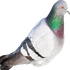

<class 'PIL.Image.Image'>
502
img415_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img415_jpeg_jpg.rf Background Removed.c0ba639a54bfcf73536567c7bea52745.png


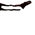

<class 'PIL.Image.Image'>
341
BSD13H7U4I3Y_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BSD13H7U4I3Y_aug_jpg.rf Background Removed.84c6c5c8c754e66c378dc05983de05c9.png


<class 'PIL.Image.Image'>
981
Rock-Pigeon-200_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-200_jpg.rf Background Removed.cf43202e64491678736b3080e01c729b.png


<class 'PIL.Image.Image'>
499
Columba-livia316_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia316_jpg.rf Background Removed.d8f6cf6285ede2ad48cfe9bb06ca4d5e.png


<class 'PIL.Image.Image'>
88
crow-1316-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1316-_jpg.rf Background Removed.95e5f9fd03333368173fcfb09e674cb4.png


<class 'PIL.Image.Image'>
128
Rock-Pigeon-314_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-314_jpg.rf Background Removed.ec9c8ef84cbb2549b5235aab038f7cc2.png


<class 'PIL.Image.Image'>
1006
UE7YBBV9WC4M_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UE7YBBV9WC4M_jpg.rf Background Removed.f8353ee80dd8986ecd6db0eb8253065e.png


<class 'PIL.Image.Image'>
465
009_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/009_jpg.rf Background Removed.ed92c5ac806891ed15ef2fa42eae7315.png


<class 'PIL.Image.Image'>
160
images295_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images295_jpg.rf Background Removed.8a3fab0a86f5373e130de34f811cf73a.png


<class 'PIL.Image.Image'>
35
PMZ9GFC71YTJ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PMZ9GFC71YTJ_jpg.rf Background Removed.1126f7b9cb66cf0347f1dc6bda175846.png


<class 'PIL.Image.Image'>
870
PUVM2MZYF1M1_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PUVM2MZYF1M1_jpg.rf Background Removed.d52ceb3635ba9632e0a9a847d153b506.png


<class 'PIL.Image.Image'>
496
20240102_142632_20_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240102_142632_20_jpg.rf Background Removed.fe82643fe6ffc2d0ad95911df81facb3.png


<class 'PIL.Image.Image'>
319
X542VFX9PVCV_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/X542VFX9PVCV_aug_jpg.rf Background Removed.907f9883c3bb155be6487d31143937a7.png


<class 'PIL.Image.Image'>
247
IMG_4743_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4743_JPG_jpg.rf Background Removed.22a68cf3d0d0fcf0a98621e97542a1fe.png


<class 'PIL.Image.Image'>
525
Columba-livia234_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia234_jpg.rf Background Removed.726a2d8b055021ed865a2a35bd928c4d.png


<class 'PIL.Image.Image'>
583
L8GTZOIR6OXC_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L8GTZOIR6OXC_jpg.rf Background Removed.788a5e6e4d10af59e5877b9cf9cebee6.png


<class 'PIL.Image.Image'>
798
crow-1302-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1302-_jpg.rf Background Removed.5315fd3649e28dd0db20f80bd1b7fb59.png


<class 'PIL.Image.Image'>
1271
images-47-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-47-_jpeg.rf Background Removed.2f01e445d1029d7b7ad5038c0e4e7a7c.png


<class 'PIL.Image.Image'>
1159
images-98-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-98-_jpeg.rf Background Removed.1355401d69c96fca18efb4fadd13313a.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
451
Rock-Pigeon-298_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-298_jpg.rf Background Removed.3f7d72f2464ba29de9e2cec9ca263cee.png


<class 'PIL.Image.Image'>
689
hooded-crow-corvus-cornix-vienna-austria_563495-847_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/hooded-crow-corvus-cornix-vienna-austria_563495-847_jpg.rf Background Removed.b3038b37bfe943405563a839ef85eb5a.png


<class 'PIL.Image.Image'>
542
Columba-livia326_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia326_jpg.rf Background Removed.9d522dbbcbb51d98e45795c703ffa94e.png


<class 'PIL.Image.Image'>
285
Columba-livia374_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia374_jpg.rf Background Removed.cef834a376d0fb1b7c73589cbbe9035c.png


<class 'PIL.Image.Image'>
325
Columba-livia120_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia120_jpg.rf Background Removed.7570808b1aef1e0254216046e9fa9397.png


<class 'PIL.Image.Image'>
1163
Rock-Pigeon-180_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-180_jpg.rf Background Removed.87d6416289e6abf0ac87d1a908783a60.png


<class 'PIL.Image.Image'>
666
ix1jsnkcm9v71_png
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ix1jsnkcm9v71_png.rf Background Removed.dbfa41ba15e3b865f4c95271ad4827e2.png


<class 'PIL.Image.Image'>
807
images-48-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-48-_jpeg.rf Background Removed.dd279ecc9f8cc59f6ffca8aa0696475c.png


<class 'PIL.Image.Image'>
1001
Rock-Pigeon-214_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-214_jpg.rf Background Removed.9162d8700475b1e09913ea14eeb93cb1.png


<class 'PIL.Image.Image'>
619
20240613_100420_40_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_40_jpg.rf Background Removed.de22cac588d127720d072ea222fd1daa.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
Rock-Pigeon-264_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-264_jpg.rf Background Removed.5f5a88be58830c81bf13

<class 'PIL.Image.Image'>
14
000017_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000017_jpg.rf Background Removed.5e6a4f6bc30c29385264f4c254fe4be0.png


<class 'PIL.Image.Image'>
1051
Rock-Pigeon-253_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-253_jpg.rf Background Removed.05ee47948aebd263d5d25223bda53762.png


<class 'PIL.Image.Image'>
732
crow-1443-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1443-_jpg.rf Background Removed.4579499024fe118e94ff842c3986fe46.png


<class 'PIL.Image.Image'>
32
crow-1424-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1424-_jpg.rf Background Removed.a1cf3758d8de662f2ff19daf8ceb9f95.png


<class 'PIL.Image.Image'>
92
QYZZMEV8BGUA_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/QYZZMEV8BGUA_aug_jpg.rf Background Removed.abf2adf025a56f0817f0e0a502a4ea72.png


<class 'PIL.Image.Image'>
928
crow-1360-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1360-_jpg.rf Background Removed.19b49d76db71a3ed05bfc90055325bdb.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
716
M5RQNOVOCMOQ_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/M5RQNOVOCMOQ_jpg.rf Background Removed.b555edaecf3edf85a0afda7d56503a58.png


<class 'PIL.Image.Image'>
751
images-2024-01-19T222348-246_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222348-246_jpeg.rf Background Removed.f3426251cf9ebef8414ebbcd0489a800.png


<class 'PIL.Image.Image'>
896
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-26_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-26_jpg.rf Background Removed.8d05b9b607583adfee3d8871b853a4f1.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
1129
IMG_4662_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4662_JPG_jpg.rf Background Removed.79fb5727a63dc66a0845e53dbbfbc0ae.png


<class 'PIL.Image.Image'>
17
Rock-Pigeon-354_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-354_jpg.rf Background Removed.b9e1b07332513c6f03a46a4bb1d0c01c.png


<class 'PIL.Image.Image'>
244
Rock-Pigeon-53_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-53_jpg.rf Background Removed.2cfc96fa85cefa2ce10f27fbf8c8d1e7.png


<class 'PIL.Image.Image'>
662
Rock-Pigeon-213_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-213_jpg.rf Background Removed.4442a446b20cb079cbd72b3ebdd34733.png


<class 'PIL.Image.Image'>
226
crow-1420-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1420-_jpg.rf Background Removed.f6f65065d19b0ec2ce1f3e99bd396ebc.png


<class 'PIL.Image.Image'>
510
Rock-Pigeon-274_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-274_jpg.rf Background Removed.277597e4854e86795745d6a251b1efcc.png


<class 'PIL.Image.Image'>
264
Rock-Pigeon-256_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-256_jpg.rf Background Removed.002b4371d37de9d342faf0bc03dcb209.png


<class 'PIL.Image.Image'>
926
Rock-Pigeon-41_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-41_jpg.rf Background Removed.1f5711b857ea3f6eb2085187e188f208.png


<class 'PIL.Image.Image'>
164
080_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/080_jpg.rf Background Removed.f90f30a61ff94bc5bd6079b6a9870304.png


<class 'PIL.Image.Image'>
927
N3EOGY4AAO4V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N3EOGY4AAO4V_jpg.rf Background Removed.0f6e8c1eae364044ea2e9526fb12269f.png


<class 'PIL.Image.Image'>
303
Rock-Pigeon-160_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-160_jpeg_jpg.rf Background Removed.ead1c60b2146404178985dfd3fe66c88.png


<class 'PIL.Image.Image'>
311
L7AD1EBPBXNK_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/L7AD1EBPBXNK_aug_jpg.rf Background Removed.60368c705fb65f8786a7834a5d366240.png


<class 'PIL.Image.Image'>
877
images228_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images228_jpg.rf Background Removed.de439aa988a096e8e9ad7de0d860e6d7.png


<class 'PIL.Image.Image'>
239
crow-1278-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1278-_jpg.rf Background Removed.7b7b1ee772955f20969721058767ef7c.png


<class 'PIL.Image.Image'>
1144
crow-1210-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1210-_jpg.rf Background Removed.7c0924b7188e223a36bf756bbcc48c4a.png
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
83
Columba-livia111_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia111_jpg.rf Background Removed.bebf837652d13bd824c8b7aa1df5a74c.png


<class 'PIL.Image.Image'>
173
images117_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images117_jpg.rf Background Removed.0cfcbda3bf21a613a824cb7603fb3d25.png


<class 'PIL.Image.Image'>
241
2KEOC8C0OTWC_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2KEOC8C0OTWC_aug_jpg.rf Background Removed.e9e252893f7f8e5a954e45db17191609.png


<class 'PIL.Image.Image'>
323
Rock-Pigeon-112_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-112_jpg.rf Background Removed.ea63941986e0d0bd788f15fdfc03ade0.png


<class 'PIL.Image.Image'>
425
20240613_100420_220_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20240613_100420_220_jpg.rf Background Removed.fd180124a5d2095ff6c4051a563c463e.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
VRVNPBQGFEPD_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/VRVNPBQGFEPD_jpg.rf Background Removed.66a35bca6d7ad70c5b384c3987

<class 'PIL.Image.Image'>
1046
062_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/062_jpg.rf Background Removed.022c5487491e9b8439dfe9d209be4805.png


<class 'PIL.Image.Image'>
500
Columba-livia203_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia203_jpg.rf Background Removed.791c70a7d99f3ce85ede08e397a4075f.png


<class 'PIL.Image.Image'>
652
crow-1206-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1206-_jpg.rf Background Removed.d37343aeb763598578acce1d82532d2f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
690
HQRK29D39IGM_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/HQRK29D39IGM_jpg.rf Background Removed.26a1f8cd04a5261b51ac59427954d341.png


<class 'PIL.Image.Image'>
617
crow-1451-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1451-_jpg.rf Background Removed.ede98a5a81fee800b3d16d322b658823.png


<class 'PIL.Image.Image'>
165
crow-1455-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1455-_jpg.rf Background Removed.ac43c8f14256b08fd3e798b4663dd797.png


<class 'PIL.Image.Image'>
450
000048_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000048_jpg.rf Background Removed.f564d9f9d18204417f3b7e00d76331bc.png


<class 'PIL.Image.Image'>
611
crow-1442-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1442-_jpg.rf Background Removed.c524cdc7bb49708f619ed31f0ee21752.png


<class 'PIL.Image.Image'>
912
crow-1202-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1202-_jpg.rf Background Removed.20f69de1ac3bff68b7af33464f666d08.png


<class 'PIL.Image.Image'>
177
crow-1419-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1419-_jpg.rf Background Removed.f961fc5b111cc6bc7c710b6d3c27acfd.png


<class 'PIL.Image.Image'>
662
5b764cf6a2a94e19a32d2d4fa26dd083_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/5b764cf6a2a94e19a32d2d4fa26dd083_jpg.rf Background Removed.95ec9aecb4e900129a1b938aa5cb08b2.png
<class 'NoneType'>
8409d8040bad4638b300c5bb58a8e1ef_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/8409d8040bad4638b300c5bb58a8e1ef_jpg.rf Background Removed.9a26347282b5385316e2473374535e10.png
<class 'NoneType'>
GFBCWYU3SS9F_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/GFBCWYU3SS9F_jpg.rf Background Removed.b4309a7d62992fafe211864f7e3a269a.png


<class 'PIL.Image.Image'>
188
Rock-Pigeon-156_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-156_jpg.rf Background Removed.ee5022e1dabd423073a8b440f1d78aea.png


<class 'PIL.Image.Image'>
321
crow-1287-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1287-_jpg.rf Background Removed.68783274654fcf6df4fd23d109088abd.png


<class 'PIL.Image.Image'>
641
Rock-Pigeon-298_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-298_jpg.rf Background Removed.3f7d72f2464ba29de9e2cec9ca263cee.png


<class 'PIL.Image.Image'>
321
Rock-Pigeon-256_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-256_jpg.rf Background Removed.002b4371d37de9d342faf0bc03dcb209.png


<class 'PIL.Image.Image'>
1098
137_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/137_jpg.rf Background Removed.f265c05dcdda5b747301489f1ab57935.png


<class 'PIL.Image.Image'>
37
000076_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000076_jpg.rf Background Removed.805e7e967b4d1e1ddeb9ea878606362f.png


<class 'PIL.Image.Image'>
174
088_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/088_jpg.rf Background Removed.e43e1a5089919e8d620d36c527907cf8.png


<class 'PIL.Image.Image'>
532
images295_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images295_jpg.rf Background Removed.8a3fab0a86f5373e130de34f811cf73a.png


<class 'PIL.Image.Image'>
682
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-29_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-29_jpg.rf Background Removed.5eb7e98e24a2f061636cdfe82b61ead0.png


<class 'PIL.Image.Image'>
1092
crow-1243-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1243-_jpg.rf Background Removed.cf8389f8c2fc4d2abfec25720a2e7099.png


<class 'PIL.Image.Image'>
964
img181_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img181_jpeg_jpg.rf Background Removed.a9e28d4b6fd8ce1b49007f58c2a7217a.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
Columba-livia234_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia234_jpg.rf Background Removed.726a2d8b055021ed865a2a35bd928c4d

<class 'PIL.Image.Image'>
271
Rock-Pigeon-45_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-45_jpg.rf Background Removed.24e76648e718ba2a4b36d08972c64281.png


<class 'PIL.Image.Image'>
913
img388_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img388_jpeg_jpg.rf Background Removed.b6a0266c09a8e4b68437d20ea82a2b1b.png


<class 'PIL.Image.Image'>
40
Rock-Pigeon-261_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-261_jpg.rf Background Removed.760691c900d5df3734c3a7fc58fa616c.png


<class 'PIL.Image.Image'>
806
Columba-livia99_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia99_jpg.rf Background Removed.6f6150df01d19692bb1001e3b6c16e3f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
Columba-livia339_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia339_jpg.rf Background Removed.7f5941d6e6ea53432bdf4b

<class 'PIL.Image.Image'>
884
crow-1316-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1316-_jpg.rf Background Removed.95e5f9fd03333368173fcfb09e674cb4.png


<class 'PIL.Image.Image'>
529
150f11f33026453e99101d47df93ef0d_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/150f11f33026453e99101d47df93ef0d_jpg.rf Background Removed.6d0d6f13119d402d4bdf46a13daae9da.png
<class 'NoneType'>
107_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/107_jpg.rf Background Removed.57bafadd30c859008a03c261affbe21d.png


<class 'PIL.Image.Image'>
367
Rock-Pigeon-65_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-65_jpg.rf Background Removed.397e6f34054549f92adbe0df2a8b1f6e.png


<class 'PIL.Image.Image'>
228
Rock-Pigeon-5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-5_jpg.rf Background Removed.9994e4be1aaf42fce45e8d0b31b9f17e.png


<class 'PIL.Image.Image'>
1194
images-95-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-95-_jpeg.rf Background Removed.048e04147a5ec8e641d8daa8d3eca24e.png


<class 'PIL.Image.Image'>
734
YRY5IUUGGC5B_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_aug_jpg.rf Background Removed.498401df6e60a7c43f8c6bcac5519953.png


<class 'PIL.Image.Image'>
1130
Rock-Pigeon-335_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-335_jpg.rf Background Removed.cc151b874bee5017cb0bfe1cf9f8575e.png


<class 'PIL.Image.Image'>
1230
Rock-Pigeon-19_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-19_jpg.rf Background Removed.80f102a2daedfeeb1557ed078d656690.png


<class 'PIL.Image.Image'>
1132
BSD13H7U4I3Y_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BSD13H7U4I3Y_jpg.rf Background Removed.841fbb08c36b01a2c86bfbd302f012b1.png


<class 'PIL.Image.Image'>
706
088_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/088_jpg.rf Background Removed.e43e1a5089919e8d620d36c527907cf8.png


<class 'PIL.Image.Image'>
877
images9_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images9_jpg.rf Background Removed.bd0e90f17997ca527a9f87009c803d52.png


<class 'PIL.Image.Image'>
1189
WZ50IW8W7UWC_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/WZ50IW8W7UWC_jpg.rf Background Removed.280c450f37eaf2e37f82ec183da5c2d5.png


<class 'PIL.Image.Image'>
101
Rock-Pigeon-24_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-24_jpg.rf Background Removed.c5fa7de04bce1f3b6aa771ff54d681d6.png


<class 'PIL.Image.Image'>
177
Rock-Pigeon-310_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-310_jpg.rf Background Removed.d59fab8be18d15c410e46b46a112b4bc.png


<class 'PIL.Image.Image'>
810
1683907552_1683907660_02_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/1683907552_1683907660_02_jpg.rf Background Removed.5476c378164ab545d39e8f27fb2d2631.png


<class 'PIL.Image.Image'>
256
Rock-Pigeon-355_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-355_jpg.rf Background Removed.10ff3ad1735f99984446ef842288025a.png


<class 'PIL.Image.Image'>
607
crow-1467-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1467-_jpg.rf Background Removed.40a38da40e409afb40847f873981cfaf.png


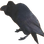

<class 'PIL.Image.Image'>
1178
Columba-livia111_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia111_jpg.rf Background Removed.bebf837652d13bd824c8b7aa1df5a74c.png


<class 'PIL.Image.Image'>
451
images266_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images266_jpg.rf Background Removed.830031058ce4daaa994e4eb18e1389a4.png


<class 'PIL.Image.Image'>
1038
ZVAE78U924OD_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/ZVAE78U924OD_jpg.rf Background Removed.3480e80804d7165bbdc10b3624e4e4e9.png


<class 'PIL.Image.Image'>
423
FWUYW6FGIFQA_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FWUYW6FGIFQA_jpg.rf Background Removed.985d8efdf758dc2d51cc8855f22fe5e7.png


<class 'PIL.Image.Image'>
237
img401_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img401_jpeg_jpg.rf Background Removed.2a737a703683f61bb752a8e2b4953de0.png


<class 'PIL.Image.Image'>
1014
IKUJ1L7I3C1U_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/IKUJ1L7I3C1U_jpg.rf Background Removed.3931385874f006d2418f9e9a401f198e.png


<class 'PIL.Image.Image'>
618
Rock-Pigeon-6_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-6_jpg.rf Background Removed.c104cb9d8efa85ba095f248264a1390a.png


<class 'PIL.Image.Image'>
1153
crow-1287-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1287-_jpg.rf Background Removed.68783274654fcf6df4fd23d109088abd.png


<class 'PIL.Image.Image'>
170
crow-1244-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1244-_jpg.rf Background Removed.d0f04b25a3e6b2ae1e2ebbaf7462415b.png


<class 'PIL.Image.Image'>
548
MFJT90P4O62V_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/MFJT90P4O62V_jpg.rf Background Removed.1146a2fdc05adfb04427e84fe36db091.png


<class 'PIL.Image.Image'>
414
Rock-Pigeon-275_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-275_jpg.rf Background Removed.c79318ea19aeee3907c9071e2a3b137a.png


<class 'PIL.Image.Image'>
610
Rock-Pigeon-144_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-144_jpg.rf Background Removed.a530689bc4305edde468d914648e7a50.png


<class 'PIL.Image.Image'>
224
IMG_4610_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4610_JPG_jpg.rf Background Removed.90df6644bd51b9b5fda0a0e8f9c37971.png


<class 'PIL.Image.Image'>
200
000005_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000005_jpg.rf Background Removed.0f34b868fc986ee85f80af1052196a17.png


<class 'PIL.Image.Image'>
565
download-18-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-18-_jpeg.rf Background Removed.6b13c296223f1de87b69e5ff259621ab.png


<class 'PIL.Image.Image'>
285
27c0c791253dc3c3fbcaa9c35c80588e-counting-crows-raven-art_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/27c0c791253dc3c3fbcaa9c35c80588e-counting-crows-raven-art_jpg.rf Background Removed.82e46e642c4c96811ecb737cffe77c64.png


<class 'PIL.Image.Image'>
743
img602_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img602_jpeg_jpg.rf Background Removed.c6dfd88915e2f5d3bf3ce12b756fba6c.png


<class 'PIL.Image.Image'>
1238
Rock-Pigeon-186_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-186_JPG_jpg.rf Background Removed.17bc31bb46997985880c6f6541af275a.png


<class 'PIL.Image.Image'>
728
crow-1451-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1451-_jpg.rf Background Removed.ede98a5a81fee800b3d16d322b658823.png


<class 'PIL.Image.Image'>
134
0x83C370C198BE2315AB3C0C3F539CEF87_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/0x83C370C198BE2315AB3C0C3F539CEF87_jpeg.rf Background Removed.3d02ce42c46a5c7cc06b6156bfadd09b.png


<class 'PIL.Image.Image'>
632
Rock-Pigeon-192_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-192_jpg.rf Background Removed.154384ac68f20fae3143d9e1eb0054bb.png


<class 'PIL.Image.Image'>
340
images-80-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-80-_jpeg.rf Background Removed.deff218ca76cc7c8cdf86be5b08a2de5.png


<class 'PIL.Image.Image'>
989
Rock-Pigeon-36_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-36_jpg.rf Background Removed.2a3db1518e8ba595526008bea9c07a46.png


<class 'PIL.Image.Image'>
798
20231009_165322_320_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_320_jpg.rf Background Removed.7a8bf8f5c12d7690a017286f7beead08.png


<class 'PIL.Image.Image'>
35
images280_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images280_jpg.rf Background Removed.cfe41cbac15893a87ddb214a8cd2f813.png


<class 'PIL.Image.Image'>
63
carrion-crow-corvus-corone-sitting-260nw-2160030909_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/carrion-crow-corvus-corone-sitting-260nw-2160030909_jpg.rf Background Removed.2b278425f542f5b8d5424c1c8a716228.png


<class 'PIL.Image.Image'>
826
crow-1415-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1415-_jpg.rf Background Removed.afcc52c027e87b885bef767259832c7a.png


<class 'PIL.Image.Image'>
384
images-43-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-43-_jpeg.rf Background Removed.ef8a773183a375058070e70f6a5ffad5.png


<class 'PIL.Image.Image'>
87
img17_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img17_jpg.rf Background Removed.de630583acd2d109c524ef33e28dcadd.png


<class 'PIL.Image.Image'>
37
crow-1463-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1463-_jpg.rf Background Removed.7dc1fcbb21103e3813047bbb792f9f83.png


<class 'PIL.Image.Image'>
144
ddf5f6bb803b404381b25dbf0c42689e_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/ddf5f6bb803b404381b25dbf0c42689e_jpg.rf Background Removed.03651b5d3e6e519d0d7232ea7560fc5c.png
<class 'NoneType'>
PSQFSYDO9925_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PSQFSYDO9925_jpg.rf Background Removed.6fdf09db77ae285e280233a005f8325a.png


<class 'PIL.Image.Image'>
912
Columba-livia170_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia170_jpg.rf Background Removed.ff386881e853b8051c0884dcc57d6bad.png


<class 'PIL.Image.Image'>
117
136_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/136_jpg.rf Background Removed.c5011d423c787d94873bd2554b362ffb.png


<class 'PIL.Image.Image'>
1131
NN9FJBW1PR7S_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/NN9FJBW1PR7S_jpg.rf Background Removed.4ad3df2092eb036c7b290aebdb870ca7.png


<class 'PIL.Image.Image'>
145
Rock-Pigeon-7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-7_jpg.rf Background Removed.9e1c3a4ce5461ddd9fe173bc8de197ee.png


<class 'PIL.Image.Image'>
305
Rock-Pigeon-88_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-88_jpg.rf Background Removed.8a0f1a5329cfdffca06815d151850270.png


<class 'PIL.Image.Image'>
446
image26_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image26_jpeg.rf Background Removed.43fc5f89580f50ffd72e90423fd17878.png


<class 'PIL.Image.Image'>
596
052_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/052_jpg.rf Background Removed.78b298e3ee2f37a2d3ffadfccc27f84d.png


<class 'PIL.Image.Image'>
1000
37d8cded5e93443a964e98ba6fe1df0c_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/37d8cded5e93443a964e98ba6fe1df0c_jpg.rf Background Removed.141396364111889beb888d6566d3462c.png
<class 'NoneType'>
b770f1cae0f342849d6aa3924507d20b_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/b770f1cae0f342849d6aa3924507d20b_jpg.rf Background Removed.9f3b4f474132f4940b950d55ee08ffa5.png
<class 'NoneType'>
118_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/118_jpg.rf Background Removed.6609d13194fa7894ce6f3df3cce5b776.png


<class 'PIL.Image.Image'>
689
012_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/012_jpg.rf Background Removed.29b5a43ae30684905b1d8899a73b71a3.png


<class 'PIL.Image.Image'>
762
images149_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images149_jpg.rf Background Removed.5407f8bc33a1ffd8af69ab7cb03ec015.png


<class 'PIL.Image.Image'>
212
carrion-crow-corvus-corone-vienna-austria-2HYKMR4_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/carrion-crow-corvus-corone-vienna-austria-2HYKMR4_jpg.rf Background Removed.4a2790ff428d9684913051c967ac2abe.png


<class 'PIL.Image.Image'>
701
Rock-Pigeon-76_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-76_jpg.rf Background Removed.b45090184585c205acdba654f3635c20.png


<class 'PIL.Image.Image'>
616
FJ1PCD8D17N8_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/FJ1PCD8D17N8_aug_jpg.rf Background Removed.86a9382900a6d3969010ac7df3bbe999.png


<class 'PIL.Image.Image'>
295
Rock-Pigeon-58_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-58_jpg.rf Background Removed.ca3e660c034c93e5cf587cc29d051606.png


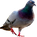

<class 'PIL.Image.Image'>
260
images-2024-01-19T222624-546_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222624-546_jpeg.rf Background Removed.4c4c015cde2a35e4302829a651891999.png


<class 'PIL.Image.Image'>
383
Rock-Pigeon-292_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-292_jpg.rf Background Removed.3f584c8a1d763e85e439edec42c1833a.png


<class 'PIL.Image.Image'>
36
Rock-Pigeon-70_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-70_jpg.rf Background Removed.332d91caf2d688dd30b5665f94de741a.png


<class 'PIL.Image.Image'>
82
KakaoTalk_20240615_220823841_29_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_29_jpg.rf Background Removed.664a9aad3477799d6cef86ec5e639326.png


<class 'PIL.Image.Image'>
520
5I8Y6HNYX9PO_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/5I8Y6HNYX9PO_jpg.rf Background Removed.c3a52999d9342dbd5e9da1be3fca334b.png


<class 'PIL.Image.Image'>
718
Rock-Pigeon-319_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-319_jpg.rf Background Removed.040a3ef0476da0d5db5164417e2ec491.png


<class 'PIL.Image.Image'>
29
crow-1377-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1377-_jpg.rf Background Removed.623d608ab13d69afb2cf2988d13b3b38.png


<class 'PIL.Image.Image'>
261
000027_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000027_jpg.rf Background Removed.3940ff46d28c6f10f3f3678af91f746e.png


<class 'PIL.Image.Image'>
97
000042_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000042_jpg.rf Background Removed.f21834bf6859592f9d59f928a280c5a0.png


<class 'PIL.Image.Image'>
725
QSDO4XE5LRXF_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/QSDO4XE5LRXF_jpg.rf Background Removed.82ff4edfe9f21017b0a0d37aed655ce5.png


<class 'PIL.Image.Image'>
862
000078_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000078_jpg.rf Background Removed.bdb3ed1ea2676a201e29e3680f62d54a.png


<class 'PIL.Image.Image'>
411
images184_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images184_jpg.rf Background Removed.62c8c261316f1397daa127d413789fcf.png


<class 'PIL.Image.Image'>
661
Rock-Pigeon-248_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-248_jpg.rf Background Removed.7add695ac8e74cf65b7b444678ce8c1e.png


<class 'PIL.Image.Image'>
1081
image7_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image7_jpeg.rf Background Removed.796a8858edca2f7d75d369c514595cb9.png


<class 'PIL.Image.Image'>
549
2KEOC8C0OTWC_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2KEOC8C0OTWC_jpg.rf Background Removed.2084a51424f09bf41da2941e4e2f508d.png


<class 'PIL.Image.Image'>
412
Columba-livia55_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia55_jpg.rf Background Removed.6680556ba7d1841512b33cc5f2b05b8f.png


<class 'PIL.Image.Image'>
39
img339_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img339_jpeg_jpg.rf Background Removed.c60e6e21b2c8b6a20b76df48a60b7603.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the 

<class 'PIL.Image.Image'>
926
img595_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img595_jpeg_jpg.rf Background Removed.e0610c62af3881cbc1e170aa2dd0a3da.png


<class 'PIL.Image.Image'>
14
Columba-livia80_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia80_jpg.rf Background Removed.59659a620865126b12c05b7e4d932e7c.png


<class 'PIL.Image.Image'>
736
108_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/108_jpg.rf Background Removed.483768bce43d09810f5178b54014ac81.png


<class 'PIL.Image.Image'>
1001
7AYPSS99CO12_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/7AYPSS99CO12_aug_jpg.rf Background Removed.d528d7f207aac8d52eb7d7fdc4a5a50a.png


<class 'PIL.Image.Image'>
366
6S1P1DS1IWZN_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/6S1P1DS1IWZN_jpg.rf Background Removed.87c6e280af910eb988f5eacd85d686d4.png


<class 'PIL.Image.Image'>
470
images131_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images131_jpg.rf Background Removed.2756605627f0d48d71d5c9c58e5b06ac.png


<class 'PIL.Image.Image'>
1267
UQDJVV7NC7RL_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UQDJVV7NC7RL_aug_jpg.rf Background Removed.4d0c7537d726dd8e4e488efafaf8ae27.png


<class 'PIL.Image.Image'>
777
crow-1225-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1225-_jpg.rf Background Removed.1c038697a1b2bded4b1351820b2a0aad.png


<class 'PIL.Image.Image'>
1087
KNOLZLSSZXNH_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KNOLZLSSZXNH_jpg.rf Background Removed.f752634c4f7bbdaa0260577b24755b4c.png


<class 'PIL.Image.Image'>
521
download-4-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-4-_jpeg.rf Background Removed.feedbc008c25f5343363b5a8c91e38e9.png


<class 'PIL.Image.Image'>
393
Rock-Pigeon-235_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-235_jpg.rf Background Removed.e6efe9ed2502b2f5e2633107826e5705.png


<class 'PIL.Image.Image'>
96
images117_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images117_jpg.rf Background Removed.0cfcbda3bf21a613a824cb7603fb3d25.png


<class 'PIL.Image.Image'>
160
crow-1393-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1393-_jpg.rf Background Removed.59fc61104a618f78269c827460d84d61.png


<class 'PIL.Image.Image'>
1048
Columba-livia61_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia61_jpg.rf Background Removed.15a8c9d6831df2e8a4999f4bf6cb750a.png


<class 'PIL.Image.Image'>
477
crow-1372-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1372-_jpg.rf Background Removed.e49575c6b6a8d7d73073a2a8c3b9a4ec.png


<class 'PIL.Image.Image'>
430
sb1opc3b0msz_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/sb1opc3b0msz_jpg.rf Background Removed.bede8503188b9d8a01d74b22c5a1066f.png


<class 'PIL.Image.Image'>
495
Rock-Pigeon-352_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-352_jpg.rf Background Removed.3825f305d9d2816bf222eda88d08f9ff.png


<class 'PIL.Image.Image'>
130
download-8-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/download-8-_jpeg.rf Background Removed.9da8073da7b23cfdf74a85004b01dad9.png


<class 'PIL.Image.Image'>
1119
BYTWWJ9SAFJL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/BYTWWJ9SAFJL_jpg.rf Background Removed.6df5cae4826d7fe1ea82b5484b88a1ef.png


<class 'PIL.Image.Image'>
419
crow-1433-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1433-_jpg.rf Background Removed.7bef3cfe5a7828cfa02ba9a5b34a82a5.png


<class 'PIL.Image.Image'>
706
000055_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000055_jpg.rf Background Removed.f51da67c86514de6da913b7a8fa34f2b.png


<class 'PIL.Image.Image'>
1207
images-2024-01-19T222554-586_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222554-586_jpeg.rf Background Removed.1afb1f3ccbce69c663e3781ebde7ed7d.png


<class 'PIL.Image.Image'>
1063
20231009_165322_140_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/20231009_165322_140_jpg.rf Background Removed.dd58228029f75b3d8d69cb915443fdce.png


<class 'PIL.Image.Image'>
371
images-54-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-54-_jpeg.rf Background Removed.7a94524887c909b2c5f8c42933174eb6.png


<class 'PIL.Image.Image'>
791
crow-1435-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1435-_jpg.rf Background Removed.972fd9a446c0e2012b0d62e93c3a336f.png


<class 'PIL.Image.Image'>
610
EQN4R0CJTDWR_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/EQN4R0CJTDWR_jpg.rf Background Removed.957e74ab74905bf65bcf918e70388555.png


<class 'PIL.Image.Image'>
576
crow-1345-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1345-_jpg.rf Background Removed.067121d5bac0b94e89ed76ad5a67d2c5.png


<class 'PIL.Image.Image'>
696
UQDJVV7NC7RL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UQDJVV7NC7RL_jpg.rf Background Removed.9e57aa27e0ac1fb31f4ca5744efd094b.png


<class 'PIL.Image.Image'>
672
Rock-Pigeon-98_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-98_jpg.rf Background Removed.801770e6821346844164d8819dcb6a0d.png


<class 'PIL.Image.Image'>
329
000061_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000061_jpg.rf Background Removed.7bd52a649259d9b6c68f50021aa15f49.png


<class 'PIL.Image.Image'>
1250
eefd915cfa1c468893f842005c8118f5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/eefd915cfa1c468893f842005c8118f5_jpg.rf Background Removed.dd2e2f6efcbf5443ab5c1bea715d0029.png
<class 'NoneType'>
Rock-Pigeon-3_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-3_jpg.rf Background Removed.38828b0addf92bf86fe00865a124581f.png


<class 'PIL.Image.Image'>
95
Rock-Pigeon-62_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-62_jpg.rf Background Removed.f0a4813ea54852c586dbeba8bb878df9.png


<class 'PIL.Image.Image'>
266
crow-1330-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1330-_jpg.rf Background Removed.4c5a7794981080b3fd3ed1699d4cde81.png


<class 'PIL.Image.Image'>
669
crow-1302-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1302-_jpg.rf Background Removed.5315fd3649e28dd0db20f80bd1b7fb59.png


<class 'PIL.Image.Image'>
936
images-36-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-36-_jpeg.rf Background Removed.4fc1d1f6fd69ecf9aa409fc48252fabb.png


<class 'PIL.Image.Image'>
1102
IMG_4614_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4614_JPG_jpg.rf Background Removed.021989475a7d99f7d59ca71a571f32a0.png


<class 'PIL.Image.Image'>
407
image16_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image16_jpeg.rf Background Removed.95257eaaf4becc8f7fe77d69876f7634.png


<class 'PIL.Image.Image'>
513
image18_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/image18_jpeg.rf Background Removed.380f3b5ff0ec3abb1d927f5f86092564.png


<class 'PIL.Image.Image'>
969
crow-1265-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1265-_jpg.rf Background Removed.c87237ab904a005e895a2be86b092470.png


<class 'PIL.Image.Image'>
958
images129_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images129_jpg.rf Background Removed.df762255c4ee7d25d36a49fb2f3bfa43.png


<class 'PIL.Image.Image'>
215
images-2024-01-19T222624-546_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222624-546_jpeg.rf Background Removed.4c4c015cde2a35e4302829a651891999.png


<class 'PIL.Image.Image'>
370
images58_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images58_jpg.rf Background Removed.8774fda1fa0dff91ca7cf8480157f0cf.png


<class 'PIL.Image.Image'>
1204
images149_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images149_jpg.rf Background Removed.5407f8bc33a1ffd8af69ab7cb03ec015.png


<class 'PIL.Image.Image'>
860
50XI8KMTVAC3_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/50XI8KMTVAC3_jpg.rf Background Removed.391c4cf857c3ef1acdbf349ca990d909.png


<class 'PIL.Image.Image'>
1087
PZKYLHAQ2AVX_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/PZKYLHAQ2AVX_aug_jpg.rf Background Removed.d55f687f8ca37ce15117fda10a87ac7b.png


<class 'PIL.Image.Image'>
325
000059_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000059_jpg.rf Background Removed.882b34d63568936d716fd3fe1ff83d69.png


<class 'PIL.Image.Image'>
681
images-2024-01-19T222901-525_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222901-525_jpeg.rf Background Removed.ea0f868b672add8ce0bc3dd45604b2c0.png


<class 'PIL.Image.Image'>
920
crow-1206-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1206-_jpg.rf Background Removed.d37343aeb763598578acce1d82532d2f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box


<class 'PIL.Image.Image'>
952
318ad96e78484fc0840c92e38bc3aad5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/318ad96e78484fc0840c92e38bc3aad5_jpg.rf Background Removed.d64e1d44dcb45544ac1ef04cd01793a1.png
<class 'NoneType'>
000059_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000059_jpg.rf Background Removed.882b34d63568936d716fd3fe1ff83d69.png


<class 'PIL.Image.Image'>
1206
Columba-livia13_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia13_jpg.rf Background Removed.412c069938accc75a2af3c027067cf61.png


<class 'PIL.Image.Image'>
190
images5_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images5_jpg.rf Background Removed.692e3864c2248d4791228d33d0204219.png


<class 'PIL.Image.Image'>
506
Rock-Pigeon-130_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-130_jpg.rf Background Removed.69c8d9ed9c8fc6c37b8757d6ffb15c65.png


<class 'PIL.Image.Image'>
424
VZN5I8QLSC0F_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/VZN5I8QLSC0F_aug_jpg.rf Background Removed.dc0f59b302daf6cb58ec66739983395a.png


<class 'PIL.Image.Image'>
540
108_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/108_jpg.rf Background Removed.483768bce43d09810f5178b54014ac81.png


<class 'PIL.Image.Image'>
825
YDPJFGMOPXU8_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/YDPJFGMOPXU8_jpg.rf Background Removed.92281a0f7eb5248044a37790e2812929.png


<class 'PIL.Image.Image'>
1021
146_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/146_jpg.rf Background Removed.6aacf99e913f549e2217c846b496e4a8.png


<class 'PIL.Image.Image'>
398
Rock-Pigeon-70_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-70_jpg.rf Background Removed.332d91caf2d688dd30b5665f94de741a.png


<class 'PIL.Image.Image'>
719
2XHZR46ZHFZH_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/2XHZR46ZHFZH_jpg.rf Background Removed.ebaa47df241610997960656e6bb9a507.png


<class 'PIL.Image.Image'>
433
crow-1477-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1477-_jpg.rf Background Removed.416fe2081ae76be79a26ad25862283d2.png


<class 'PIL.Image.Image'>
1116
000085_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000085_jpg.rf Background Removed.55781e1cb2bf5a9fb0bc19150cd3c6ea.png


<class 'PIL.Image.Image'>
1210
crow-1270-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1270-_jpg.rf Background Removed.3989b5ac720f255665e7dede60db8ea6.png


<class 'PIL.Image.Image'>
1212
TNK8N3YUNE52_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/TNK8N3YUNE52_jpg.rf Background Removed.0ea5e05b41a2eb3cf64eb0d993189682.png


<class 'PIL.Image.Image'>
571
crow-1457-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1457-_jpg.rf Background Removed.105cf394a5be29f935d320a603949a35.png


<class 'PIL.Image.Image'>
686
images-96-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-96-_jpeg.rf Background Removed.d0a588f2f9b3776dc9d72b524cc68f85.png


<class 'PIL.Image.Image'>
499
015_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/015_jpg.rf Background Removed.81c56d8156227bacbd0503c7de514409.png


<class 'PIL.Image.Image'>
550
7b7de489ee544eb7810559d8dbe5946e_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/7b7de489ee544eb7810559d8dbe5946e_jpg.rf Background Removed.c0ff316bf81cc4c2156af3523204d21a.png
<class 'NoneType'>
Rock-Pigeon-143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-143_jpg.rf Background Removed.6b8b1a92ce031937cadff1b1b698d307.png


<class 'PIL.Image.Image'>
348
6EMLY3326YAB_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/6EMLY3326YAB_jpg.rf Background Removed.b05495d7d68be12e858dadab1946b464.png


<class 'PIL.Image.Image'>
1083
Rock-Pigeon-142_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-142_jpg.rf Background Removed.28f097a36513a9de856f2087d18816ba.png


<class 'PIL.Image.Image'>
615
crow-1380-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1380-_jpg.rf Background Removed.331aaeffd9dee0e3ff960711a43c83b1.png


<class 'PIL.Image.Image'>
1144
crow-1388-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1388-_jpg.rf Background Removed.d5cec6713bbdb0e4c101b7dee5fe9f28.png


<class 'PIL.Image.Image'>
862
KQP5OCLEBLAR_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/KQP5OCLEBLAR_jpg.rf Background Removed.ec7176424995794f28e4e9db2c4b65ec.png


<class 'PIL.Image.Image'>
385
crow-1222-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1222-_jpg.rf Background Removed.6aa2d90f5f5f31ae17880b8fe0914056.png


<class 'PIL.Image.Image'>
363
000042_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000042_jpg.rf Background Removed.f21834bf6859592f9d59f928a280c5a0.png


<class 'PIL.Image.Image'>
118
Rock-Pigeon-372_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-372_jpg.rf Background Removed.72ffc614ec81d44c4d1b89ac3c79910f.png


<class 'PIL.Image.Image'>
681
000075_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000075_jpg.rf Background Removed.1195b6d4a37ef7def94f29774eed685f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
Rock-Pigeon-139_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-139_jpg.rf Background Removed.56902549fe5681ed829f6f1c73bd2d20.png


<class 'PIL.Image.Image'>
569
01597685_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/01597685_jpg.rf Background Removed.b61752f3c45acae355cb00406185cd42.png


<class 'PIL.Image.Image'>
721
fe5bf96644af46848695aac70eb7b454_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/fe5bf96644af46848695aac70eb7b454_jpg.rf Background Removed.a6617302e5d816c85137236bc3fbce0e.png
<class 'NoneType'>
IMG_4678_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4678_JPG_jpg.rf Background Removed.cb5e50b0ac98caddc79ef1863319651c.png


<class 'PIL.Image.Image'>
297
YRY5IUUGGC5B_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_jpg.rf Background Removed.40d07bee3d8c87bcecd0a5ec5d05e182.png


<class 'PIL.Image.Image'>
1017
Rock-Pigeon-332_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-332_jpg.rf Background Removed.5324806419e35cec94a3b6457dec243f.png


<class 'PIL.Image.Image'>
687
Columba-livia348_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia348_jpg.rf Background Removed.c9a8903f5627d6385723ee9f8249457c.png


<class 'PIL.Image.Image'>
859
Columba-livia210_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia210_jpg.rf Background Removed.13be31d2f9daa04f2e17e3dcd97f980b.png


<class 'PIL.Image.Image'>
607
054_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/054_jpg.rf Background Removed.0a79275c1ad26ad50bf0772dc2a50104.png


<class 'PIL.Image.Image'>
1186
img172_jpeg_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img172_jpeg_jpg.rf Background Removed.dc015087647aa01325472cc0f6feb983.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
7RUEBGYP6UPO_aug_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/7RUEBGYP6UPO_aug_jpg.rf Background Removed.d352908518873c4ab45db66e7c9044b2.

<class 'PIL.Image.Image'>
184
carrion-crow-turkenshanzpark-vienna-2_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/carrion-crow-turkenshanzpark-vienna-2_jpg.rf Background Removed.3d492414c9b19ed24f6b6e22bb7ce3dc.png


<class 'PIL.Image.Image'>
838
N25U9GHSYZ92_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/N25U9GHSYZ92_jpg.rf Background Removed.c4d2a11c76b997f730e3a904300e4e60.png
crow-1318-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1318-_jpg.rf Background Removed.56ba60a87c579ca534ddb8c8abd9df03.png


<class 'PIL.Image.Image'>
523
crow-1227-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1227-_jpg.rf Background Removed.418f94e418d8c38b9d3054bc5a4cea00.png


<class 'PIL.Image.Image'>
340
crow-1490-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1490-_jpg.rf Background Removed.a6b4331a73bfab19b19991b72bf5e0b5.png


<class 'PIL.Image.Image'>
425
Rock-Pigeon-143_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-143_jpg.rf Background Removed.6b8b1a92ce031937cadff1b1b698d307.png
000028_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000028_jpg.rf Background Removed.3b81906280afd4e77d481b330647e244.png


<class 'PIL.Image.Image'>
389
Columba-livia332_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia332_jpg.rf Background Removed.ddf081f88b01d5228e6670a2e81c0ad0.png


<class 'PIL.Image.Image'>
511
IMG_4573_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4573_JPG_jpg.rf Background Removed.8d383052d6f0b98820fc79c2e78216bc.png


<class 'PIL.Image.Image'>
684
Rock-Pigeon-280_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-280_jpg.rf Background Removed.816cf29b89e0e653389c3f22bec83a8a.png
IMG_4594_JPG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/IMG_4594_JPG_jpg.rf Background Removed.ef7a98faf4073c23f69d2a8ac4c0e85c.png


<class 'PIL.Image.Image'>
831
64QRR4B9EBU7_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/64QRR4B9EBU7_jpg.rf Background Removed.7aab8dd6263f32b880dfca85474b0843.png


<class 'PIL.Image.Image'>
283
Rock-Pigeon-235_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-235_jpg.rf Background Removed.e6efe9ed2502b2f5e2633107826e5705.png


<class 'PIL.Image.Image'>
1134
crow-1263-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1263-_jpg.rf Background Removed.604a5887d2ffc2baf7b270fa3063be2d.png


<class 'PIL.Image.Image'>
1067
QOC3C5WBNPUL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/QOC3C5WBNPUL_jpg.rf Background Removed.66888b1e78e9cfb441ae0c3cfe8ad17f.png


<class 'PIL.Image.Image'>
690
Columba-livia101_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia101_jpg.rf Background Removed.6e543c2230a0922aecf9c5952dc0192f.png


<class 'PIL.Image.Image'>
486
crow-1244-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1244-_jpg.rf Background Removed.d0f04b25a3e6b2ae1e2ebbaf7462415b.png


<class 'PIL.Image.Image'>
1081
images96_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images96_jpg.rf Background Removed.5daf80df31e85f83fa2c9f36dc3c527a.png


<class 'PIL.Image.Image'>
1180
CBBNXZTKO5O3_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/CBBNXZTKO5O3_jpg.rf Background Removed.eaf3d7fb1091cf185b30fcda000ebc7a.png


<class 'PIL.Image.Image'>
657
F1L0IX5UFFFL_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/F1L0IX5UFFFL_jpg.rf Background Removed.0b63b085b5179191df3d770ecd5b17e0.png


<class 'PIL.Image.Image'>
973
Rock-Pigeon-368_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-368_jpg.rf Background Removed.1eed85f1c96fd033592fadc610432ba4.png


<class 'PIL.Image.Image'>
331
Rock-Pigeon-51_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-51_jpg.rf Background Removed.680ce41faaeb5511c8d4df9f55b63c1a.png


<class 'PIL.Image.Image'>
611
images-7-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-7-_jpeg.rf Background Removed.aee95e8f76ada80015d4250a72b6525c.png


<class 'PIL.Image.Image'>
898
070_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/070_jpg.rf Background Removed.4a905c545cd4dd80f1bab91849ce9000.png


<class 'PIL.Image.Image'>
160
T9WTAI6I8YCG_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/T9WTAI6I8YCG_jpg.rf Background Removed.10ab0a5c15eea985e22d9d4a2f7e6069.png


<class 'PIL.Image.Image'>
630
images324_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/images324_jpg.rf Background Removed.42536452d0d91c189bc4d363d493d621.png


<class 'PIL.Image.Image'>
177
images-37-_jpeg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/images-37-_jpeg.rf Background Removed.5d6f7618efd55f076aebfc3d0ba369aa.png


<class 'PIL.Image.Image'>
440
Columba-livia99_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Columba-livia99_jpg.rf Background Removed.6f6150df01d19692bb1001e3b6c16e3f.png
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
the opacity is too little for the largest bounding box
<class 'NoneType'>
000034_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/000034_jpg.rf Background Removed.9e2435ab1636b6571ceb50d4f6903c0c.png


<class 'PIL.Image.Image'>
343
Rock-Pigeon-52_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-52_jpg.rf Background Removed.68f7c3864ccefeae2f1e1605b648cf29.png


<class 'PIL.Image.Image'>
354
Rock-Pigeon-308_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-308_jpg.rf Background Removed.28c7c82c8eff5d74742b1a66cc4dafe8.png


<class 'PIL.Image.Image'>
894
crow-1395-_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/crow-1395-_jpg.rf Background Removed.3a2dda321d15505b6117c9af5e861889.png


<class 'PIL.Image.Image'>
472
UQODV397FUN0_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/UQODV397FUN0_jpg.rf Background Removed.eb6e3cabde146d1c3f151e587cecccf4.png


<class 'PIL.Image.Image'>
19
img359_jpg
/notebooks/DL---detection-of-birds-in-drone-images/data/Subject images crows/Subjects not pixelated/crows/img359_jpg.rf Background Removed.fe020135ad1d2912fa91349d6f46af6c.png


<class 'PIL.Image.Image'>
903


In [11]:
from typing import List
import re

skipped_tile_paths = []

class Label:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max


def parse_labels(labels: List[str], original_w: int, original_h: int) -> List[Label]:
    parsed_labels = []
    for label in labels:
        coords = label.split(" ")[1:]

        width = float(coords[2])
        height = float(coords[3])

        x_min = float(coords[0]) - (width/2)
        y_min = float(coords[1]) - (height/2)
        x_max = x_min + width
        y_max = y_min + height

        parsed_labels.append(
            Label(
                x_min * original_w,
                x_max * original_w,
                y_min * original_h,
                y_max * original_h
            )
        )
    return parsed_labels

for original_path, tiles in all_new_tiles.items():
    label_file = original_path.replace("/images", "/labels")
    label_file = ".".join(label_file.split(".")[:-1]) + ".txt"
    
    average_rel_width, average_rel_height = get_average_bounding_box(label_file)

    with open(label_file, "r") as f:
        parsed_labels = parse_labels(f.readlines(), tiles[0]["w"], tiles[0]["h"])

    last_folder_name = INPUT_FOLDER.split("/")[-1]
    search = re.search(rf"{last_folder_name}/(.*?)/images/", original_path)
    variant = search.group(1)

    for i, tile in enumerate(tiles):
        # Place tile image
        tile_img_file_name = ".".join(original_path.split("/")[-1].split(".")[:-1]) + "_tile-" + str(i) + ".png"
        tile_img_path = os.path.join(OUTPUT_FOLDER, variant, "images", tile_img_file_name)
        cv2.imwrite(tile_img_path, tile["tile"])

        # Figure out which labels of the labels of the original image are in the tile, and adapt the coordinates accordingly
        tile_labels = []
        for label_i, label in enumerate(parsed_labels):
            if (tile["x_min"] < label.x_min and tile["x_max"] > label.x_max and
                tile["y_min"] < label.y_min and tile["y_max"] > label.y_max):

                x_min = label.x_min - tile["x_min"]
                y_min = label.y_min - tile["y_min"]
                x_max = label.x_max - tile["x_min"]
                y_max = label.y_max - tile["y_min"]

                tile_width = tile["x_max"] - tile["x_min"]
                tile_height = tile["y_max"] - tile["y_min"]

                label_relative_width = (x_max - x_min) / tile_width
                label_relative_height = (y_max - y_min) / tile_height

                tile_labels.append(f"0 {x_min / tile_width + (label_relative_width / 2)} {y_min / tile_height + (label_relative_height / 2)} "
                                   f"{label_relative_width} "
                                   f"{label_relative_height}")


        tile_label_file_name = tile_img_file_name.replace(".png", ".txt")
        tile_label_path = os.path.join(OUTPUT_FOLDER, variant, "labels", tile_label_file_name)
        with open(tile_label_path, "w") as f:
            f.write("\n".join(tile_labels))
            
        # only for tiles in the train set, do augment the pictures with synthetic birds
        # This is most likely due to an issue of the src type of the image
        if "train" in tile_img_path:
            # When there is no existing bird in the picture we skip the picture and we do not add new birds in the picture
            if average_rel_width == 0:
                continue
            try:
                add_picture_to_picture(tile_img_path, tile_label_path, average_rel_width, average_rel_height)
            except:
                skipped_tile_paths.append(tile_img_path)

In [12]:
print("we skipped ", len(skipped_tile_paths), "tiles because they couldn't be added")

we skipped  102 tiles because they couldn't be added


# Visualization
For testing purposes

The last bounding box that is added is made green. This works in almost all cases. Except when the bounding box is not added because in the previous step there was an error with the image. I could't figure out what the problem was so I just skipped it. But there are 102 tiles that do not have had added a bonto them because of that. 

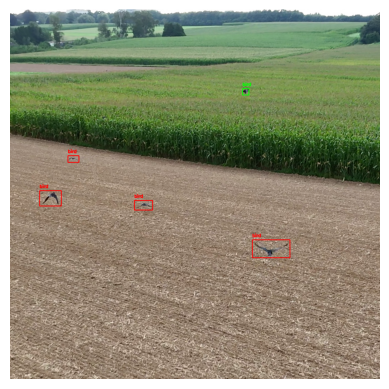

In [16]:
import cv2
import matplotlib.pyplot as plt

def load_yolo_labels(label_path):
    boxes = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            class_id, x_center, y_center, width, height = map(float, parts)
            boxes.append((int(class_id), x_center, y_center, width, height))
    return boxes

def draw_yolo_boxes(image_path, label_path, class_names=None):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = load_yolo_labels(label_path)
    for index, (class_id, x_center, y_center, width, height) in enumerate(boxes):
        # Convert normalized YOLO coords to pixel coords
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        
        # if the box is the last box, then the color becomes green
        # the last box is the added box
        if index == len(boxes)-1:
            color = (0, 255, 0)  # Red box
        else:
            color = (255, 0, 0)  # Red box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        label = str(class_id)
        if class_names and class_id < len(class_names):
            label = class_names[class_id]

        cv2.putText(image, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/notebooks/DL---detection-of-birds-in-drone-images/data/tiled_augmented_yolo_data/train/images/20240903085339_0270_D_frame_4290 - kopie_tile-1.png'
label_path = '/notebooks/DL---detection-of-birds-in-drone-images/data/tiled_augmented_yolo_data/train/labels/20240903085339_0270_D_frame_4290 - kopie_tile-1.txt'  # same base name as image
class_names = ['bird']  # optional

draw_yolo_boxes(image_path, label_path, class_names)
